<a href="https://colab.research.google.com/github/lemcat55/Trader_Notebook/blob/main/Trader's_Notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIBRARY OF PREDEFINED FUNCTIONS
The functions defined in this section are used and explained in the further sections. It takes about 10-30 seconds to load the library.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.parsers import read_csv
import numpy as np
import os
import torch
import torchvision
#import tarfile
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from PIL import Image
import random
from datetime import date
import math
from matplotlib.ticker import FormatStrFormatter
from datetime import datetime

# Library:
watch_list=[]
dict_df={}

def ymd(s):
  if '/' in s: 
    mdy=s.split('/')
    m=mdy[0]
    d=mdy[1]
    y=mdy[2]
  if '-' in s: 
    ymd=s.split('-')
    y=ymd[0]
    m=ymd[1]
    d=ymd[2]
  return int(y),int(m),int(d)

def index2date(nIndex,sep='-'):
  nIndex = nIndex+26089# +21132 #global index
  if nIndex==None: return "0"   #if (nIndex == undefined || isNaN(nIndex) ) return "0";
  col = nIndex;
  j = -1 + 7 * math.floor((col + 1) / 5) + (col + 1) % 5
  i = 1900;
  i = 1900 + 4 * math.floor(j / 1461);
  j = j % 1461 + 1  #	// 1 jan
  while j > 0:
      i+=1
      j -= 365
      if (i % 4 == 0): j -= 1
  j += 365
  if i % 4 == 0: j += 1;
  days = [ 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31 ];
  if i % 4 == 0: days[1] = 29;
  else: days[1] = 28;
  m = -1;
  while True:
      m+=1;
      j -= days[m];
      if j <= 0:
          j += days[m];
          break;
  year = i;
  m1 = m + 1;
  if sep=="-":
    if m1 < 10: m1 = "0" + str(m1);
    if j < 10: j = "0" + str(j);
    return str(year)+"-"+str(m1)+ "-" + str(j);
  else:
    return str(m1)+"/"+str(j)+"/"+str(year)

def date2index(sYmd):#year,month,day
  if '-' in sYmd:
    parts=sYmd.split('-')
    year=int(parts[0])
    month=int(parts[1])
    day=int(parts[2])
  else:
    parts=sYmd.split('/')
    year=int(parts[2])
    month=int(parts[0])
    day=int(parts[1])
  cum = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
  j = day - 1 #	 // jan 1
  if month > 1: j += cum[month - 2]
  if year % 4 == 0 and month > 2: j += 1
  y4 = math.floor((year - 1901) / 4)
  j += 1461 * y4
  for i in range(1901 + 4 * y4, year):
    j += 365;
    if i % 4 == 0: j += 1;
  return -1 + 5 * math.floor((j + 1) / 7) + (j + 1) %7 -26089#  #- 21132 #global index

def read_symb(stock_ticker,start,end):
  start = pd.to_datetime([start]).astype(int)[0]//10**9 # convert to unix timestamp.
  end = pd.to_datetime([end]).astype(int)[0]//10**9 # convert to unix timestamp.
  url = 'https://query1.finance.yahoo.com/v7/finance/download/' + stock_ticker + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
  df=pd.read_csv(url)
  return df

def row(i,df):
  o=df['open'].iloc[i]
  h=df['high'].iloc[i]
  l=df['low'].iloc[i]
  c=df['close'].iloc[i]
  v=df['volume'].iloc[i]
  return [o,h,l,c,v]

def modify(df,start):
  if not len(df.columns)==7: return df
  #column namws
  df.drop('Adj Close', axis=1,inplace=True)
  df.columns=['date','open','high','low','close','volume']
  #insert holydays
  rows=[]
  d=df['date'].iloc[0]
  pj=date2index(d)
  for i in range(len(df)):
    d=df['date'].iloc[i]
    j=date2index(d)
    n=j-pj-1
    for k in range(n):
      r=[index2date(j+k-1,'-')]+row(i-1,df)
      r[1]=r[1]####
      r[2]=r[2]#########
      r[3]=r[3]#########
      r[-1]=0
      rows.append(r)
    rows.append([d]+row(i,df))
    pj=j
    iStart=date2index(start)
  return pd.DataFrame(rows, index=range(iStart,iStart+len(rows)),columns=['date', 'open', 'high','low','close','volume'])

def read_data(lst,**words):
  start=words.get('start')
  if start==None: start='2007-01-01'
  today = datetime.today().strftime('%Y-%m-%d')
  end=words.get('end')
  if end==None: end=today
  dict_df={}
  for symb in lst:
    df=read_symb(symb,start,end)
    df=modify(df,start)
    dict_df[symb]=df
    print(symb+" is being read")
  return dict_df
"""
def index_from_date(s,df):
  s0=df['date'][0]
  y,m,d=ymd(s)
  if '-' in s0: start=str(y)+'-'+str(m)+'-'+str(d)
  if '/' in s0: start=str(m)+'/'+str(d)+'/'+str(y)
  lst=df.index[df['date']==s].tolist()
  if len(lst)>0: return lst[0]
  else:
    y0,m0,d0=ymd(s0)
    D0 = date(y0, m0, d0)
    D = date(y, m, d)
    idx=int((D-D0).days*5/7)
    #print(y0,m0,d0,y, m, d,idx)
    if idx<0: return 0
    if idx>=len(df)-1: return len(df)-1
    return idx
"""
def index_from_date(s):
  return date2index(s)

def make_series(watch_list,**words):
  df=dict_df[watch_list[0]]
  s=words.get("start")
  e=words.get("end")
  if s==None: nStart=0
  elif type(s)== int: nStart=s-df.index[0]
  else: nStart=date2index(s)-df.index[0]
  if e==None: nEnd=len(df)-1
  elif type(e)== int: nEnd=e-df.index[0]
  else:  nEnd=date2index(e)-df.index[0]
  open,high,low,close,volume=[],[],[],[],[]
  for symb in watch_list:
    n=watch_list.index(symb)
    df=dict_df[symb].copy()
    if nStart>0 and nEnd>nStart:
      df=df[nStart:nEnd+1]#?????????????????????
    open.append(df["open"])
    high.append(df["high"])
    low.append(df["low"])
    close.append(df["close"])
    volume.append(df["volume"])
  return open,high,low,close,volume
"""
def date_from_index(i):
  df=dict_df[watch_list[0]]  
  if i<=df.index[-1] and i>=df.index[0]:
    return df['date'][i]
  else: 
    s=df['date'][0]
    if '-' in s: sep='-'
    else: sep='/'    
    return  index2date(i,sep)
"""
def date_from_index(i):
  return  index2date(i,'-')

def zoom_in(df,**words):
  left=df.index[0]
  l=words.get('left')
  if type(l) == int:left=l
  if type(l)==str: left=index_from_date(l)
  right=df.index[-1]
  r=words.get('right')
  if type(r) == int:right=r
  if type(r)==str: right=index_from_date(r)
  start=df.index[0]
  if left>=start:left-=start
  else: left=0
  if right<=start+len(df):right-=start
  else: right=len(df)
  return df[left:right+1]

def set_dates(ax,c):
  start=c.index[0]
  end=start+len(c)-1
  locs = [start, end]
  x=date_from_index(start), date_from_index(end)
  ax.set_xticks(locs)
  ax.set_xticklabels(x)
  plt.show()

def draw_line(*arg,**words):
  ser=arg[0]
  if type(ser)==int or type(ser)==float:
    print(ser)
    return
  ttl=words.get("title")
  sz=words.get("figsize")
  if ttl==None: ttl=""
  clr=words.get("color")
  if clr==None: clr="b"
  style=words.get("linestyle")
  if style==None: style="-"
  w=words.get("linewidth")
  if w==None: w=2
  leg=words.get("legends")
  fig, ax = plt.subplots()
  if not sz==None: 
    plt.gcf().set_size_inches(*sz)  
  ser=arg[0]
  if type(ser)==int or type(ser)==float:
    print(ser)
    return
  ser.plot(color=clr,linestyle=style,linewidth=w)
  if len(arg)>1:arg[1].plot(color=clr,linestyle=style,linewidth=w)
  plt.title(ttl)
  #plt.figure(figsize=(10, 10))
  if not leg==None: plt.legend([*leg],loc="upper left")
  set_dates(ax,arg[0]) 

def v2s(v):
  ser=pd.Series(v[1:])
  start=int(v[0])
  ser.index=range(start,start+len(v)-1)
  return ser

def s2v(ser,wonan=True):
  if type(ser)==int or type(ser)==float: return [ser] 
  else: 
    ser=pd.Series(ser)
    if wonan: 
      first_valid = ser[ser.notnull()].index[0]
      ser=ser.loc[ser.index>=first_valid] 
    return np.concatenate(([ser.index[0]], ser.to_numpy()), axis = None)


def true_high(h,c):#h,c
  v1=s2v(h)
  v2=s2v(c)
  N1=len(v1)
  N2=len(v2)
  nStart=int(v1[0])
  #df=dict_df[watch_list[0]]
  #vol2=df['volume'][nStart+1]
  #if vol2==0: n23=3
  #else: n23=2
  assert  N2==N1 and N1>=2,"series should have the same number (>1) of terms"
  ar=[]
  #ar.append(nStart+n23-1)
  ar.append(nStart+1)###########
  #for i in range(n23,N1):
  for i in range(2,N1):
    #vol=df['volume'][i+nStart-1]########
    d1=v1[i]
    d2=v2[i-1]
    #if vol==0: ar.append(ar[len(ar)-1])#####
    #else: ar.append(d1 if d1>d2 else d2)
    ar.append(d1 if d1>d2 else d2)
    ans=v2s(np.array(ar))
    ans.name='true_high'
  return  ans

def true_low(l,c):#h,c
  v1=s2v(l)
  v2=s2v(c)
  N1=len(v1)
  N2=len(v2)
  nStart=int(v1[0])
  #df=dict_df[watch_list[0]]
  #vol2=df['volume'][nStart+1]
  #if vol2==0: n23=3
  #else: n23=2
  assert N2==N1 and N1>=2,"series should have the same number (>1) of terms"
  ar=[]
  #ar.append(nStart+n23-1)
  ar.append(nStart+1)
  #for i in range(n23,N1):
  for i in range(2,N1):
    #vol=df['volume'][i+nStart-1]########
    d1=v1[i]
    d2=v2[i-1]
    #if vol==0: ar.append(ar[len(ar)-1])#####
    #else: ar.append(d1 if d1<d2 else d2)
    ar.append(d1 if d1<d2 else d2)
    ans=v2s(np.array(ar))
    ans.name='true_low'
  return  ans

def pos_negDM(h,l,c):
  v1=s2v(h) 
  v2=s2v(l) 
  v3=s2v(c)                     
  arP = [];
  arN = [];
  N1 = len(v1)
  N2 = len(v2)
  N3 = len(v3)
  assert N2==N1 and N3==N1 and N2>1,"series should have the same number (>1) of terms"
  th = s2v(true_high(v2s(v1), v2s(v3)));
  tl = s2v(true_low(v2s(v2), v2s(v3)));
  arP.append(v1[0] + 2);
  arN.append(v1[0] + 2);
  h1 = th[1];#make sure it exists
  l1 = tl[1];#make sure it exists
  for i  in range(2,len(th)):
    h2 = th[i]
    l2 = tl[i]
    if h2 > h1 and l2 > l1:
      arP.append(h2 - h1)
      arN.append(0)
    elif l2 < l1 and h2 < h1:
      arP.append(0);
      arN.append(l1 - l2)
    elif h2 < h1 and l2 > l1:
      arP.append(0)
      arN.append(0)
    else:
      d1 = h2 - h1;
      d2 = l1 - l2;
      if d1 == d2:
        arP.append(0)
        arN.append(0)
      elif d1 < d2:
        arP.append(0)
        arN.append(d2)
      else:
        arP.append(d1)
        arN.append(0)
    h1 = th[i];
    l1 = tl[i];
  return v2s(arP), v2s(arN)

def first_number(lst):
  for e in lst:
    if not math.isnan(e): return e

def adjust(dict_v):
  #print(len(dict_v))
#input= {"a":[100, 0, 1, 2, 3, 4],"b": [103, 30, 40, 50, 60]}
#answer= {"a:[100, 0, 1, 2, 3, 4, nan, nan], "b":[100, nan, nan, nan, 30, 40, 50, 60]},range(100, 107)
  dict_res={}
  starts=[]
  ends=[]
  for v in dict_v.values():
    #print("len(v)=",len(v),'v[0]=',v[0])
    if not len(v)==1:
      starts.append(v[0])
      ends.append(v[0]+len(v)-2)
  start=min(starts, default=0)
  end=max(ends,default=int(pow(10,200)))
  #print("start=",start)
  r=[np.nan]*int(end-start+2)
  r[0]=start
  for k,v in dict_v.items():
    # print("k=",k,"v=",v)
    res=r.copy()
    if len(v)==1:
      for i in range(1,int(end)-int(start)+2):
        res[i]=v[0]
    else:
      for i in range(int(v[0]-start+1),int(len(v)+v[0]-start)):
        res[i]=v[int(i+start-v[0])]
    dict_res[k]=res
    # print("dict_res=",dict_res)
    # print("len(dict_res.values())=",len(dict_res.values()))

    #for v in dict_res.values():
      #start=int(v[0])
      #x_range=range(start,start+len(v)-1)
      #break
    x_range=range(int(start),int(end)+1)
    #print(x_range,dict_res)
  return dict_res,x_range

def cws(lst):#color,width,style
  #input:  ['label=true_high', 'color=b', 'linewidth=5', 'linestyle=dashed']
  #output: "color='b', linewidth=5, linestyle='dashed'""
  ans=""
  for s in lst:
    p=s.split('=')
    if p[0]=='label':continue
    if p[0]=='color':ans+="color='"+p[1]+"',"
    if p[0]=='linewidth':ans+=s+","
    if p[0]=='linestyle':ans+="linestyle='"+p[1]+"',"
  return ans[:-1]

def make_vxd(lines):
  d={}
  # make dict_v
  dict_v={}
  for line in lines:
    ser=line[0]
    #if type(ser)==int or type(ser)==float: 
      #df=dict_df[watch_list[0]]
      #s1=df["close"]
      #ser=s1+ser-s1
    ln=line[1].replace(" ","")
    if not 'label' in ln: line+=',label=series '+str(len(d)+1)
    pairs=ln.split(',')
    for p in pairs:
      kv=p.split('=')
      if kv[0]=='label':
        #print("ser=",ser)
        dict_v[kv[1]]=s2v(ser,False)###########
        d[kv[1]]=pairs
  # adjust
  dict_v,x=adjust(dict_v)  
  return dict_v,x,d

def make_yleg(dict_v,d):
  # make yLR
  yL=[]
  yR=[]
  legL=""
  legR=""
  cwsL=[]
  cwsR=[]
  for key,val in d.items():
    #print(dict_v[key])
    if 'y=right' in val: 
      yR.append(dict_v[key][1:])
      legR+="'>> "+key+"',"
      cwsR.append(cws(val))
    else: 
      yL.append(dict_v[key][1:])     
      legL+="'<< "+key+"'," 
      cwsL.append(cws(val))    
  legL=legL[:-1]
  legR=legR[:-1] 
  return yL,yR,legL,legR,cwsL,cwsR

def make_xyLR(lines):
  dict_v,x,d=make_vxd(lines)
  #print("x=",x)
  yL,yR,legL,legR,cwsL,cwsR=make_yleg(dict_v,d)
  return yL,yR,x,legL,legR,cwsL,cwsR

def n2s(num):# number to string
  if not type(num)==str and num>10000:
    s=format(num,'.1E')
  elif not type(num)==str: s='{0:.2f}'.format(num)
  else: s=str(num)
  return s[:7] 

def maxx(L):
  mx=-math.pow(10,200)
  for i in range(len(L)): 
    if math.isnan(L[i]): continue
    if L[i]>mx:mx=L[i]
  return mx 

def minn(L):
  mn=math.pow(10,200)
  for i in range(len(L)): 
    if math.isnan(L[i]): continue
    if L[i]<mn:mn=L[i]
  return mn 

def minmaxLR(yL,yR):
  minL,maxL,minR,maxR="","","",""
  #Left
  if len(yL)>0:
    maxL=maxx(yL[0])
    minL=minn(yL[0])
    if len(yL)>0:
      for i in range(len(yL)): 
        if maxx(yL[i])>maxL: maxL=maxx(yL[i])
        if minn(yL[i])<minL: minL=minn(yL[i])
  #Right
  if len(yR)>0:
    maxR=maxx(yR[0])
    minR=minn(yR[0])
    if len(yR)>0:
      for i in range(len(yR)): 
        if maxx(yR[i])>maxR: maxR=maxx(yR[i])
        if minn(yR[i])<minR: minR=minn(yR[i])
  return n2s(minL),n2s(maxL), n2s(minR),n2s(maxR)

def draw_pane(lines,**words):

  fs=words.get('figsize')
  if fs==None: fs=[10,5]
  if not fs==None: plt.gcf().set_size_inches(fs)#figsize
  ttl=words.get('title')
  if ttl==None: ttl=''
  flnb=words.get('pane')
  if flnb==None: flnb='both'
    
  yL,yR,x,legL,legR, cwsL,cwsR=make_xyLR(lines)

  #print("legL=",legL,"legR=",legR)
  if len(yL)==0:
    legL=legR
    yL=[]
    for e in yR: yL.append(e)
    cwsL=[]
    for e in cwsR: cwsL.append(e)
  
  #print(cwsL,cwsR)  
  #print(legL,legR)  

  w=fs[0]
  plt.subplots_adjust(left=0.7/w, right=1.0, top=1.0, bottom=0.0)

  minL,maxL,minR,maxR=minmaxLR(yL,yR)
  
  #Lleft:
  if len(yL)>0:
    for i in range(len(yL)):
      eval("plt.plot(x,yL[i],"+cwsL[i]+")")# lines
    eval("plt.legend(["+legL+"], loc='upper left')")#legends
    yLhidden=[first_number(yL[0])]*len(x)#hidden:
    plt.plot(x,yLhidden,linestyle='None')
  else:
    eval("plt.plot(x,yR[0],linestyle='None')")
  
  # minmax
  plt.yticks([])
  plt.gcf().text(0.0, 1.01, maxL)
  plt.gcf().text(0.0, 0.01, minL)

  #Right 
  if len(yR)>0:
    axR=plt.twinx()
    for i in range(len(yR)):eval("axR.plot(x,yR[i],"+cwsR[i]+")")#lines
    eval("axR.legend(["+legR+"], loc='lower left')")#legends
    yRhidden=[first_number(yR[0])]*len(x)# hidden
    axR.plot(x,yRhidden,linestyle='None')
  # minmax
  plt.yticks([])
  plt.gcf().text(1.01-0.7/w, 1.01, maxR)
  plt.gcf().text(1.01-0.7/w, 0.01, minR)  
  
  # X
  # https://www.adamsmith.haus/python/answers/how-to-replace-tick-labels-of-a-subplot-with-matplotlib-in-python
  if  flnb=='last' or flnb=='both':
    #plt.xticks([x[0], x[-1]], [date_from_index(x[0]), date_from_index(x[-1])])
    plt.xticks([x[0], x[-1]], [index2date(x[0]), index2date(x[-1])])
  else: plt.xticks([])
  if  flnb=='first'or flnb=='both':
     plt.title(ttl)
  plt.show() 
  

def adjustLi(LiV):
#input= [[100, 0, 1, 2, 3, 4],[103, 30, 40, 50, 60]]
#answer= [[100, 0, 1, 2, 3, 4, nan, nan]], [[100, nan, nan, nan, 30, 40, 50, 60]],range(100, 107)
  LiRes=[]
  starts=[]
  ends=[]
  for n in range(len(LiV)):
    v=LiV[n]
    #print("len(v)=",len(v))
    if not len(v)==1:
      starts.append(v[0])
      ends.append(v[0]+len(v)-2)
  #print("starts=",starts)
  start=min(starts)#, default=0)
  end=max(ends)#,default=9453)
  r=[np.nan]*int(end-start+2)
  r[0]=start
  for n in range(len(LiV)):
    v=LiV[n]
    res=r.copy()
    if len(v)==1: 
      for i in range(1,int(end)-int(start)+2):
        res[i]=v[0]
    else:
      for i in range(int(v[0]-start+1),int(len(v)+v[0]-start)):
        res[i]=v[int(i+start-v[0])]
    LiRes.append(res)
  v=LiRes[0]
  start=int(v[0])
  return LiRes

def draw_chart(lines,**words):
  if not type(lines)==list: 
    draw_line(lines,**words)
    return
  else: lines=list(lines)
  names=[]
  #LiV
  nLines=len(lines)
  LiV=[]
  for i in range(nLines):
    line=lines[i]
    ser=line[0]
    #if type(ser)==int or type(ser)==float: names.append(str(ser))
    #else: names.append(ser.name)
    ln=line[1].replace(" ","")
    if not 'label' in ln: line+=',label=series '+str(i)
    pairs=ln.split(',')
    for p in pairs:
      kv=p.split('=')
      if kv[0]=='label':
        LiV.append(s2v(ser))
  LiRes=adjustLi(LiV)
 # print(LiRes)
  #print(len(names),names)
  #for i in range(len(LiRes)):LiRes[i][0].name=names[i]
  #how many panes?
  panes=[1]
  for line in lines:
    ln=line[1].replace(' ','')
    params=ln.split(',')
    for param in params:
      if 'pane=' in param:
        pair=param.split('=')
        panes.append(int(pair[1]))
  if len(panes)==0: nPanes=1
  else: nPanes=max(panes)
  #subdivide and replace
  P=[]
  for i in range(nPanes): P.append([])
  # replace line[i] with adjusted(line[i])!!!!!
  for i in range(len(lines)):
    #print(i,LiRes[i])
    lines[i][0]=v2s(LiRes[i])
    #print(lines[i][0].index[0])
    #lines[i][0].name=names[i] ###########
  for line in lines:
    ln=line[1].replace(' ','')
    if not 'pane=' in ln:
      #print("n=",1,line[1])
      P[0].append(line)
    else:
      params=ln.split(',')
      for param in params:
        pair=param.split('=')
        if pair[0]=='pane':
          n=int(pair[1])
          #print("n=",n,line[1])
          P[n-1].append(line)
  #draw panes
  phs=words.get('paneshights')
  for i in range(len(P)):
    #print(P[i][0].name)
    #print(i,lines[i][0].name)############################
    last_first_none='none'
    if i==0: last_first_none='first'
    if i==len(P)-1:last_first_none='last'
    if len(P)==1: last_first_none='both'
    ttl=words.get('title')
    w=words.get('paneswidth')
    if w==None: w=10
    if not phs==None: h=(words.get('paneshights'))[i]
    else: h=3
    draw_pane(P[i],figsize=[w,h],pane=last_first_none,title=ttl)

def sma(ser,n):
  if n>0:
    return ser.rolling(n).mean()
  else:
    n=len(ser)
    ans=ser.rolling(n).mean()
    return float(ans.iloc[-1])

def ema(ser,n):
   return ser.ewm(span=n, adjust=False).mean()

def mma(c, n):
    p=n
    assert p >0,"Parameter should be greater than 0";
    assert p <= len(c),"Parameter should be less or equal to number of data points";
    v=s2v(c) 
    answer=[]   
    answer.append(v[0] + p - 1)
    #first point is sma
    sum = 0;
    for k in range(1,1+p): sum+=v[k]
    dPrev = sum / p;
    answer.append(dPrev);#answer[1]
    #next points are ema
    b = 2.0 / (p + 1.0);
    a = 1.0 - b;
    #Recurrent formula
    for c in range(p+1,len(v)):
      dPrev = b * v[c] + a * dPrev
      answer.append(dPrev)
    return v2s(answer)

def std(ser,n):
  if n>0:
    return ser.rolling(n).std()
  else:
    n=len(ser)
    ans=ser.rolling(n).std()
    return float(ans.iloc[-1])

def smc(c,c1,n):# moving correlation
  return c.rolling(n).corr(c1)

def mmax(ser,n):
  if n>0:
    return ser.rolling(n).max()
  else:
    n=len(ser)
    ans=ser.rolling(n).max()
    return float(ans.iloc[-1])

def mmin(ser,n):
  if n>0:
    return ser.rolling(n).min()
  else:
    n=len(ser)
    ans=ser.rolling(n).min()
    return float(ans.iloc[-1])

def integral(c):
  #v=np.cumsum(s2v(c))[1:]
  if type(c)==float or type(c)==int:
    ser=5
    h=H[0]
    c=h+c-h
  start=c.index[0]
  v=s2v(c)
  v1=np.cumsum(v[1:])
  return v2s([start]+list(v1))

def same(ser):
  assert len(ser)>=2,"length should be>=2"
  v=s2v(ser)
  #Start
  answer =[]
  answer.append(v[0])
  prev=v[1]
  answer.append(0.0)
  prevAnswer = 0;
  for i in range(2,len(v)):
    if np.isnan(v[1]):
      answer.append(v[i])
    else:
      if  v[i] == prev:
        answer.append(1.0 + prevAnswer)
        prevAnswer+=1
      else:
        answer.append(0.0)
        prevAnswer = 0
      prev =v[i]
  return v2s(answer)

def first(ser):
  if type (ser)==int or type(ser)==float:
    return ser
  else:
    ans=ser+ser.iloc[0]-ser
    return ans

def last(ser):
  if type (ser)==int or type(ser)==float:
    return ser
  else:
    ans=ser+ser.iloc[-1]-ser
    return ans

def first_last(ser):
  if type (ser)==int or type(ser)==float:
    return ser
  else:
    ans=ser.copy()
    fst=ser.iloc[0]
    lst=ser.iloc[-1]
    for i in range(len(ans)):
      cur=fst+i*(lst-fst)/(len(ser)-1)
      ans.at[i+ser.index[0]]=cur
    return ans

def rpc(c):
  FIRST=first(c)
  return 100*(c-FIRST)/FIRST

def shift(ser,n):
  if type(ser)==int or type(ser)==float:
    return ser
  else: return pd.Series(ser.values,np.array(ser.index)+n)

def part(ser,i1,i2):
  #print("i1=",i1,"i2=",i2)
  #if i2==-1:i2=ser.index[-1]
  if type(i1)==str: i1=date2index(i1)
  if type(i2)==str: i2=date2index(i2)
  #print("1.i1=",i1,"i2=",i2)
  if type(ser)==int or type(ser)==float:
    #print("2.i1=",i1,"i2=",i2)
    a=np.array([ser]*(i2-i1+2)) 
    a[0]=i1
    #print(v2s(a))
    return v2s(a)
  #print("3.i1=",i1,"i2=",i2)    
  return ser.iloc[i1-ser.index[0]:i2+1-ser.index[0]]

def compare(s1,s2,gt,eq,ls):
  #print("in_compare")
  if (type(s2)==int or type(s2)==float) and (type(s1)==int or type(s1)==float):
    if s1>s2:return gt
    if s1==s2:return eq
    if s1<s2: return ls
  if type(s2)==int or type(s2)==float:
    ser2=s1+s2-s1
  else: ser2=s2
  if type(s1)==int or type(s1)==float:
    ser1=s2+s1-s2
  else: ser1=s1
  #print("type(ser1)=",type(ser1),"type(ser2=",type(ser2)) 
  lst=[ser1,ser2,gt,eq,ls]
  start=lst[0].index[0]
  end=lst[0].index[-1]
  for e in lst:
    if type(e)==int or type(e)==float: continue
    else: e=pd.Series(e)
    #print("type(e)=",type(e))
    if start<e.index[0]:start=e.index[0]
    if end>e.index[-1]:end=e.index[-1]
  #print(start,end)
  part1=part(ser1,start,end)
  part2=part(ser2,start,end)
  partG=part(gt,start,end)
  partE=part(eq,start,end)
  partL=part(ls,start,end)
  #print("partG=",partG)
  part2=part(ser2,start,end)
  partA=pd.Series([np.nan]*len(part1),index=part1.index)
  #print("partA=",partA)
  df=pd.concat([part1,part2,partG,partE,partL,partA],axis=1)
  #print("df=",df)
  df.columns=["ser1","ser2","gt","eq","ls","answer"]
  df.loc[df["ser1"]>df["ser2"], "answer"] = df["gt"]
  df.loc[df["ser1"]==df["ser2"], "answer"] = df["eq"]
  df.loc[df["ser1"]<df["ser2"], "answer"] = df["ls"]
  a=s2v(df["answer"])
  where_are_NaNs = np.isnan(a)
  a[where_are_NaNs] = 0.
  return v2s(a)
             
def lTrend( ser,  **words):
  v=s2v(ser)  
  if len(v) == 1: return v[0]  
  #if words.get('left')==None: 
  left=int(v[0])
  #if words.get('right')==None: 
  right = int(v[0])+len(v) - 2
  if words.get('last')==None: start=int(v[0])
  else: 
    left =int(v[0])+ 1 + len(v) - 2 - words.get('last');
    start = 1 + len(v) - 2 - words.get('last') + int(v[0])
  if words.get('next')==None:finish = int(len(v) - 2 + v[0])
  else: finish = len(v) - 2 + words.get('next') + int(v[0]);
  assert left <= right and start <= finish,"Check sequence of numerical parameters."
  nMax = len(v) - 2;
  assert v[0] <= left and right <= v[0]+len(v) - 2 and v[0] <= start, "Negative or > " + nMax + " parameter."
  m = right - left + 1;
  mm = m;
  k = math.floor(m / 2);
  b = 0.0;
  for c in range(m): b += v[left-int(v[0]) + c + 1];
  b = b / m;
  a = 0.0;
  m2 = (m - 1) / 2.0
  for i in range(k):a += (m2 - i) * (v[left-int(v[0]) + m - 1 - i + 1] - v[left-int(v[0]) + i + 1])
  a = a * 12.0 / ((mm + 1) * mm * (mm - 1));
  Y =[start];
  for c in range(start,finish+1):
    d = c - start - m2;
    Y.append(b + a * d);
  return v2s(Y)

def cTrend( ser,  **words):
  v=s2v(ser)  
  if len(v) == 1: return v[0]  
  #if words.get('left')==None: 
  left=int(v[0])
  #if words.get('right')==None: 
  right = int(v[0])+len(v) - 2
  if words.get('last')==None: start=int(v[0])
  else: 
    left =int(v[0])+ 1 + len(v) - 2 - words.get('last');
    start = 1 + len(v) - 2 - words.get('last') + int(v[0])
  if words.get('next')==None:finish = int(len(v) - 2 + v[0])
  else: finish = len(v) - 2 + words.get('next') + int(v[0]);
  assert left < right and start <finish,"Check sequence of numerical parameters."
  nMax = len(v) - 2;
  assert v[0] <= left and right <= v[0]+len(v) - 2 and v[0] <= start, "Negative or > " + nMax + " parameter."
  m = right - left + 1;
  if m < 5: return lTrend( v, left, right, start, finish)
  k = math.floor(m / 2);
  m2 = (m - 1) / 2.0;
  oldStart = start;
  if right < left + 2 * k:
      k -= 1;
      m2 -= 0.5;
      if start == left: start+=1
  assert not k == 0,"Make first parameter > 1.";
  kk = k;
  s2 = (kk + 1.0) * kk * (2.0 * kk + 1.0) / 3.0;
  s42 = (-1.0 + kk * (3.0 + kk * 3.0)) / 5.0;
  s62 = (1.0 + kk * (-3.0 + kk * kk * (6.0 + kk * 3.0))) / 7.0;
  y0 = 0
  y1 = 0
  y2 = 0
  y3 = 0
  r0=right-int(v[0]);
  for i in range(-k,k+1):
    di = i;
    y0 += v[r0 - k + i + 1]
    y1 += di * v[r0 - k + i + 1]
    y2 += di * di * v[r0 - k + i + 1]
    y3 += di * di * di * v[r0 - k + i + 1]
  a = (y3 - y1 * s42) / ((s2 * (s62 - s42 * s42)))
  b = (3 * y2 - y0 * kk * (kk + 1)) / (s2 * (3 * s42 - kk * (kk + 1)))
  c = (y3 * s42 - y1 * s62) / (s2 * (s42 * s42 - s62))
  d = 3 * (y2 - y0 * s42) / ((2 * kk + 1) * ((kk + 1) * kk - 3 * s42))

  if s62 - s42 * s42 == 0:
    a = 0.0
    c = 1.0
  Y = [oldStart]
  for col in range(oldStart,finish+1):
    di = col - start - m2
    Y.append(d + di * (c + di * (b + di * a)))
  return v2s(Y)

def FFT(x, npow, sign):#sign=-1 means forward
    nmax = 1<<npow; # int
    msk=[None]*21
    cs=[None]*2
    xa=[None]*2
    hold=[None]*2
    zz = 2*np.pi * sign / nmax
    t = 1.0
    delta = t
    if sign > 0.0: delta = 1.0 / (t * nmax)
    msk[0] = np.floor(nmax / 2)
    for i in range(2,npow+1):msk[i - 1] = np.floor(msk[i - 2] / 2)
    nn = nmax
    mm = 2;
    for layer in range(1,npow+1):
        nn = int(nn / 2)
        nw = 0
        for i in range(1,mm+1,2):
            ii = nn * i
            w = nw * zz
            cs[0] = np.cos(w)
            cs[1] = np.sin(w)
            for j in range(1,nn+1):
                ii = ii + 1
                ij = ii - nn
                xa[0] = cs[0] * x[2 * ii - 2] - cs[1] * x[2 * ii - 1]
                xa[1] = cs[1] * x[2 * ii - 2] + cs[0] * x[2 * ii - 1]
                x[2 * ii - 2] = x[2 * ij - 2] - xa[0]
                x[2 * ii - 1] = x[2 * ij - 1] - xa[1]
                x[2 * ij - 2] = x[2 * ij - 2] + xa[0]
                x[2 * ij - 1] = x[2 * ij - 1] + xa[1]
                
            for loc in range(2,npow+1):
                ll = nw - msk[loc - 1]
                if (ll < 0):
                    nw = msk[loc - 1] + nw
                    break
                if (ll == 0):
                    nw = msk[loc]
                    break
                nw = ll
        mm = mm * 2
    nw = 0
    for i in range(1,nmax+1):
        nw1 = int(nw + 1)##################################
        hold[0] = x[2 * nw1 - 2]
        hold[1] = x[2 * nw1 - 1]
        if (nw1 < i):pass
        if (nw1 == i):
            x[2 * i - 2] = hold[0] * delta
            x[2 * i - 1] = hold[1] * delta
        if (nw1 > i):
            x[2 * nw1 - 2] = x[2 * i - 2] * delta
            x[2 * nw1 - 1] = x[2 * i - 1] * delta
            x[2 * i - 2] = hold[0] * delta
            x[2 * i - 1] = hold[1] * delta
        for loc in range(1,npow+1):
            ll = nw - msk[loc - 1]
            if (ll < 0):
                nw = msk[loc - 1] + nw
                break
            if (ll == 0):
                nw = msk[loc]
                break
            if (ll > 0): nw = ll
    return x

def fFSmooth(v, npow, even, startFreq, endFreq):
    Z=v[1:]
    left = 0;
    right =len(Z)- 1
    # If even==1 - remove trend
    startY = Z[left]
    endY=Z[right]   
    if (even == 1):
        for c in range(left,right+1):
            Z[c] = Z[c] - (startY + (endY - startY) * (c - left) / (right - left))

    nmax = 1 << npow;	
    x=np.array([None]*2*nmax) #x[]
    for c in range(0,2*nmax): x[c]=0.0 #zerofication
    for c in range(left,right+1): x[2*(c-left)]=Z[c]###### +1
    sign = -1.0 #	forward fft
    x = FFT(x, npow, sign)
    #	 back
    if not endFreq == 0:
        if startFreq > 0: x[0] = 0.0	#partial zerofication
        for c in range(1,2*startFreq+1):###### +1
            x[c] = 0.0
            x[2 * nmax - c] = 0.0	#partial zerofication
        for c in range(2*endFreq,nmax+1): ###### +1
            x[c] = 0.0
            x[2 * nmax - c] = 0.0	#partial zerofication
    else: 
        for c in range(2*nmax): x[c] = 0.0;	# zerofication
    x = FFT(x, npow, 1.0);# back fft

    for c in range(left,right+1): Z[c]=x[2*(c-left)]###### +1

    if even == 1:
        for c in range(left,right+1):###### +1
            Z[c] = Z[c] + (startY + (endY - startY) * (c - left) / (right - left))
   
    v1=[v[0]] 
    for z in Z: v1.append(z)
    return v1

def ffs(ser, p):
    v1=s2v(ser)
    endFreq = p
    pow = int(1 + np.floor((np.log(len(v1)) / np.log(2.0) + .0000001)))
    p1=1 << pow
    if p1 - 1 < endFreq: endFreq = p1 - 1;
    if endFreq < 0: endFreq = 0;
    return v2s(fFSmooth(v1, pow, 1, 0, int(np.floor((endFreq + 0.1)))));

def mffd(ser, p, n): # n-interval, p - number  0f harmonics
    lst=[ser.index[0]+n]
    for i in range(n,len(ser)):
        v1=s2v(ser[i-n:i])
        endFreq = p;
        pow = 1 + math.floor((math.log(len(v1) - 1) / math.log(2.0) + .0000001));
        if (1 << pow) - 1 < endFreq: endFreq = (1 << pow) - 1
        if endFreq < 0: endFreq = 0
        lst.append(fFDer(v1, pow, 1, 0, math.floor((endFreq + 0.1)))[-1])
    return v2s(lst);

def mffs(ser, p, n): # n-interval, p - number  0f harmonics
    lst=[ser.index[0]+n]
    for i in range(n,len(ser)):
        v1=s2v(ser[i-n:i])
        endFreq = p
        pow = int(1 + np.floor((np.log(len(v1)) / np.log(2.0) + .0000001)))
        p1=1 << pow
        if p1 - 1 < endFreq: endFreq = p1 - 1;
        if endFreq < 0: endFreq = 0;
        lst.append(fFSmooth(v1, pow, 1, 0, int(np.floor((endFreq + 0.1))))[-1]);
    return v2s(lst);

def fFDer(v, npow, even, startFreq, endFreq):
    vCount = len(v)
    if vCount <= 1: return 0

    left = 1;
    right = vCount - 1
    Z=v.copy()#####  ????????????    Z = insert(v); ]
    startY = v[left]
    endY = v[right]
    if even == 1:
        for c in range(left,right+1):
            Z[c] = Z[c] - (startY + (endY - startY) * (c - left) / (right - left));
    nmax = 1 << npow;	
    x=np.array([None]*2*nmax)
    for c in range(0,2*nmax): x[c]=0.0 #zerofication
    for c in range(left,right+1): x[2*(c-left)]=Z[c]###### +1
    sign = -1.0;# sign	(forward fft)
    x = FFT(x, npow, sign);

    x[0] = 0.0;
    for c in range(1,nmax):
        x[c] *= c * 3.14 / nmax
        x[2 * nmax - c] *= -c * 3.14 / nmax
    x[nmax] *= -nmax * 3.14 / nmax
    for c in range(nmax):
        temp = -x[2 * c + 1]
        x[2 * c + 1] = x[2 * c]
        x[2 * c] = temp
    for c in range(2,startFreq):
        x[c] = 0.0 
        x[2 * nmax - c] = 0;
    for c in range(2*endFreq,nmax):
        x[c] = 0.0
        x[2 * nmax - c] = 0
    x = FFT(x, npow, 1.0)# back
    slope = (endY - startY) / (right - left)
    for c in range(left,right+1): Z[c] = x[2 * (c - left)];

    if even == 1:
        for c in range(left,right+1):
            Z[c] = Z[c] + slope;
  
    #return Z;
    v1=[] 
    for z in Z: v1.append(z)
    return v1

def ffd(ser, p):
    v1=s2v(ser)
    endFreq = p;
    pow = 1 + math.floor((math.log(len(v1) - 1) / math.log(2.0) + .0000001));
    if (1 << pow) - 1 < endFreq: endFreq = (1 << pow) - 1
    if endFreq < 0: endFreq = 0
    return v2s(fFDer(v1, pow, 1, 0, math.floor((endFreq + 0.1))));

def prb(c,  h,  l, stepAcc, maxAcc):#i=prb(c,h,l,0.02,0.2)
    C=s2v(c)
    H=s2v(h)
    L=s2v(l)
    assert len(C) >= 3, "There should be at least two data points";
    m_nStartCol = 1
    m_nEndCol = len(C) - 1
    dFirst = C[m_nStartCol]
    dSecond = C[m_nStartCol + 1];
        
    _cStart = m_nStartCol;
    cStart = _cStart + 1;
    #long      
    AFold = 0.0
    AFstep = stepAcc
    AFmax = maxAcc
    AF = 0.0;
    ###
    _Y = [];
    for i in range(len(C)): _Y.append(C[i])
   
    if (dFirst <= dSecond):
        state = 1;#long
        SARold = L[m_nStartCol];
        EPold = H[cStart];
    else:
        state = -1;#short
        SARold = H[m_nStartCol];
        EPold = L[cStart];
        
    AFold = stepAcc;
    _Y[cStart] = SARold;
        
    for c in range(cStart + 1,m_nEndCol+1):
        dHigh = H[c];
        dLow = L[c];
        dHighYesterday = H[c - 1];
        dLowYesterday = L[c - 1];
        dHighBeforYesterday = H[c - 2];
        dLowBeforYesterday = L[c - 2];    
        if (state == 1):#long
            SAR = SARold + AFold * (EPold - SARold);
            if SAR > dLowYesterday: SAR = dLowYesterday;
            if SAR > dLowBeforYesterday and c - cStart > 2: SAR = dLowBeforYesterday;
        
            if dHigh > EPold:
                EP = dHigh;
                if AFold < AFmax - AFstep: AF = AFold + AFstep;
            else:
                EP = EPold;
                AF = AFold;
            if SAR > dLow:#revolve
                SAR = EP;
                SARold = EP;
                AFold = stepAcc;
                EPold = dLow;
                state = -1;
            else:
                SARold = SAR;
                EPold = EP;
                AFold = AF;
        else:#short
            SAR = SARold + AFold * (EPold - SARold)
            if SAR < dHighYesterday: SAR = dHighYesterday
            if SAR < dHighBeforYesterday and c - cStart > 2: SAR = dHighBeforYesterday
        
            if dLow < EPold:
                EP = dLow;
                if AFold < AFmax - AFstep: AF = AFold + AFstep;
            else:
                EP = EPold;
                AF = AFold;
            if SAR < dHigh:#revolve
                SAR = EP;
                SARold = EP;
                AFold = stepAcc;
                EPold = dHigh;
                state = 1
            else:
                SARold = SAR;
                EPold = EP;
                AFold = AF;
        _Y[c] = SARold;
    return v2s(_Y)

def bStatus(max, min, Sell, Buy):
    vSell=s2v(Sell)
    vBuy=s2v(Buy)
    vStatus = []
    nStartSell =int(vSell[0])
    nStartBuy = int(vBuy[0])
    nStart = int(nStartSell if nStartSell>nStartBuy else nStartBuy)
    a=vSell[0] + len(vSell)
    b=vBuy[0] + len(vBuy)
    nEnd = int(a if a < b else b)
    vStatus.append(nStart)
    prevStatus = 0;
    #print("nEnd=",nEnd)
    for i in range(nStart+1,nEnd):

        sell = vSell[i - nStartSell];
        buy = vBuy[i - nStartBuy];
        if i == nStart + 1:
            pass
        elif sell == 1 and buy == 1 or sell == 0 and buy == 0 or sell == 1 and prevStatus == min or buy == 1 and prevStatus == max:
            pass
        elif sell == 1:
            prevStatus-=1;
        else:# buy=1
            prevStatus+=1;
        vStatus.append(prevStatus)
    return v2s(vStatus)

def stoch(c, h, low, n, m):
  LL = sma(mmin(low, n), m)
  HH = sma(mmax(h, n), m)
  K=100*(sma(c, m) - LL) / (HH - LL)
  return K

def wvi(h,l,c,n):
  th=true_high(h,c)
  tl=true_low(l,c)
  return mma(th - tl, n)

def rsi(c,n):
  D = c - shift(c,1)
  Up = compare (D, 0, D, 0, 0)
  Down = compare (D, 0, 0, 0, -D)
  UpS = mma(Up, n)
  DownS = mma(Down, n)
  Sum = UpS + DownS
  return compare(Sum, 0, 100 * UpS/Sum, 50, 100 * UpS / Sum)

def mfi(o,h,l,c,v,n,ma):
  M=(o+h+l+c)/4
  D = M - shift(M,1)
  Up = compare (D, 0, D, 0, 0)
  Down = compare (D, 0, 0, 0, -D)
  Sum,UpS,DownS=0,0,0
  if ma=='mma':
    UpS = mma(Up, n)
    DownS = mma(Down, n)
    Sum = UpS + DownS
  if ma=='ema':
    UpS = ema(Up, n)
    DownS = ema(Down, n)
    Sum = UpS + DownS
  if ma=='sma':
    UpS = sma(Up, n)
    DownS = mma(Down, n)
    Sum = UpS + DownS
  return compare(Sum, 0, 100 * UpS/Sum, 50, 100 * UpS / Sum)

def cti(c,n):
  LN = np.log(c/shift(c, n))
  L1 = np.log(c/shift(c, 1))
  StD = std(L1, n)*np.sqrt(n)
  return LN/StD

def obv(c,v):
  D=c-shift(c,1)
  return integral(compare(D,0,v,0,-v))

def momD(c,n):
  return c - shift(c, n)

def momR(c,n):
  return 100*(c/shift(c,n)-1)

def diri(h,l,c,n):
  pdm,ndm=pos_negDM(h,l,c)
  pdi = 100*mma(pdm, n)/wvi(h,l,c,n)
  ndi = 100*mma(ndm, n)/wvi(h,l,c,n)
  ad = 100*np.abs(pdi - ndi)/ (pdi + ndi)
  adx = compare(pdi,ndi,mma(ad, n), 50, mma(ad, n))
  return pdi,ndi,adx

def cci(h,l,c,n):
  AP = (h+l+c)/3
  ESA = sma(AP,n)
  D = sma(np.abs(AP-ESA),n)
  CI = (AP-ESA)/(0.015*D)
  return sma(CI, 6)

def break_up(ser,band):
  if type(band)==int or type(band)==float:
    band=v2s([ser.index[0]]+len(ser)*[band])
  df=pd.DataFrame()
  df["ser"]=pd.DataFrame(ser)
  df["shift"]=shift(ser,1)
  df["shiftBand"]=shift(band,1)
  df["ans"]=v2s([ser.index[0]]+len(ser)*[0])
  #print(df)
  df.loc[(df["ser"]>=band) & (df["shift"]<df["shiftBand"]),["ans"]]=1
  return df['ans']

def break_down(ser,band):
  if type(band)==int or type(band)==float:
    band=v2s([ser.index[0]]+len(ser)*[band])
  df=pd.DataFrame()
  df["ser"]=pd.DataFrame(ser)
  df["shift"]=shift(ser,1)
  df["shiftBand"]=shift(band,1)
  df["ans"]=v2s([ser.index[0]]+len(ser)*[0])
  #print(df)
  df.loc[(df["ser"]<=band) & (df["shift"]>df["shiftBand"]),["ans"]]=1
  return df['ans']

def hlc(h,l,c):
  df=pd.DataFrame()
  df["h"]=pd.DataFrame(h)
  df["l"]=pd.DataFrame(l)
  df["c"]=pd.DataFrame(c)  
  df["buy"]=c-c
  df["sell"]=c-c
  df.loc[(df["c"]==df["h"]) & (df["c"]!=df["l"]),["buy"]]=1
  df.loc[(df["c"]==df["l"]) & (df["c"]!=df["h"]),["sell"]]=1
  return df['buy'],df['sell']

def acc(c):
  v=s2v(c)
  answer = [];
  answer.append(v[0]);
  sm = 0.0;
  for i in range(1,len(v)):
      sm += v[i]
      answer.append(sm);
  return v2s(answer)

def ffStatus(Sell, Buy):
    vSell=s2v(Sell)
    vBuy=s2v(Buy)
    vStatus=[];
    nStartSell=int(vSell[0])
    nStartBuy=int(vBuy[0])
    nStart = int(nStartSell if nStartSell> nStartBuy else nStartBuy)
    a=vSell[0]+len(vSell)
    b=vBuy[0]+len(vBuy)
    nEnd = int(a if a<b else b)
    vStatus.append(nStart)
    prevStatus=0;
    for i in range(nStart+1,nEnd):
        sell=vSell[i-nStartSell]
        buy = vBuy[i - nStartBuy];
        if i == nStart + 1: pass
        elif sell == 1 and buy == 1 or sell == 0 and buy == 0 or sell == 1 and prevStatus == -1 or buy == 1 and prevStatus == 1:
            pass
        elif (sell==1): prevStatus=-1;
        else:# buy=1
            prevStatus=1;
        vStatus.append(prevStatus)  
    return v2s(vStatus)
  
def pnl(Status,c,r):
  fees=acc(r*c*abs(momD(Status,1)))
  money=acc(c*momD(Status,1))
  stock=Status*c
  PNL=-money+stock-fees
  return PNL

def draw_PNL(c,Buy,Sell,Status,PNL,**words):
  ttl=words.get('title')
  lines=[[c, 'label=close, y=right,color=b'],
         [100*c/first(c), 'label=100*c/first(c),  color=b'],
        [-Sell,'label=Sell,  pane=2, color=r'],
        [Buy, 'label=Buy,   pane=2, color=g'],
        [Status,'label=Status,   pane=3, y=right, color=grey'],
        [PNL, 'label=PNL,pane=3, color=g'],
        [0,'label=zeroR,pane=3, color=grey,y=right,linestyle=dotted' ],
        [0,'label=zero,pane=3, color=g' ]]
  draw_chart(lines,paneshights=[3,0.75,3],title=ttl)

def draw_Status(c,Buy,Sell,Status,**words):
  ttl=words.get('title')
  lines=[[c, 'label=close, color=b'],
        [-Sell,'label=Sell,  pane=2, color=r'],
        [Buy, 'label=Buy,   pane=2, color=g'],
        [Status,'label=Status,   pane=3, y=right, color=grey'],
        [0,'label=zero,pane=3, y=right, color=grey,linestyle=dotted' ]]
  draw_chart(lines,paneshights=[3,0.75,1],title=ttl)

def portfolio_data(dict_df,watch_list,**words):
  DFC=pd.DataFrame()
  DFV=pd.DataFrame()
  ticker=watch_list[0]
  df=dict_df[ticker]
  s=words.get("start")
  e=words.get("end")
  if s==None: nStart=0
  elif type(s)== int: nStart=s-df.index[0]
  else: nStart=date2index(s)-df.index[0]
  if e==None: nEnd=len(df)-1
  elif type(e)== int: nEnd=e-df.index[0]
  else:  nEnd=date2index(e)-df.index[0]
  open,high,low,close,volume=[],[],[],[],[]
  for symb in watch_list:
    n=watch_list.index(symb)
    df=dict_df[symb].copy()
    if nStart>0 and nEnd>nStart: df=df[nStart:nEnd+1]
    DFC[symb]=dict_df[symb]['close'][nStart:nEnd+1]
    DFV[symb]=dict_df[symb]['volume'][nStart:nEnd+1]
  return DFC,DFV

def mu(ret):
  m=[]
  for l in L:
    m. append(252*ret[l].mean())
  return m

def weights(Inv):
  n=len(Inv)
  u=n*[1]
  nom=np.matmul(u,Inv)
  denom=np.matmul(u,nom)
  return nom/denom

def draw4(c,Band1,Band2,Index,Buy,Sell,Status,PNL,**words):
  ttl=words.get('title')
  lines=[ [c, 'label=close, y=right,color=b'],
          [100*c/first(c), 'label=100*c/first(c),  color=b'],
          [Band1,'label=Band1, pane=2,color=r'],
          [Band2,'label=Band2, pane=2,color=g'],
          [Index,'label=Index, pane=2,color=b'],
          [-Sell,'label=Sell,  pane=3, color=r'],
          [Buy, 'label=Buy,   pane=3, color=g'],
          [Status,'label=Status,   pane=4, y=right, color=grey'],
          [PNL, 'label=PNL,pane=4, color=g'],
          [0,'label=zeroR,pane=4, color=grey,y=right,linestyle=dotted' ],
          [0,'label=zeroL,pane=4, color=g' ]]
  draw_chart(lines,paneshights=[2.5,2.5,0.75,2.5],title=ttl)

def draw3(c,Band1,Band2,Buy,Sell,Status,PNL,**words):
  ttl=words.get('title')
  lines=[ [c, 'label=close, y=right,color=b'],
          [100*c/first(c), 'label=100*c/first(c),  color=b'],
          [Band1,'label=Band1,color=r'],
          [Band2,'label=Band2,color=g'],
          [-Sell,'label=Sell,  pane=2, color=r'],
          [Buy, 'label=Buy,   pane=2, color=g'],
          [Status,'label=Status,   pane=3, y=right, color=grey'],
          [PNL, 'label=PNL,pane=3, color=g'],
          [0,'label=zeroR,pane=3, color=grey,y=right,linestyle=dotted' ],
          [0,'label=zeroL,pane=3, color=g' ]]
  draw_chart(lines,paneshights=[2.5,0.75,2.5],title=ttl)

def draw2(c,Band1,Band2,Buy,Sell,**words):
  ttl=words.get('title')
  lines=[ [c, 'label=close,color=b'],
          [Band1,'label=Band1,color=r'],
          [Band2,'label=Band2,color=g'],
          [-Sell,'label=Sell,  pane=2, color=r'],
          [Buy, 'label=Buy,   pane=2, color=g']]
  draw_chart(lines,paneshights=[2.5,0.75],title=ttl)

def draw1(c,**words):
  ttl=words.get('title')
  lines=[ [c, 'label=, color=b']]
  draw_chart(lines,paneshights=[2.5],title=ttl)
"""
def draw(**words):
  p=words.get('price')
  Upper=words.get('upper')
  Lower=words.get('lower')
  Index=words.get('index')
  Sell=words.get('sell')
  Buy=words.get('buy')
  Status=words.get('status')
  PNL=words.get('pnl')
  ttl=words.get('title')
  if PNL==None and Status==None and Buy==0 and Sell==0 and Index==0: draw1(c, title=ttl)
  """
def draw2(c,Band1,Band2,Buy,Sell,**words):
  ttl=words.get('title')
  lines=[ [c, 'label=close,color=b'],
          [Band1,'label=Band1,color=r'],
          [Band2,'label=Band2,color=g'],
          [-Sell,'label=Sell,  pane=2, color=r'],
          [Buy, 'label=Buy,   pane=2, color=g']]
  draw_chart(lines,paneshights=[2.5,0.75],title=ttl)

def draw31(c,Band1,Band2,Buy,Sell,Indicator,**words):
  ttl=words.get('title')
  lines=[ [Band1,'label=Band1,pane=2,color=r'],
          [Band2,'label=Band2,pane=2,color=g'],
          [c, 'label=close, y=right,color=b'],
          [Indicator,'label=Indicator, pane=2, color=black'],    
          [-Sell,'label=Sell,  pane=3, color=r'],
          [Buy, 'label=Buy,   pane=3, color=g']]
  draw_chart(lines,paneshights=[2.5,0.75,0.75],title=ttl)

def draw32(c,Band1,Band2,Buy,Sell,Status,**words):
  ttl=words.get('title')
  lines=[ [Band1,'label=Band1,color=r'],
          [Band2,'label=Band2,color=g'],
          [c, 'label=close, color=b'],
          [Status,'label=Status, pane=3, color=grey'],  
          [0,'label=Zero, pane=3, color=grey, linestyle=dashed'],  
          [-Sell,'label=Sell,  pane=2, color=r'],
          [Buy, 'label=Buy,   pane=2, color=g']]
  draw_chart(lines,paneshights=[2.5,0.75,2.5],title=ttl)

def draw33(c,Band1,Band2,Buy,Sell,Status,PNL,**words):
  ttl=words.get('title')
  lines=[ [Band1,'label=Band1,color=r'],
          [Band2,'label=Band2,color=g'],
          [c, 'label=close, color=b'],
          [Status,'label=Status, pane=3, y=right,color=grey'], 
          [0,'label=ZeroR, pane=3, y=right, color=grey, linestyle=dashed'], 
          [-Sell,'label=Sell,  pane=2,color=r'],
          [Buy, 'label=Buy,   pane=2, color=g'],
          [PNL,'label=PNL, pane=3, color=g'],
          [0,'label=ZeroL, pane=3, color=g']]
  draw_chart(lines,paneshights=[2,0.5,2],title=ttl)

def draw4(c,Band1,Band2,Indicator,Buy,Sell,Status,pNL,**words):
  ttl=words.get('title')
  lines=[ [c, 'label=close, y=right,color=b'],
          [Band1,'label=Band1,pane=2,color=r'],
          [Band2,'label=Band2,pane=2,color=g'],
          [Indicator,'label=Indicator, pane=2, color=black'],    
          [-Sell,'label=Sell,  pane=3, color=r'],
          [Buy, 'label=Buy,   pane=3, color=g'],
          [Status,'label=Status, pane=4, y=right,color=grey'], 
          [0,'label=ZeroR, pane=4, y=right, color=grey, linestyle=dashed'],
          [PNL,'label=PNL, pane=4, color=g'],
          [0,'label=ZeroL, pane=4, color=g']]
  draw_chart(lines,paneshights=[2,1.5,0.5,2],title=ttl)
  
def draw(c,**words):
  b1=words.get('band1')
  b2=words.get('band2')
  b=words.get('buy')
  s=words.get('sell')
  i=words.get('indicator')
  stat=words.get('status')
  p=words.get('pnl')
  ttl=words.get('title')
  if b1 is None: draw1(c,**words)
  elif i is None and stat is None:
    draw2(c,b1,b2,b,s,**words)
  elif stat is None and p is None: 
    draw31(c,b1,b2,b,s,i,**words)
  elif p is None: 
    draw32(c,b1,b2,b,s,stat,**words)
  elif i is None and not p is None:
    draw33(c,b1,b2,b,s,stat,p,**words)
  else:
    if not i is None and not p is None:
      draw4(c,b1,b2,i,b,s,stat,p,**words)

def get_labels(df, nHold, rr):
  df=df.drop(['open','high','low','volume'],axis=1)
  df['shifted']=df.close.shift(-nHold)
  df['returns']=(df['shifted']-df['close'])/df['close']
  df['label']=np.nan
  df.loc[df['returns']>=rr,['label']]=1
  df.loc[df['returns']<-rr,['label']]=0
  return df

def get_labels3(df, nHold, rr):
  df=df.drop(['open','high','low','volume'],axis=1)
  df['shifted']=df.close.shift(-nHold)
  df['returns']=(df['shifted']-df['close'])/df['close']
  df['label']=np.nan
  df.loc[df['returns']>=rr,['label']]=1#long
  df.loc[df['returns']<-rr,['label']]=0# none
  df.loc[(df['returns']<rr) & (df['returns']>=-rr),['label']]=2#short
  return df

def zz(df, nHold, rr):
  df=get_labels3(df, nHold, rr)
  n_long=df.loc[df.label==0,'label'].count()
  n_none=df.loc[df.label==1,'label'].count()-nHold # last nHold rows
  n_short=df.loc[df.label==2,'label'].count()
  sum=n_long+n_none+n_short
  avg=sum/3
  z=(n_long-avg)*(n_long-avg)+(n_none-avg)*(n_none-avg)+(n_short-avg)*(n_short-avg)
  return n_long,n_none,n_short,z

def check_pos(x1,x2):
    if x2<x1:
        lr='right'
    else:
        lr=''
    return lr
    
def update_interior(xl,xu):
    d=((np.sqrt(5)-1)/2)*(xu-xl)
    x1=xl+d
    x2=xu-d
    return x1,x2

def find_min(df, nHold, xl,xu,x1,x2,lr):
    fx1=zz(df, nHold, x1)[3]
    fx2=zz(df, nHold, x2)[3]
    if fx2>fx1 and lr=='right':
        xl=x2
        xu=xu
        new_x=update_interior(xl,xu)
        x1=new_x[0]
        x2=new_x[1]
        xopt=x1
    else:
        xl=xl
        xu=x1
        new_x=update_interior(xl,xu)
        x1=new_x[0]
        x2=new_x[1]
        xopt=x2
    return xl,xu,xopt

def find_rr(df, nHold, xl,xu,et):# golden search https://www.geodose.com/2021/06/golden-section-search-python-application-example.html
  it=0
  e=1
  while e>=et:
      new_x=update_interior(xl,xu)
      x1=new_x[0]
      x2=new_x[1]  
      fx1=zz(df, nHold, x1)[3]
      fx2=zz(df, nHold, x2)[3]
      lr=check_pos(x1,x2)
      new_boundary=find_min(df, nHold,xl,xu,x1,x2,lr)
      xl=new_boundary[0]
      xu=new_boundary[1]
      xopt=new_boundary[2]  
      it+=1
      r=(np.sqrt(5)-1)/2 #GOLDEN RATIO
      e=((1-r)*(abs((xu-xl)/xopt)))*100 #Error
  x=(x1+x2)/2
  n_long=zz(df, nHold, x)[0]
  n_none=zz(df, nHold, x)[1]
  n_short=zz(df, nHold, x)[2]
  return n_long,n_none,n_short, x
"""
def col_two_ema(df,n,m):
  fast=ema(df['close'],n)
  slow=ema(df['close'],m)
  buy=break_up(fast,slow)
  sell=break_down(fast,slow)
  #col=(buy-sell+1)*127.5
  #col=col.apply(np.round)
  #col_1=col.apply(int)
  col=(buy-sell+1)/2
  return col
"""
def attach_col(DF,func,*args):
  #col=func(*args)/255
  col=func(*args)
  n=len(DF.columns)
  col_name='col_'+str(n+1)
  DF[col_name]=col
  DF=DF.dropna(axis=0)
  return DF

def get_Xy(df,nHold,funcs,ars):
  #Feature matrix
  DF=pd.DataFrame()
  for i in range(len(funcs)):
    DF=attach_col(DF,funcs[i],*ars[i])
  DF=DF[:-nHold]
  #print("Shape:\n",DF.shape)
  n_start=DF.index[0]
  #print("DS startIndex=",n_start)
  n_end=DF.index[-1]
  #print("DS endIndex=",n_end)
  #Target
  y=get_labels(df, nHold, 0)['label'][:-nHold]
  y_start=y.index[0]
  target=y[(n_start-y_start):]
  #print("\n nHold=",nHold,"\n rr=",rr,"\n\n target=\n",target)
  X=DF.to_numpy()
  y=target.to_numpy()
  #X_t = torch.tensor(X, dtype=torch.float32)
  #y_t = torch.tensor(y, dtype=torch.float32)
  #return X_t,y_t
  return X,y
  
def add_col(TS,TD,func,*args):
  for i in range(len(TD)):
    df=TD[i]
    #print("df=",df)
    DF=TS[i]
    col=func(df,*args)
    if DF.empty: 
      TS[i]=pd.DataFrame({"col_1":col})
      TS[i].round({'col_1': 0})
    else:
      col_name='col_'+str(len(TS[i].columns)+1)
      TS[i][col_name]=col
      TS[i].round(0)
      TS[i]=TS[i].dropna(axis=0)
  return TS

def col_press(df):
  c=df['close']
  h=df['high']
  l=df['low']
  press=(c-true_low(l,c))/(true_high(h,c)-true_low(l,c))
  return 2*(press-0.5)
  
def col_mfi(df,n,ma):
  c=df['close']
  h=df['high']
  l=df['low']
  o=df['open']
  v=df['volume']
  return 2*(mfi(o,h,l,c,v,n,'sma')/100-0.5)

def col_rsi(df,n):
  c=df['close']
  return 2*(rsi(c,n)/100-0.5)

def col_rrsi(df,df1,n):
  c=df['close']
  c1=df1['close']
  return 2*(rsi(c/c1,n)/100-0.5)
"""
def col_momR(df,n,d):
  c=df['close']
  ratio=momR(c,n)
  buy=break_up(ratio,d)
  sell=break_down(ratio,-d)
  #col=(buy-sell+1)*127.5
  #col=col.apply(np.round)
  #col_1=col.apply(int)
  col=(buy-sell+1)/2
  return col
  """
def col_adx(df,n):
  c=df['close']
  h=df['high']
  l=df['low']
  return 2*(diri(h,l,c,n)[2]/100-0.5)

def show_classes(X,y,m,n):
  V1=[]
  V2=[]
  W1=[]
  W2=[]
  for i in range(len(y)):
    if y[i]==0:
      V1.append(X[i][m])
      V2.append(X[i][n])
    else:
      W1.append(X[i][m])
      W2.append(X[i][n])

  plt.scatter(V1,V2)
  plt.scatter(W1,W2)
  plt.show()

def get_TSy(dfStock,dfDow,dfNasdaq,nHold,funcs,ars):
  TD=[dfStock, dfDow, dfNasdaq]
  DF=pd.DataFrame()
  DF1=pd.DataFrame()
  DF2=pd.DataFrame()
  TS=[DF,DF1,DF2]
  for i in range(len(funcs)):
    TS=add_col(TS,TD,funcs[i],*ars[i])
  DF=TS[0][:-nHold]
  DF1=TS[1][:-nHold]
  DF2=TS[2][:-nHold] 
  #Target
  df=dfStock
  rrn=find_rr(df, nHold,0,1,0.0000001)
  rr=rrn[3]
  y=get_labels3(df, nHold, rr)['label'][:-nHold]
  n_start=DF.index[0]
  n_end=DF.index[-1]
  y_start=y.index[0]
  target=y[(n_start-y_start):]
  return DF,DF1,DF2,target

def create_img(DF,DF1,DF2,cols,row):
  array = np.zeros([32, 32, 3], dtype=np.uint8)
  img = Image.fromarray(array)
  for y in range(32):#rows
    n=row-y
    for x in cols:#cols
      red=DF.iloc[n,x]
      blue=DF1.iloc[n,x]
      green=DF2.iloc[n,x]
      array[y,x]=[red,blue,green]
  return Image.fromarray(array)

def show_img(img):
  transform=ToTensor()
  img=transform(img)
  #print(img)
  plt.imshow(img.permute(1, 2, 0))
  plt.show()


# READ DATA AND PLOT RESULTS.

##Read Data
Function <br><br>read_data(watch_list, **words)<br><br> reads daily data from Yahoo financial. Start and end dates are specified by named arguments start and end, for example, start='2012-7-1', end ='2016-1-1’. Default value for start is '2007-01-01', for end - today's date. After the data is read it is stored in a dictionary dict_df, see, for example, dict_df["IBM"] below.

In [ ]:
watch_list=['AAPL','IBM','AMZN', 'MSFT', 'PFE', 'XOM', 'T', 'BA', 'V','^DJI','^IXIC']
dict_df=read_data(watch_list,start="2000-12-28")##################################################

print("\nDataframe for IBM:\n",dict_df["IBM"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.


AAPL is being read
IBM is being read
AMZN is being read
MSFT is being read
PFE is being read
XOM is being read
T is being read
BA is being read
V is being read
^DJI is being read
^IXIC is being read

Dataframe for IBM:
              date        open        high         low       close    volume
-2     2000-12-28   79.827919   84.309273   78.513382   81.500954  10249336
-1     2000-12-29   83.114243   83.114243   80.544930   81.261948   7263110
 0     2001-01-01   83.114243   83.114243   80.544930   81.261948         0
 1     2001-01-02   80.783936   83.652008   80.425430   81.082695   8375531
 2     2001-01-03   80.066925   90.822182   80.066925   90.463669  13357315
...           ...         ...         ...         ...         ...       ...
 5662  2022-09-14  127.500000  129.000000  126.849998  127.690002   3819100
 5663  2022-09-15  127.389999  127.470001  124.900002  125.489998   5141700
 5664  2022-09-16  124.360001  127.529999  123.830002  127.269997   9838600
 5665  2022-09-19  1

Please note that Yahoo's format is modified. Saturdays and Sundays are still omitted, but there are additional rows for non-trading days, e.g., holydays. The non-trading days have volume=0 and open, high, low, and close equal to open,high, low and close of the previous trading day.
Date 2001-01-01 always correspond to index 0, no matter what is start and what is end.Actually, any date always has the sane index; it can be calculated by formula index_from_date(s), where s is a date, e.g. '2022-8-28'. Wiseversa: the date can be calculated from index i by formula date_from_index(i).
<br>  To understand why we need to insert the rows, imagine two slow trading stocks which have different sets of non-trading days. How do we add the columns? The necessity of inserting rows is especially clear when we deal with intraday data, where empty intervals are often.


## Use Series
Series is a column of a dataframe. Series are used to make calculations and to build graphs.

-2        81.500954
-1        81.261948
 0        81.261948
 1        81.082695
 2        90.463669
            ...    
 5659    129.190002
 5660    130.660004
 5661    127.250000
 5662    127.690002
 5663    125.489998
Name: close, Length: 5666, dtype: float64


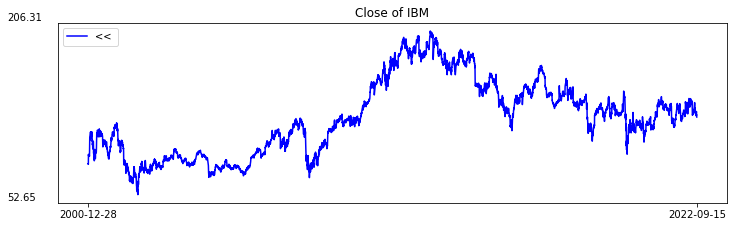

In [ ]:
# Example # 1.

df=dict_df['IBM'].copy()
c=df['close']
print(c)
draw(c,title="Close of IBM")

522      74.091782
523      77.026772
524      78.059273
525      79.913956
526      82.217972
           ...    
3127    183.508606
3128    184.235184
3129    181.481842
3130    183.126190
3131    183.126190
Name: close, Length: 2610, dtype: float64


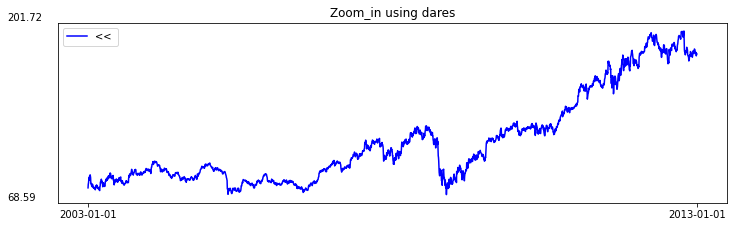

2000    116.376671
2001    113.202675
2002    113.135757
2003    109.942642
2004    109.302101
           ...    
3127    183.508606
3128    184.235184
3129    181.481842
3130    183.126190
3131    183.126190
Name: close, Length: 1132, dtype: float64


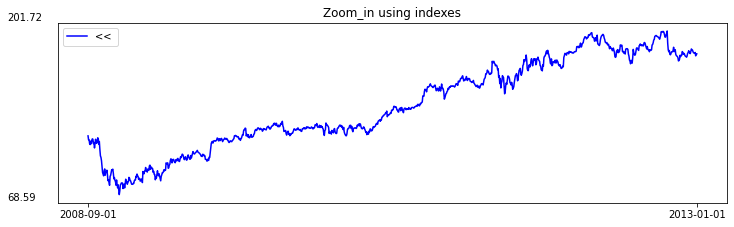

In [ ]:
# Example # 2.  zoom_in

# a) using dates:

df=zoom_in(df,left='2003-1-1',right='2013-1-1')
c=df['close']
print(c)
draw(c,title="Zoom_in using dares")

# a) using indexes:

df=zoom_in(df,left=2000)
c=df['close']
print(c)
draw(c,title="Zoom_in using indexes")

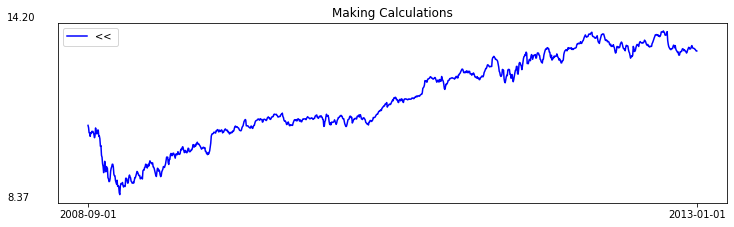

In [ ]:
# # Example # 3. Using algebraic functions for series calculations: 

h=df['high']
l=df['low']
ser=np.sqrt((h+l)/2)###############################################

draw(ser,title="Making Calculations")

## Draw Chart
The basic series and predefined functions of these series are just regular Pandas series and can be plotted by a standard way. <br>Function <br><br>draw()<br><br> which we have used above, is just a combination of several such functions. Use function draw(), if you are OK with predefine settings. This function is created for using in trading systems, see section TRADING SYSTEMS. If function draw() does not work in your situation, or you need more control on how and were to put the series on the chart, use function <br><br>draw_chart()<br><br> as it is done below. Default value for pane is 1 (the top pane); default value for y is left; all named arguments are optional. In further sections, you will see examples on how to use draw() and draw_chart(). Formal description is omitted.

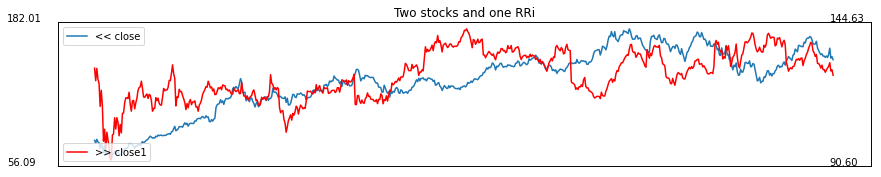

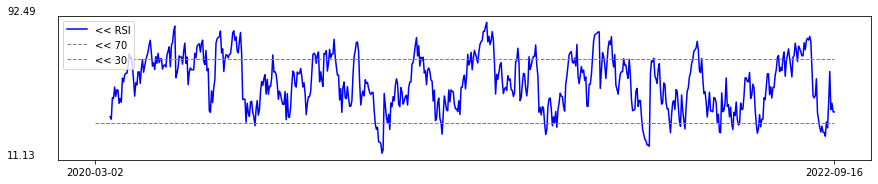

In [ ]:
df=zoom_in(dict_df['AAPL'],left=5000)
df1=zoom_in(dict_df['IBM'],left=5000)

c=df['close']
c1=df1['close']
RSI=rsi(c,14)

lines=[[c,    "label=close"],
       [c1,   "label=close1,  y=right,   color=r"],
       [RSI,  "label=RSI,     pane=2,    color=b"],
       [70,   "label=70,      pane=2,    color=grey,   linestyle=dashed, linewidth=1"],
       [30,   "label=30,      pane=2,    color=grey,   linestyle=dashed, linewidth=1"]]


draw_chart(lines, title="Two stocks and one RRi", paneswidth=12, paneshights=[2,2]) ##############################

If you need interactive GUI (zooming, tracing, etc.), you can save the series on your computer as csv files and open them as tables at https://www.algorain.com/.

# BASIC SERIES

## True High/True Low
True high is current day(row) high or previous day(row) close, whichever is greater<br> True low is similar<br>True Range is the distance between True High and True Low: TRange = TrueH – TrueL.

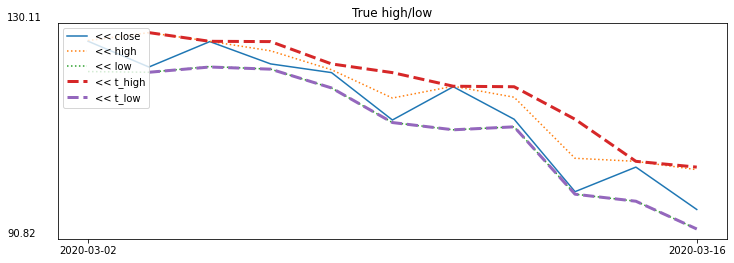

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000,right=5010)
c=df['close']
h=df['high']
l=df['low']
th=true_high(h,c) ###########################################
tl=true_low(l,c)  ###########################################

lines=[[c, 'label=close'],
       [h, 'label=high,   linestyle=dotted'],
       [l, 'label=low,    linestyle=dotted'],
       [th,'label=t_high, linewidth=3,      linestyle=dashed'],
       [tl,'label=t_low,  linewidth=3,      linestyle=dashed']]

draw_chart(lines,title="True high/low")

## Buying/Selling pressure
Buying Pressure is the distance between c and True Low: c - TrueL.<br> Selling Pressure is the distance between True High and c: TrueH – c.

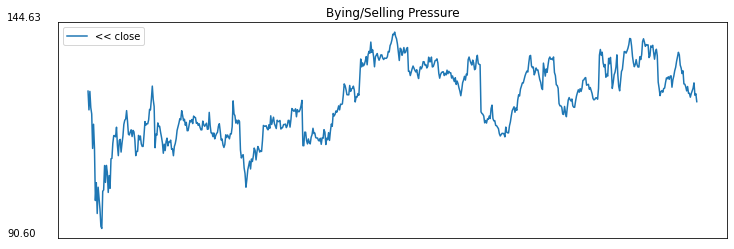

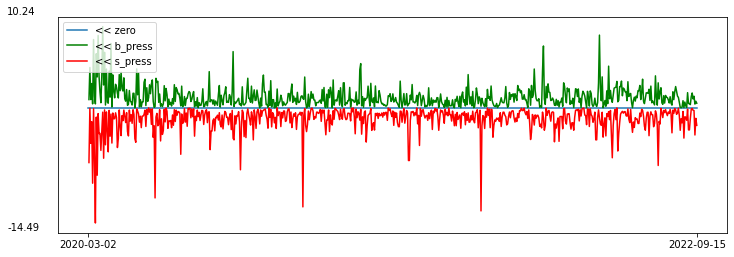

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
h=df['high']
l=df['low']
th=true_high(h,c)
tl=true_low(l,c)
bp=c-tl ################################################
sp=th-c ################################################
z=0

lines=[[c,  'label=close'],
       [0,  'label=zero,pane=2'],
       [bp, 'label=b_press,  pane=2,  color=g'],
       [-sp,'label=s_press,  pane=2,  color=r']]

draw_chart(lines,title="Bying/Selling Pressure")

## Positive/Negative Directional Movement
Positive Directional Movement (Pos) and Negative Directional Movement (Neg) are the time series calculated by comparison of a current True Range (the right vertical segment in one of the figures below) with the previous day’s True Range (the left segment of the same figure) in accordance with the following cases:
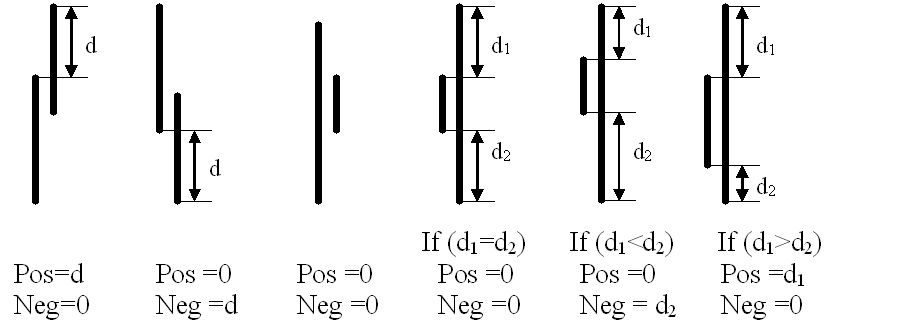 

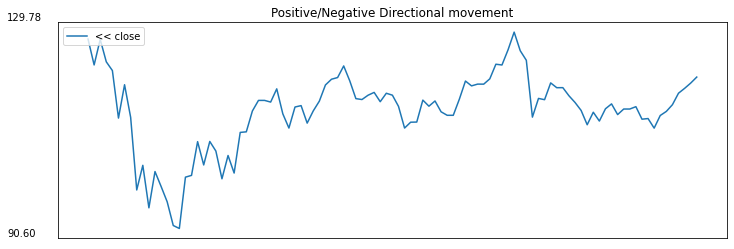

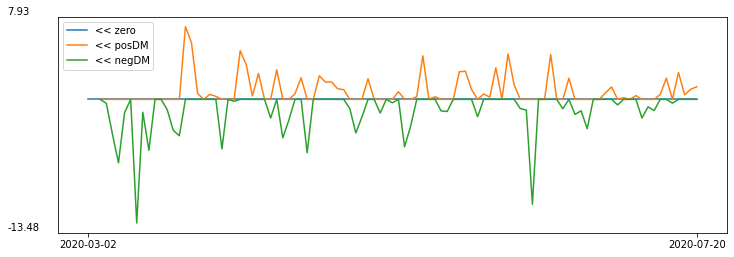

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000,right=5100)
c=df['close']
h=df['high']
l=df['low']
th=true_high(h,c)
tl=true_low(l,c)
pos,neg=pos_negDM(h,l,c)##############################
z=0

lines=[[c,  'label=close'],
       [0,  'label=zero,pane=2'],
       [pos, 'label=posDM,  pane=2'],
       [-neg,'label=negDM,  pane=2']]

draw_chart(lines,title="Positive/Negative Directional movement")

## Integral
See example of function acc(ser), where ser = buying pressure minus selling pressure, and result is a cumulative sun of this series.

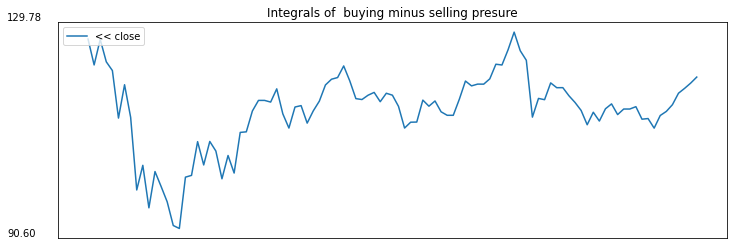

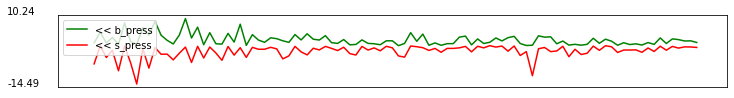

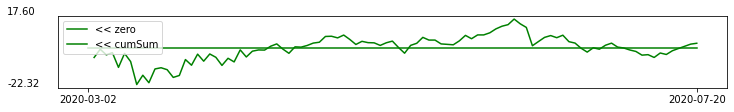

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000,right=5100)
c=df['close']
h=df['high']
l=df['low']
bp=c-true_low(l,c)
sp=true_high(h,c)-c
cumSum=acc(bp-sp)##############################################


lines=[[c,       'label=close'],
       [bp,      'label=b_press,  pane=2,  color=g'],
       [-sp,     'label=s_press,  pane=2,  color=r'],
       [0,       'label=zero,     pane=3,  color=g'],
       [cumSum,'label=cumSum,  pane=3,  color=g']]

draw_chart(lines,paneshights=[3,1,1,3],title="Integrals of  buying minus selling presure")

## Simple Moving Average
To calculate sma(c, 20), take the first 20 close price points (#0, 1, 2, …, 19), add them up, and divide by 20. It gives the first (the very left) point of the SMA. Then take points # 1, 2, 3… 19, 20, add them up, and divide by 20. It gives the second point of the SMA. And so on. This SMA starts from the 20th price point and ends at the last point. 
<br>To calculate average of series c on the entire time interval, use sma(c,0).

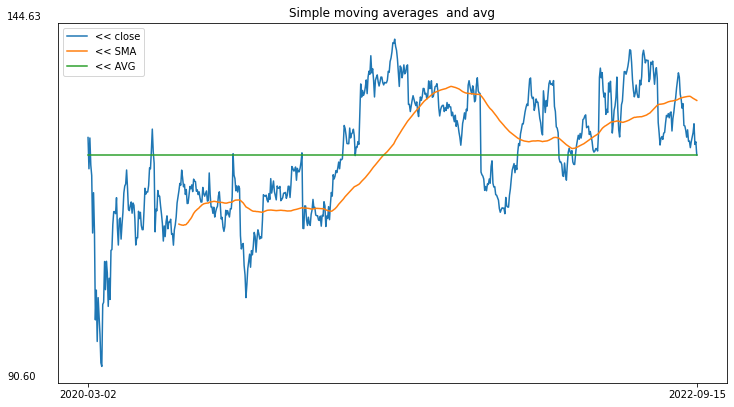

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
SMA=sma(c,100) ###################################
AVG=sma(c,0) #######################################


lines=[[c,  'label=close'],
       [SMA,'label=SMA'],
       [AVG,'label=AVG']]

draw_pane(lines,title="Simple moving averages  and avg")

## Exponencial Moving Avarage
function EMA=ema(c,n) for n=20 is defined as <br><br>EMA0 = c0
	<br>EMA1 = (2/21)*c1 + (19/21)*EMA0
	<br>EMA2 = (2/21)*c2 + (19/21)*EMA1
	<br>EMA3 = (2/21)*c3 + (19/21)*EMA2
<br><br>And so on. The coefficients used in the calculations are equal to 2/(n+1) and (n-1)/(n+1).
An EMA always starts (and coincides) with the first point of an input. 

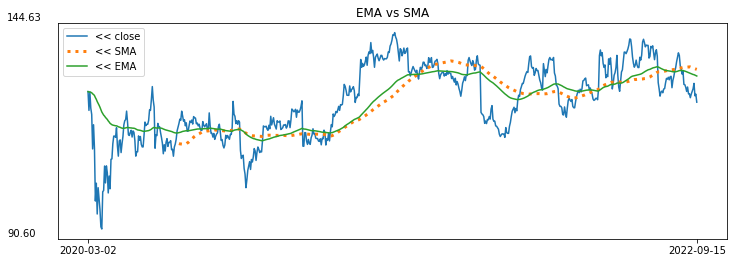

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
SMA=sma(c,100)
EMA=ema(c,100)###############################


lines=[[c,  'label=close'],
       [SMA,'label=SMA, linestyle=dotted,linewidth=3'],
       [EMA,'label=EMA'],]

draw_chart(lines,title="EMA vs SMA")

## Modifired Moving Avrrage
Modifired Moving Avrrage MMA=mma(c,20) is a combimation of SMA and EMA: 
In the example, the first point of the MMA – MMA19 coincides with the first point of the SMA – SMA19 (see the chart below). The next points are calculated on the base of the following recurrent relation:<br><br>
	MMA19 = SMA19<br>
	MMA20 = (c20 + 19*MMA19)/20<br>
	MMA21 = (c21 + 19*MMA20)/20<br>
	MMA22 = (c22 + 19*MMA21)/20<br><br>
	And so on.



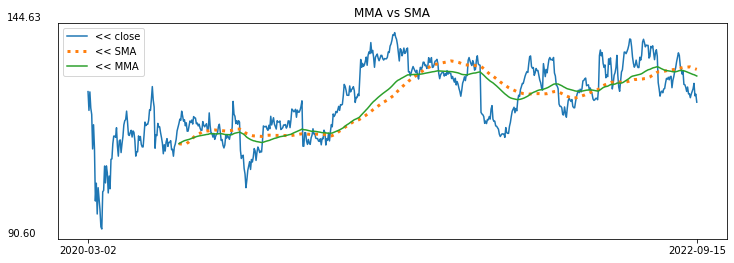

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
SMA=sma(c,100)
MMA=mma(c,100)###############################


lines=[[c,    'label=close'],
       [SMA,'label=SMA, linewidth=3, linestyle=dotted'],
       [MMA,'label=MMA']]

draw_chart(lines,title="MMA vs SMA")

## Moving Standard Deviation
Use std(c,n) - for rolling n points; std(c,0) - for the entire time series c.

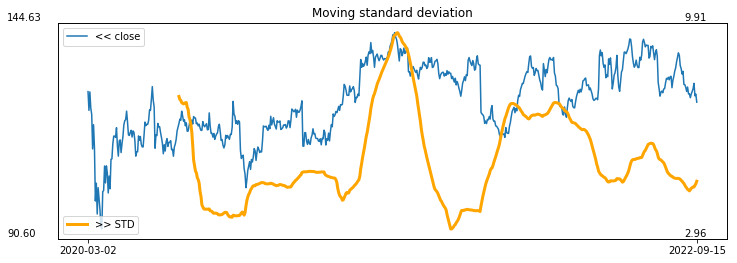

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
STD=std(c,100)###############################

lines=[[c, 'label=close'],
       [STD,'label=STD, linewidth=3,  y=right, color=orange']]

draw_chart(lines,title="Moving standard deviation")

## Moving Max/Min and Same 
Use mmax(c,n) and mmin(c,n) - for rolling n points; mmax(c,0) and mmin(c,0) - for the entire time series c.

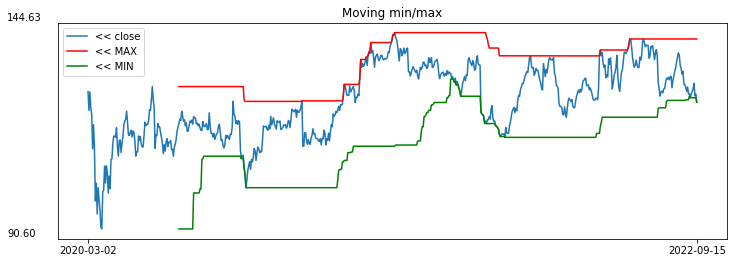

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
MAX=mmax(c,100) ##############################
MIN=mmin(c,100)###############################

lines=[[c,  'label=close'],
       [MAX,'label=MAX,  color=r'],
       [MIN,'label=MIN,  color=g'],]

draw_chart(lines,title="Moving min/max")

Function same(ser) starts from zero. If a current value of series ser is the same as the previous one, the value of the function same increases by 1.  If not, the value of the function drops to zero.

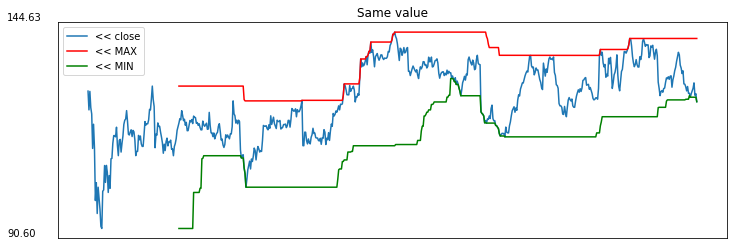

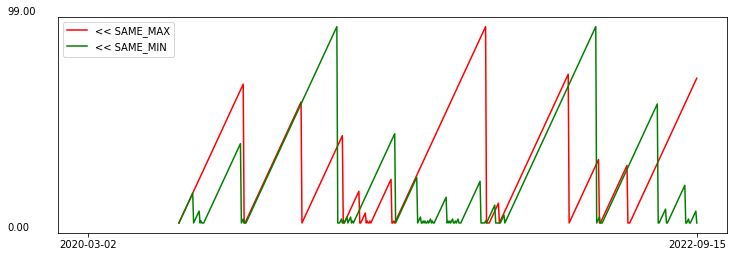

In [ ]:
SAME_MAX=same(MAX)
SAME_MIN=same(MIN)

lines=[[c,      'label=close'],
       [MAX,     'label=MAX,       color=r'],
       [MIN,     'label=MIN,       color=g'],
       [SAME_MAX, 'label=SAME_MAX, pane=2, color=r'], ########################################
       [SAME_MIN, 'label=SAME_MIN, pane=2, color=g']] ########################################

draw_chart(lines,title="Same value")

##Simple Moving Correlation

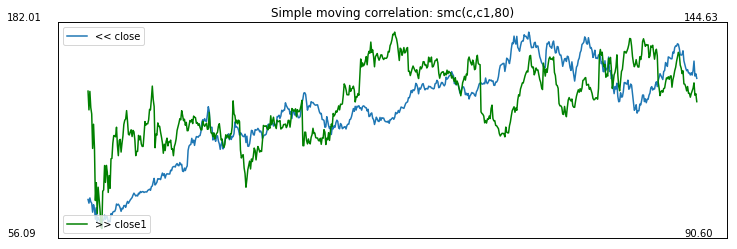

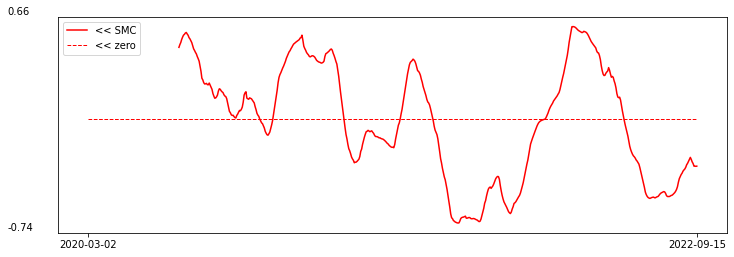

In [ ]:
df=zoom_in(dict_df['AAPL'],left=5000)
c=df['close']
df1=zoom_in(dict_df['IBM'],left=5000)
c1=df1['close']
SMC=smc(c,c1,100)####################################
zero=0


lines=[[c, 'label=close'],
       [c1, 'label=close1, y=right,color=g'],
       [SMC, 'label=SMC,pane=2, color=r'],
       [zero, 'label=zero,pane=2, linewidth=1,color=r,linestyle=dashed']]

draw_chart(lines,title="Simple moving correlation: smc(c,c1,80)")

## First, Last, First_Last, and Relative Procent Change
Relative Procent Change is calculated in respect to the first price in a series: <br><br>RPC=100*(c-FIRST)/FIRST

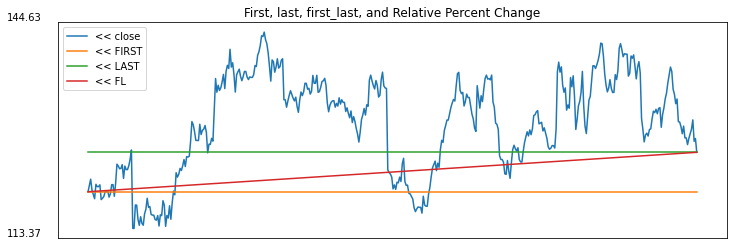

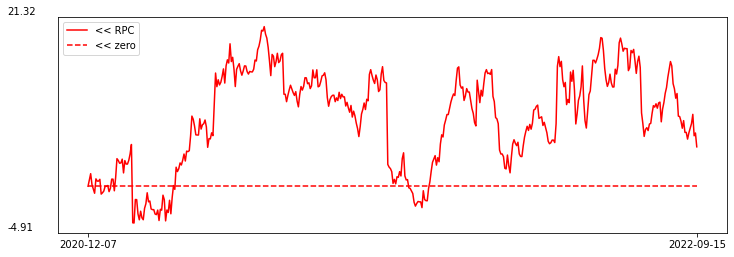

In [ ]:
df=zoom_in(dict_df['IBM'],left=5200)
c=df['close']
FIRST=first(c)
LAST=last(c)
FL=first_last(c)
#RPC=100*(c-FIRST)/FIRST
RPC=rpc(c)
zero=0

lines=[[c, 'label=close'],
       [FIRST,'label=FIRST'], #######################################
       [LAST,'label=LAST'],########################################
       [FL,'label=FL'],
       [RPC, 'label=RPC, pane=2, color=r'],
       [zero,'label=zero,pane=2, color=r,linestyle=dashed']] ####################################

draw_chart(lines,title="First, last, first_last, and Relative Percent Change")

## Shift
A graph can be shifted even to the dates out of the time interval of the loaded data.<br>


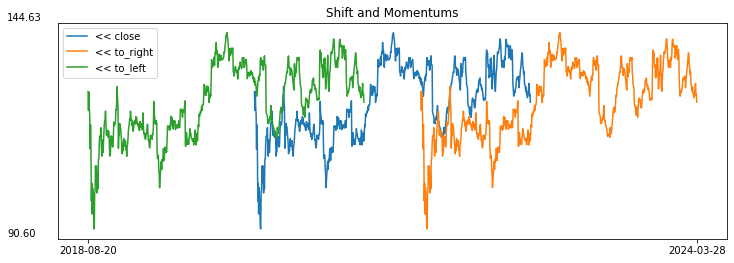

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
to_right=shift(c,400) ##################################
to_left=shift(c,-400) ##################################
z=0



lines=[[c,        'label=close'],
       [to_right, 'label=to_right'],
       [to_left,  'label=to_left']]

draw_chart(lines,title="Shift and Momentums")

##Part

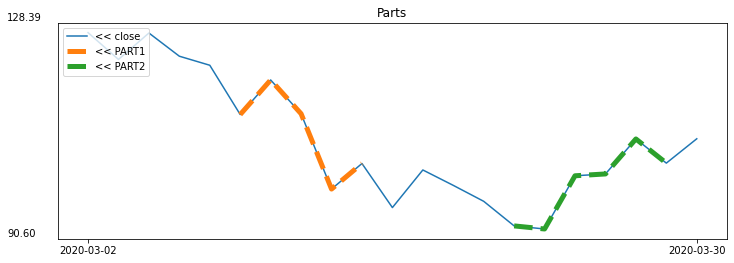

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000,right=5020)
c=df['close']
PART1=part(c,5005,5009) ##################
PART2=part(c,'2020-3-20','2020-3-27') ##################

lines=[[c, 'label=close'],
       [PART1, 'label=PART1, linewidth=5, linestyle=dashed'],
       [PART2, 'label=PART2, linewidth=5, linestyle=dashed']]      

draw_chart(lines,title="Parts")

## Compare
Function compare(ser1,ser2,gt,eq,ls) returns:<br>series gt - in the points where ser1 > ser2<br> series eq - in the points where ser1==ser2,<br>series ls - in the  points where ser1 < ser2.
<br>For example, compare(FAST,SLOW,2*c,c,c/2) shows 
- 2*c when series FAST > serues SLOW
- c when series FAST = serues SLOW
- c/2 when series FAST < serues SLOW

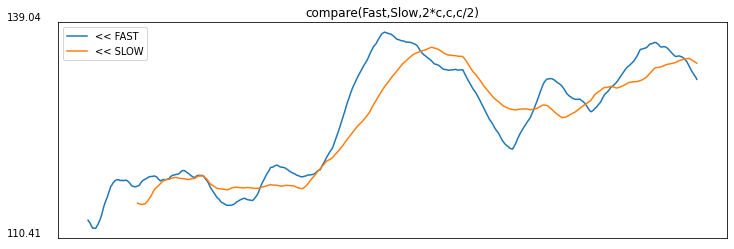

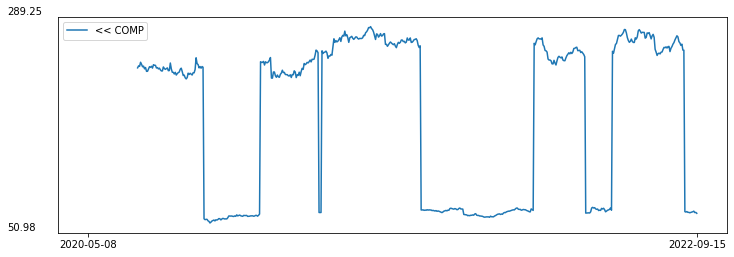

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
FAST=sma(c,50)
SLOW=sma(c,100)
COMP=compare(FAST,SLOW,2*c,c,c/2) ####################################

lines=[[FAST, 'label=FAST'],
       [SLOW, 'label=SLOW'],
       [COMP, 'label=COMP,pane=2']]

draw_chart(lines,title="compare(Fast,Slow,2*c,c,c/2)")

## Linear/Cubic Trend/Projection
Use lTrend(c) and cTrend(c) for trend on entire interval.
<br>Use lTrend(c,m,n) and cTrend(c,m,n) - for projection of n future points based on m last points.

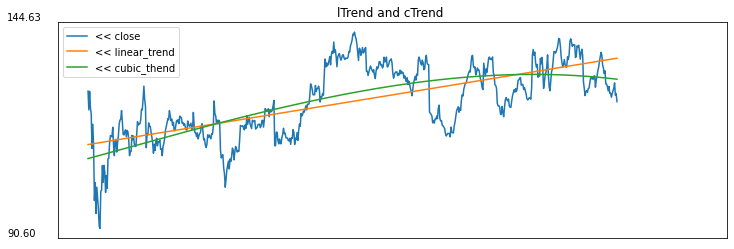

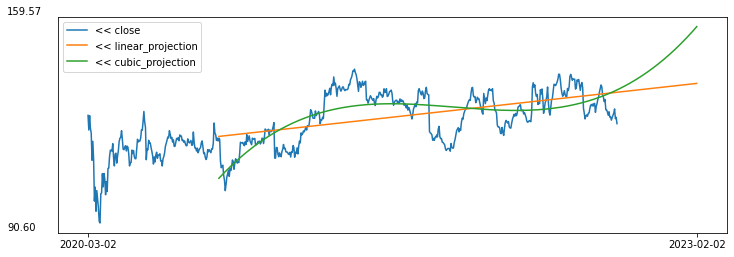

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
linT=lTrend(c) #################################################
cubT=cTrend(c) #################################################
linP=lTrend(c,last=500,next=100) ###############################
cubP=cTrend(c,last=500,next=100) ###############################

lines=[[c, "label=close"],
       [linT,'label=linear_trend'],
       [cubT,'label=cubic_thend'],
       [c, "label=close, pane=2"],
       [linP,'label=linear_projection,pane=2'],
       [cubP,'label=cubic_projection, pane=2']]

draw_chart(lines,title="lTrend and cTrend ")


## Fast Fourier Smoothed/Derivative
ffs(c, 10) removes all harmonics starting from 10th.
<br>ffd(c, 10) is proportional to an an analytical derivative of ffs(c, 10).
<br>Gibbs Phenomena is mitigated.

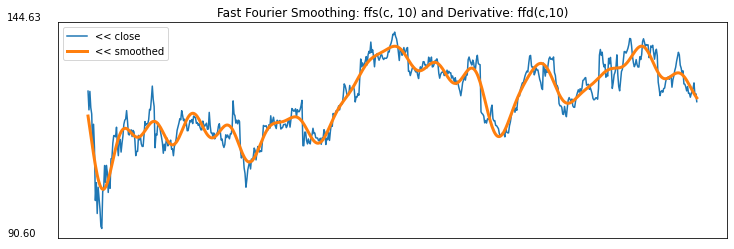

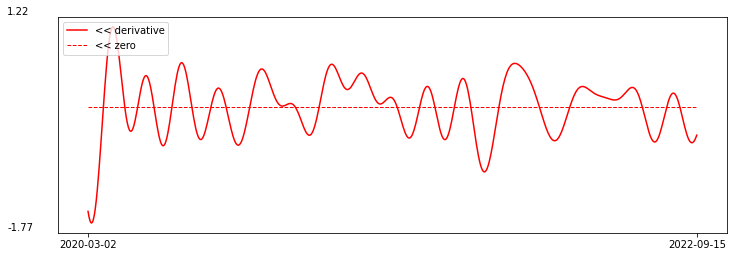

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
n=30
smooth=ffs(c, n)####################################
der=ffd(c, n)####################################
zero=0


lines=[[c, 'label=close'],
       [smooth, 'label=smoothed, linewidth=3'],
       [der, 'label=derivative,pane=2, color=r'],
       [zero, 'label=zero,pane=2, linewidth=1,color=r, linestyle=dashed']]

draw_chart(lines,title="Fast Fourier Smoothing: ffs(c, 10) and Derivative: ffd(c,10)")

## Moving Fast Fourier Smoothing/Derivative

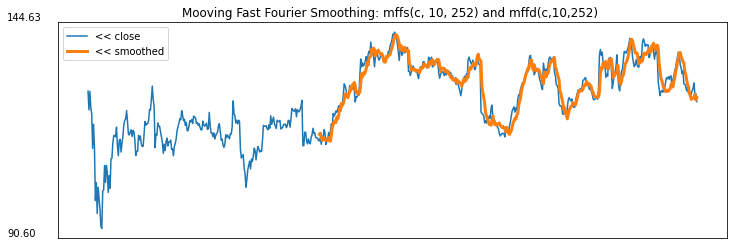

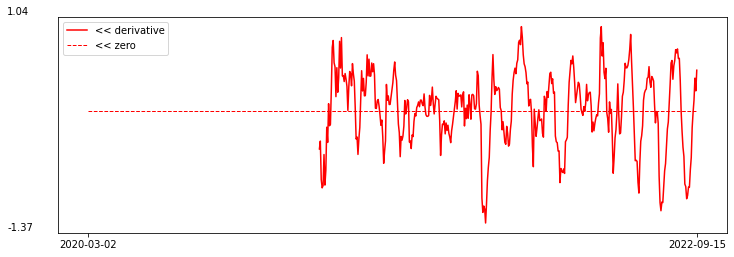

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
smooth=mffs(c, 10, 252)####################################
der=mffd(c, 10,252)####################################
zero=0


lines=[ [c, 'label=close'],
        [smooth, 'label=smoothed, linewidth=3'],
        [der, 'label=derivative,pane=2, color=r'],
        [zero, 'label=zero,pane=2, linewidth=1,color=r, linestyle=dashed']
       ]

draw_chart(lines,title="Mooving Fast Fourier Smoothing: mffs(c, 10, 252) and mffd(c,10,252) ")

# INDICATORS
The main purpose of financial indicators is to find points of selling and buying.<br>DISCLAIMER: buy and sell rules below are not recomendations; it is just what traders often do.


##Two Moving Avarages
Buy when FAST sma becomes greater than SLOW.<br>
Sell when SLOW becomes greater than FAST

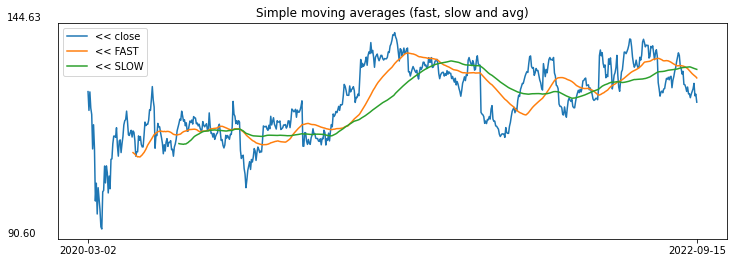

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
FAST=sma(c,50)###################################
SlOW=sma(c,250)##################################

lines=[[c,   'label=close'],
       [FAST,'label=FAST'],
       [SLOW,'label=SLOW']]

draw_chart(lines,title="Simple moving averages (fast, slow and avg)")


## MACD: Moving Average Convergence/Divergence

Moving Average Convergence / Divergence (MACD) is the difference between the two exponential moving averages:<br><br>	MACD = ema(c, 12) – ema(c, 26)<br>SIGNAL = ema(MACD, 9)<br><br>Buy when MACD becomes greater than SIGNAL; sell when SIGNAL becomes grater than MACD. 


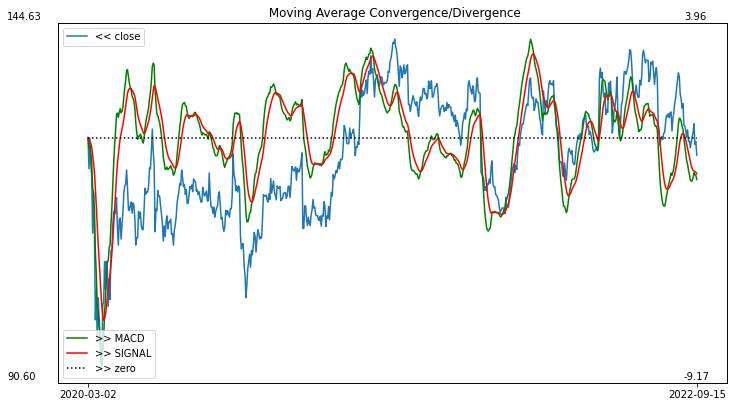

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
MACD=ema(c,12)-ema(c,26) ###################################
SIGNAL = ema(MACD, 9)##################################

lines=[[c,      'label=close'],
       [MACD,   'label=MACD,  y=right,  color=g'],
       [SIGNAL, 'label=SIGNAL,y=right,  color=r'],
       [0,      'label=zero,  y=right, color=black, linestyle=dotted']]

draw_pane(lines,title=" Moving Average Convergence/Divergence")

## Integrated Directional Movement
Buy when Integrated Directional Movement SUM_DM becomes positive.

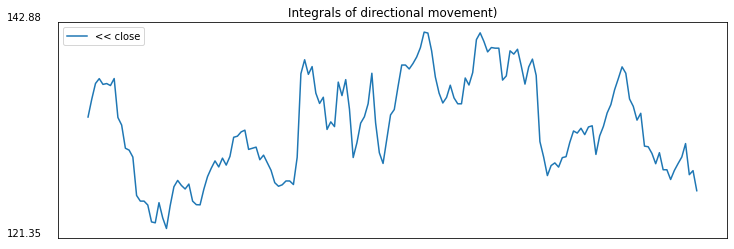

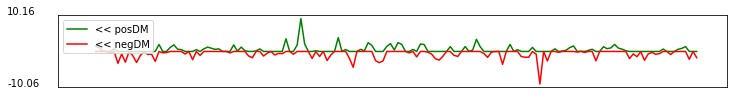

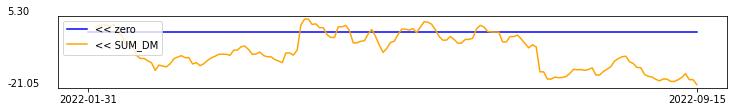

In [ ]:
df=zoom_in(dict_df['IBM'],left=5500)
c=df['close']
h=df['high']
l=df['low']
pos,neg=pos_negDM(h,l,c)
SUM_DM=acc(pos-neg)##############################################

lines=[[c,       'label=close'],
       [pos,     'label=posDM,    pane=2,   color=g'],
       [-neg,    'label=negDM,    pane=2,   color=r'],
       [0,       'label=zero,     pane=3,   color=b'],
       [SUM_DM,  'label=SUM_DM,    pane=3,   color=orange']]

draw_chart(lines,paneshights=[3,1,1,3],title="Integrals of directional movement)")

## Bollinger Bands
Indicator Bollinger Bands consist of upper (Band1) and lower (Band2) bans, calculated as follows:<br><br>
Band1 = sma(c,n)+d\*std(c,n), <br>Band2 = sma(c,n)-d\*std(c,n),<br><br> see below. <br>
Buy when close crosses the lower band, sell when close crosses the upper band

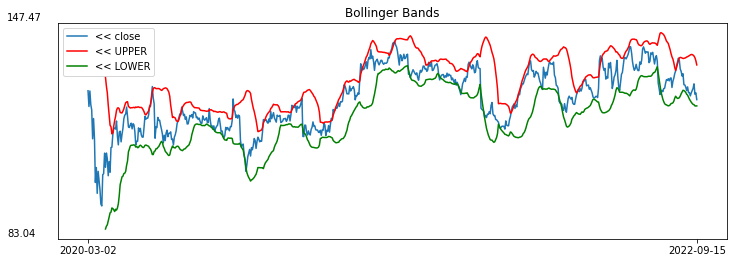

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
n=20
d=2
Band1=sma(c,n)+d*std(c,n) ##################################
Band2=sma(c,n)-d*std(c,n) ##################################

lines=[[c, 'label=close'],
       [Band1,'label=UPPER, color=red'],
       [Band2,'label=LOWER, color=g'],]

draw_chart(lines,title="Bollinger Bands")

##ATR (Average True Range) Bands
Average True Range Bands consist of the  UPPER and LOWER bans, calculated as follows:<br><br>
		TH = true_high(h,c)<br>
		TL = true_low(l, c)<br>
		D = 2*(TH – TL)<br>
		UPPER = sma(low + D,5)<br>
		LOWER = sma(h –D,5)<br><br>
	Unlike Bollinger Bands, not only close prices but also high and low prices are used as the arguments in the formulas. 


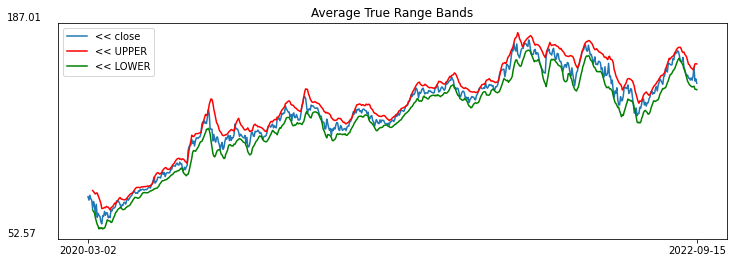

In [ ]:
O,H,L,C,V=make_series(watch_list,start=5000)

i=0
n=5
c=C[i]
h=H[i]
l=L[i]
TH = true_high(h,c)
TL = true_low(l, c)
D = 2*(TH - TL)
UPPER = sma(l + D, 5)
LOWER = sma(h - D, 5)

lines=[[c, 'label=close'],
       [UPPER,'label=UPPER, color=red'],
       [LOWER,'label=LOWER, color=g'],]

draw_chart(lines,title="Average True Range Bands")

## Stochastic Oscillator
Stochastic Oscillator is given by two lines: K and D.<br>
The formula for the first line is: <br><br>K = stoch(c, h, low, 14, 3)<br><br> which is equivalent to the following chain of formulas:<br><br>

LL = sma(mmin(low, 14), 3)<br>
HH = sma(mmax(h, 14), 3)<br>
K=100*(sma(c, 3) - LL) / (HH - LL)<br><br>

In this chain, LL is the smoothed lowest low and HH is the smoothed highest high during the moving (rolling) 14-day period.If there is no smoothing (last argument is 1, not 3), the oscillator is called fast; otherwise - slow.
	The second line of the stochastic oscillator is <br>D = ema(K, 3)<br>  
	Buy/sell signals are recommended in the points of intersection of K and D.


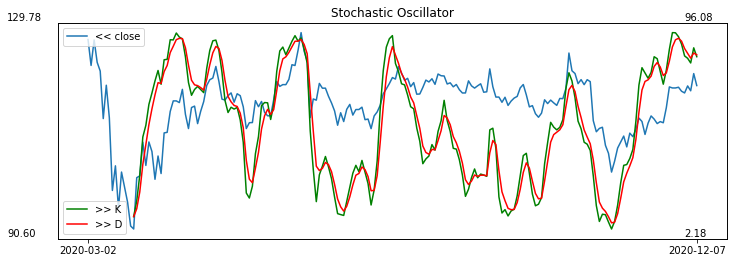

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000,right=5200)
c=df['close']
h=df['high']
l=df['low']
K=stoch(c,h,l,14,3) ####################################
D=ema(K,3) #############################################)

lines=[[c, 'label=close'],
       [K, 'label=K,      y=right, color=g'],
       [D, 'label=D,      y=right, color=r']]

draw_chart(lines,title="Stochastic Oscillator")

## Wilder Volatility Index
WVI = sma(th - tl, n)=wvi(h,l,c,n)
<br> High volatility usually points out when to buy ot to sell.

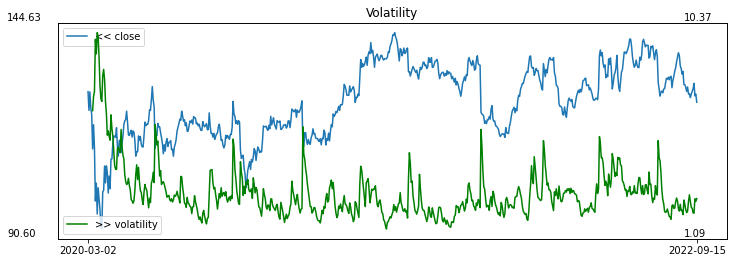

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
h=df['high']
l=df['low']
n=14
WVI = wvi(h,l,c,n) ##############################

lines=[[c,  'label=close'],
       [WVI, 'label=volatility,  y=right, color=g']]

draw_chart(lines,title="Volatility")

## Relative Strength Index

The idea of Relative Strength Index (RSI) is to compare the movement of the price up during a period of time (14 days in this example) and the movement down during the same period.<br>
	The formula RSI=rsi(c, 14) is equivalent to the following chain of formulas:<br><br>D = c – shift(c,1)<br>
		Up = compare (D, 0, D, 0, 0)<br>
		Down = compare (D, 0 0, 0, -D)<br>
		UpS = mma(Up, 14)<br>
		DownS = mma(Down, 14)<br>
    Sum = UpS + DownS <br>
    RSI = compare(Sum, 0, 100 * UpS/Sum, 50, 100 * UpS / Sum)<br><br>As a result, RSI oscillates between 0% and 100%.<br> 	
Sell when RSI is above some level, e.g., 70% and buy when RSI is bellow some level, e.g., 30%.


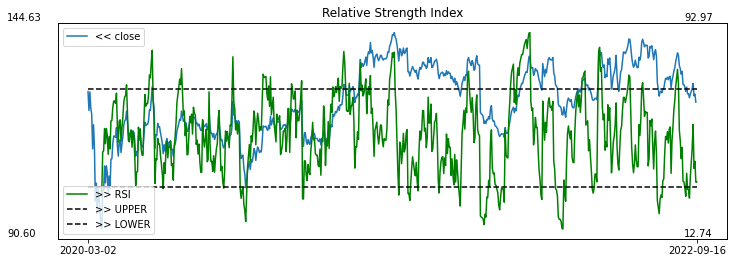

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
RSI = rsi(c, 14)##############################

lines=[[c,  'label=close'],
       [RSI,'label=RSI,  y=right, color=g'],
       [70, 'label=UPPER, y=right, linestyle=dashed, color=black'],
       [30, 'label=LOWER, y=right, linestyle=dashed, color=black']]

draw_chart(lines,title="Relative Strength Index")

##Relative Relative Strength Index (RRSI)
RRSI is the same as RSI, but instead of c=close, we ude ratio=c/c1, where c1 is close of Dow Industrial Index.


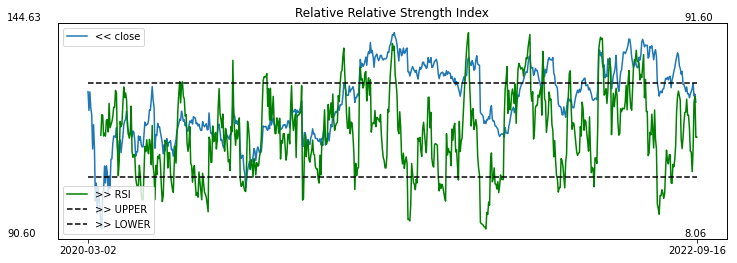

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
df1=df=zoom_in(dict_df['^DJI'],left=5000)
c1=df1['close']
RSI = rsi(c/c1, 14)##############################

lines=[[c,  'label=close'],
       [RSI,'label=RSI,  y=right, color=g'],
       [70, 'label=UPPER, y=right, linestyle=dashed, color=black'],
       [30, 'label=LOWER, y=right, linestyle=dashed, color=black']]

draw_chart(lines,title="Relative Relative Strength Index")

##Money Flow Index
Money Flow Index (MFI) is a modification of Relative Strength Index (RSI). The algorithm for calculations of MFI is the same as for RSI with the exception of two points:<br>
	1. The MFI algorithm uses the mean price M to determine if the direction of the price of a stock during a day, where M = (c + h + low + open)/4 (as opposed to just c in the RSI algorithm).<br> 
	2. The MFI formulas for the variables Up and Down include the increment/decrement of (volume\*M) instead of the increment/decrement of c in the RSI formulas. <br>
	As a result, the formula MFI = mfi(o, h, l, c, v, 14, ma) is equivalent to the chain of formulas (if ma='mma'):<br>	 
		M = (o + h + l + c)/4<br>
		D = M – shift(M,1)<br>
		Up = compare(D,0,v\*M,0,0)<br>
		Down = compare(D,0,0,0,-v\*M)<br>
		UpS = mma(Up, 14)<br>
		DownS = mma(Down, 14)<br>
    Sum = Ups + DownS<br>
    MFI = compare(Sum,0,100\*Ups/Sum,50,100\*Ups/Sum)<br><br>
If ma=='sma', we use sma instead of mma, if ma==ema, we use ema.
  


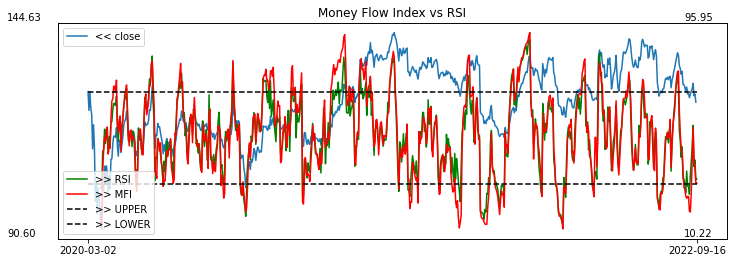

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
h=df['high']
l=df['low']
o=df['open']
v=df['volume']
RSI = rsi(c, 14)
MFI=mfi(o,h,l,c,v,14,'mma')##############################

lines=[[c,  'label=close'],
       [RSI,'label=RSI,   y=right, color=g'],
       [MFI,'label=MFI,   y=right, color=r'],
       [70, 'label=UPPER, y=right, linestyle=dashed, color=black'],
       [30, 'label=LOWER, y=right, linestyle=dashed, color=black']]

draw_chart(lines,title="Money Flow Index vs RSI")

##Chande Trend Index
Chande Trend Index cti(c, 21) is equivalent to the following chain of formulas:<br><br>
		LN = np.log(c/shift(c, 21))<br>
		L1 = np.log(c/shift(c, 1))<br>
		StD = std(L1, 21)*np.sqrt(21)<br>
		CTI = LN/StD<br><br>
Chande Trend Index is usually oscillating between 3 and -3.<br>
Buy when CTI becomes greater than -2, sell - when it becomes less than 2.


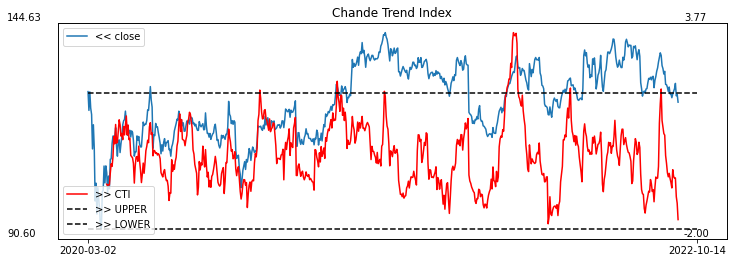

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
CTI = cti(c, 21)##############################

lines=[[c,  'label=close'],
       [CTI,'label=CTI,   y=right, color=r'],
       [2, 'label=UPPER,  y=right, linestyle=dashed, color=black'],
       [-2, 'label=LOWER,  y=right, linestyle=dashed, color=black']]

draw_chart(lines,title="Chande Trend Index")

##On Balance Volume
If a current day’s close price c is greater than the previous day’s close price, OBV increases by the current day’s volume; if less, OBV decreases by the current day’s volume; if equal, OBV stays the same.<br>
The formula for OBV is:<br><br> 
D=c-shift(c,1)<br>
OBV= integtal(compare(D,0,v,0,-v))<br><br>
	It is usually recommended to sell a stock when OBV turns positive and to buy the stock when OBV turns negative.

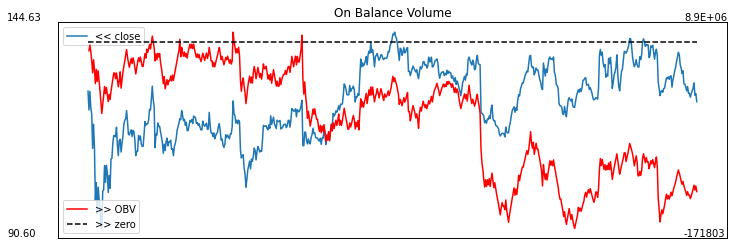

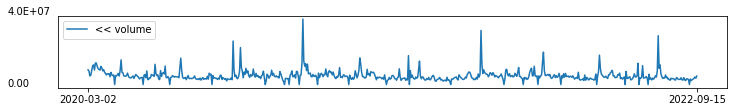

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
v=df['volume']

OBV = obv(c, v)##############################


lines=[[c,  'label=close'],
       [v,  'label=volume, pane=2'],
       [OBV,'label=OBV,   y=right, color=r'],
       [0, 'label=zero,  y=right, linestyle=dashed, color=black']]

draw_chart(lines,paneshights=[3,1],title="On Balance Volume")

##Momenums
Momentum Difference - momD(c, 20) is equivalent to <br>c - shift(c, 20)<br>
Momentum Ratio (the same as Relative Percent Change) - momR(c, 20) is equivalent to <br>100*(c/shift(c, 20) - 1)<br>
Buy when momentum turns positive, sell - when it turns negative

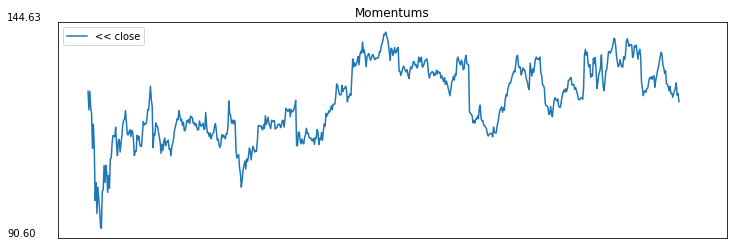

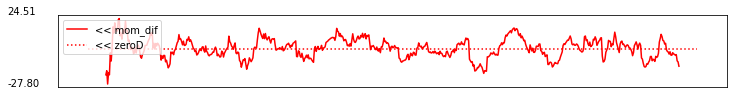

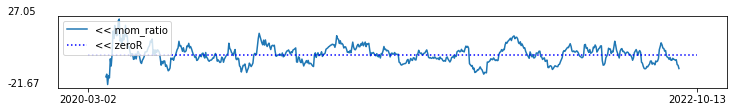

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
mD=momD(c,20)###########################################
mR=momR(c,20) #######################################

lines=[[c,        'label=close'],
       [mD,       'label=mom_dif,   pane=2,  color=r'],
       [0,        'label=zeroD,     pane=2,  linestyle=dotted, color=r'],
       [mR,       'label=mom_ratio, pane=3'],
       [0,        'label=zeroR,     pane=3,   linestyle=dotted, color=b']]

draw_chart(lines,paneshights=[3,1,1],title="Momentums")

## Directional Indexes
Positive/Negative Directional Indexes PDI/NDI are defined as:<br><br>
    pdm,ndm=pos_negDM(h,l,c)<br>
  	PDI = 100\*mma(pdm, 14)/wvi(h,l,c,14)<br>
  	NDI = 100\*mma(ndm, 14)/wvi(h,l,c,14)<br><br>

Advanced Directional Index ADX is defined as follows:<br><br>
  	AD = 100\*np.abs(PDI - NDI)/ (PDI + NDI)<br>
  	ADX = compare(PDI,NDI,mma(AD, 14), 50, mma(AD, 14))<br><br>

The ADX identifies a strong trend when the ADX is over 25 and a weak trend when the ADX is below 20.<br>
Buy when PDI becomes greater than NDI,sell when NDI becomes greater than PDI.<br> 

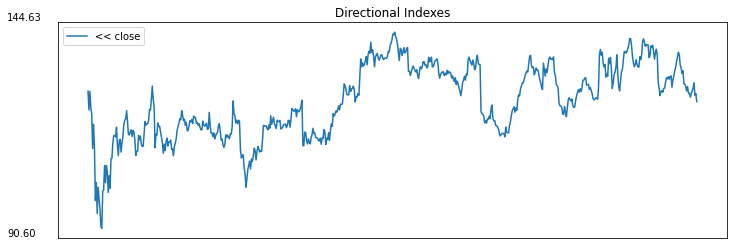

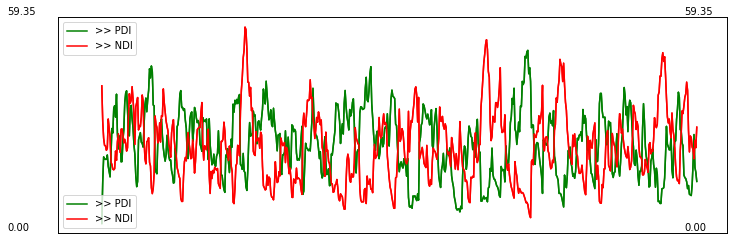

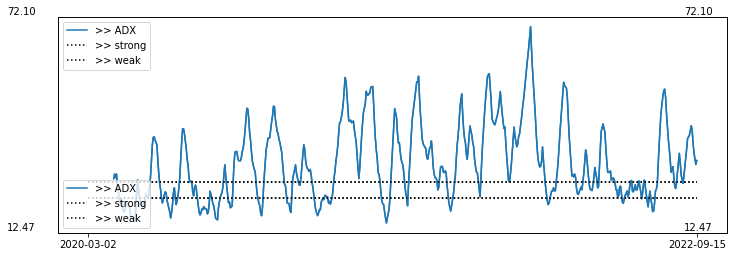

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
h=df['high']
l=df['low']
PDI,NDI,ADX=diri(h,l,c,14)

lines=[[c,        'label=close'],
       [PDI,       'label=PDI,   pane=2, y=right,  color=g'],
       [NDI,       'label=NDI,   pane=2, y=right,  color=r'],
       [ADX,       'label=ADX,   pane=3, y=right'],
       [25,        'label=strong,   pane=3, y=right,   linestyle=dotted, color=black'],
       [20,        'label=weak,   pane=3, y=right,   linestyle=dotted, color=black']]

draw_chart(lines,title="Directional Indexes")

## Parabolic SAR Indicator
The Parabolic SAR line consists of consecutive up and down periods.<br> 
The starting SAR value in the beginning of an up period is equal to the lowest low price of the previous down period. The starting SAR value in the beginning of a down period is equal to the highest high price of the previous up period. 
<br> During an up period, SAR values are calculated as<br> <br> 
SAR[n+1]= SAR[n] + AF[n]\*(HH[n] – SAR[n]),<br> <br> 
where n is the current day, HH[n] is the highest high price from the start of the up period until the current day,and AF[n] is an accelerating factor (in Wilder’s terminology). <br> 
When SAR[n+1] becomes greater than the stock’s low[n+1] price, then the up period stops and the calculated SAR[n+1] is replaced by the highest high price of the up period and a down period starts. 
The starting value of AF[n] in the beginning of an up period or a down period is equal to 0.02, and it increases by 0.02 each day when the stock’s price makes a new high in the up period or a new low in the down period. When AFn reaches the maximum value of 0.2, it stays at that value until the end of that up or down period. 
<br> During a down period, SAR values are calculated as<br> <br> 
SAR[n+1]= SAR[n] + AF[n]*(LL[n] – SAR[n]),<br> <br> 
where LL[n] is the lowest low price from the start of the down period until the current day n;  all the other variables have already been described previously.<br>  When SA[n+1] becomes less than the stock’s high[n+1] price, then the down period stops, the calculated SAR[n+1] is replaced by the lowest low price of the down period, and an up period starts.<br>
Buy and sell when SAR intersects close price.
 


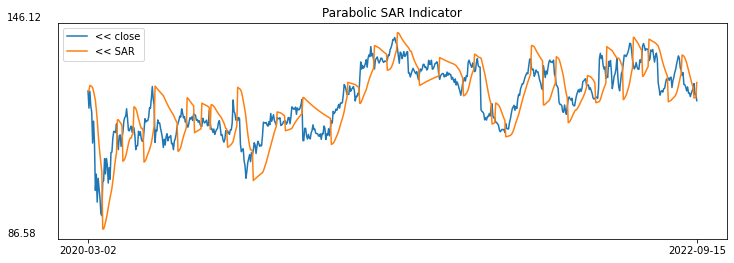

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
h=df['high']
l=df['low']
o=df['open']
v=df['volume']
SAR=prb(c,  h,  l, 0.02, 0.2)##############################

lines=[[c,  'label=close'],
       [SAR,'label=SAR']]

draw_chart(lines,title="Parabolic SAR Indicator")

##Commodity Channel Index
This oscillator proposed by Lambert is equivalent to the following chain of formulas:<br><br>
AP = (h+l+c)/3<br>
ESA = sma(AP,13)<br>
D = sma(np.abs(AP-ESA),13)<br>
CI = (AP-ESA)/(0.015*D)<br>
CCI = sma(CI, 6)<br><br>
Buy when CCI turns positive, sell when it turns negative.


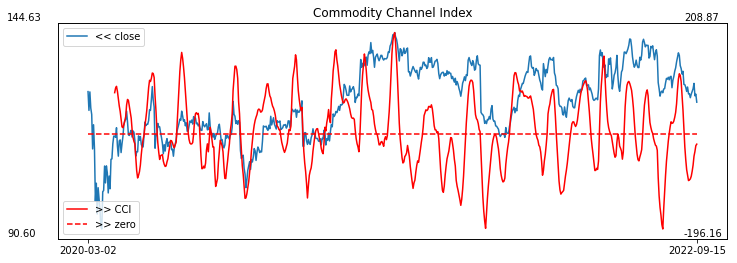

In [ ]:
df=zoom_in(dict_df['IBM'],left=5000)
c=df['close']
h=df['high']
l=df['low']
o=df['open']
v=df['volume']
CCI = cci(h,l,c,13)##############################


lines=[[c,  'label=close'],
       [CCI,'label=CCI,  y=right, color=r'],
       [0, 'label=zero,  y=right, linestyle=dashed, color=r']]

draw_chart(lines,paneshights=[3,1],title="Commodity Channel Index")

#CLASSICAL TRADING SYSTEMS
Trading systems have three components.<br>
1)	Buy/sell alerts. They are based on relationships between fields, on intersections of indicators, and/or other events<br> 
2)	The status strategy (which of the buy/sell alerts to implement). There are at least three strategies.<br>
3)	P&L function <br>

##Break Up / Break Down Alerts
There are only two types of alerts: buy and sell.<br>
A sell alert is calculated by the function<br><br>
Sell=break_up(c,Band1)<br><br>
when the time series c breaks band Band1 in the up direction, i.e., in cases when yesterday’s c is less than Band1 but today’s c is equal to or greater than UPPER. In all other cases, the function breakUp is equal to zero. 
The similar function<br><br>
Buy=break_down(c,LOWER)<br><br>
generates a buy alert when the time series c breaks band Band2 in the down direction. <br>
Note that you can consider breakUp function as generating buy alerts and breakDn function as generating sell alerts; it is up to you.



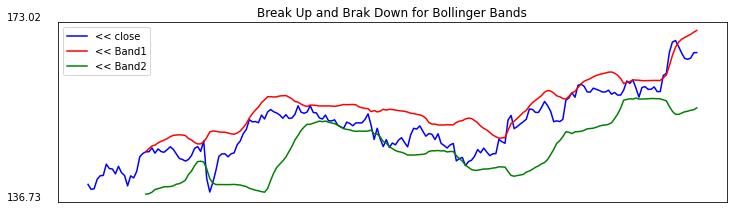

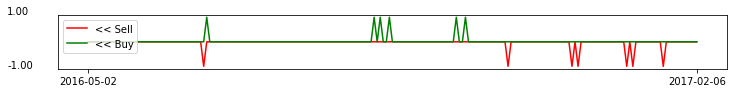

In [ ]:
df=zoom_in(dict_df['IBM'],left=4000,right=4200)
c=df['close']
n=20
d=2
Upper=sma(c,n)+d*std(c,n) 
Lower=sma(c,n)-d*std(c,n) 
Sell=break_up(c,Upper)
Buy=break_down(c,Lower)

draw(c, band1=Upper,band2=Lower,buy=Buy,sell=Sell,title='Break Up and Brak Down for Bollinger Bands')

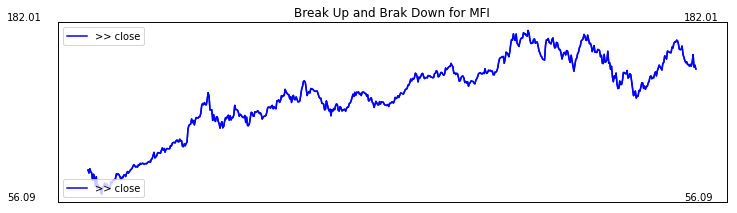

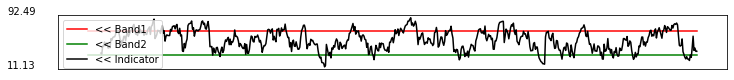

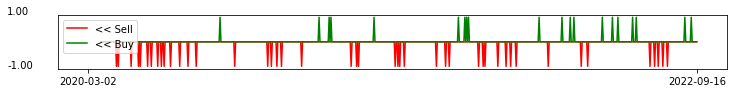

In [ ]:
O,H,L,C,V=make_series(watch_list,start=5000,end=9010)

n=20
d=2
c=C[0]
RSI=rsi(c,14)
Sell=break_up(RSI,70)
Buy=break_down(RSI,30)

draw(c, indicator=RSI,band1=70,band2=30,buy=Buy,sell=Sell,title='Break Up and Brak Down for MFI')

## Other Alerts
Alerts can be based e.g. on relationships between close,open, high, Low, and volume. The alerts in the below example are generated by a function<br><br>Buy,Sell=hlc(h,l,c)<br><br>and suggest buying if today’s close is equal to today’s high and selling if today’s close is equal to today’s low (days when close=high=low, e.g holydays are not considered)
<br>We'll refer to these alerts as "HLC alerts".

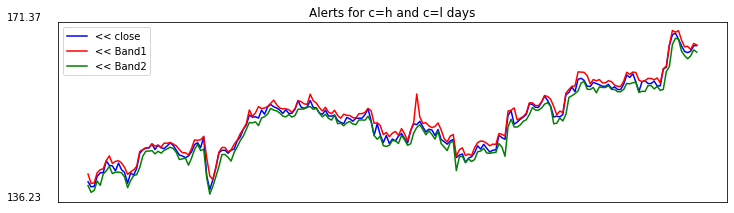

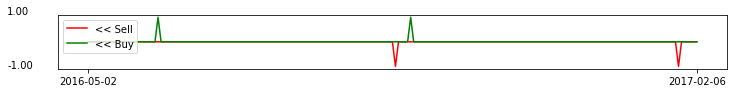

In [ ]:
df=zoom_in(dict_df['IBM'],left=4000,right=4200)
c=df['close']
h=df['high']
l=df['low']
Buy,Sell=hlc(h,l,c)

draw(c,band1=h,band2=l,buy=Buy,sell=Sell,title="Alerts for c=h and c=l days")

## Unbounded Status Strategy
The status is defined as the number of shares you have. The status is zero when you do not have any shares, and it is a negative number when you are in a short position.
<br>If your choice is unbounded status, then each buy alert is executed (one stock is bought on a buy alert) and each sell alert is executed (one stock is sold on a sell alert). Mathematically, the status can be expressed as follows: <br><br>
Status = acc(Buy - Sell), <br><br>where function acc(ser) is a cummulitative sum (integral) of series ser.<br>
To present results, we'll use function <br><br>
draw_Status(c,Buy,Sell,Status,title="Your title")<br><br>which always has the same appearamce, but is esyer to use


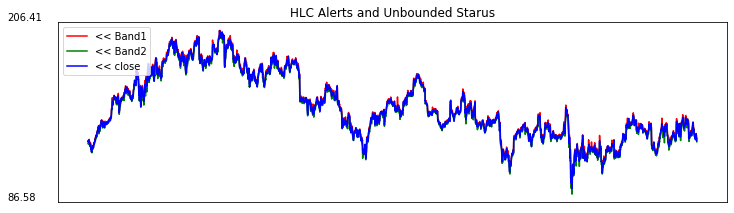

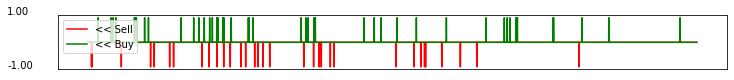

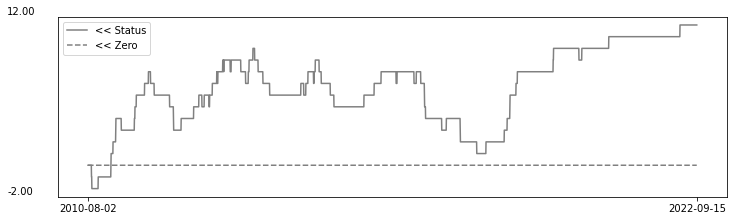

In [ ]:
df=zoom_in(dict_df['IBM'],left=2500)
c=df['close']
h=df['high']
l=df['low']
Buy,Sell=hlc(h,l,c)
Status=acc(Buy-Sell)

draw(c, status=Status,band1=h,band2=l,buy=Buy,sell=Sell,title='HLC Alerts and Unbounded Starus')

## Bounded Status Strategy
Bounded status, e.g.:<br><br>Status = bStatus(2, -1, Sell, Buy)<br><br>

means:
- Execute each buy alert unless you already have a predefined number of shares (2 in this example); after that, ignore the buy alert. <br>
- Similarly, execute each sell alert unless the number of shares you have (the status) is already equal to a predefined non-positive number of shares (-1 in this example); after that, ignore the sell alerts. <br>
<br>The function bStatus(2, -1, Sell, Buy) oscillates between 2 and (-1).
<br>By definition, bStatus(0, 0, Sell, Buy) = acc(Buy - Sell). In other worsd, setting upper bound to 0 and lower bound to 0 makes the status unbounded again. 


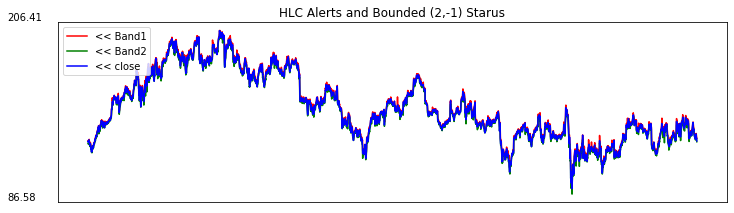

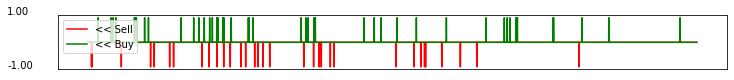

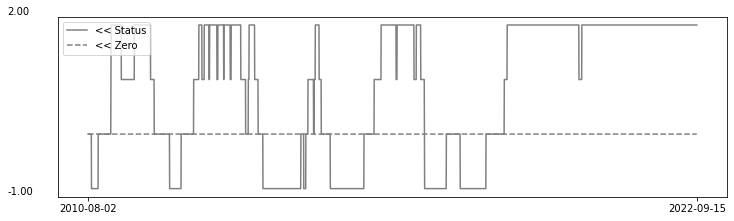

In [ ]:
df=zoom_in(dict_df['IBM'],left=2500)
c=df['close']
h=df['high']
l=df['low']

Buy,Sell=hlc(h,l,c)
Status = bStatus(2, -1, Sell, Buy)

draw(c, status=Status,band1=h,band2=l,buy=Buy,sell=Sell,title='HLC Alerts and Bounded (2,-1) Starus')

## Flip-flop Status Stategy
A flip-flop status generated by the function ffStatus(Sell, Buy) oscillates between 1 and (-1).
<br>If a current status is equal to 1, then a new buy alert does not change the status, but a new sell alert sets the statusd to (-1). 
<br>If a current status is equal to (-1), then a new sell alert does not change the status, but a new buy alert sets it to 1.
<br>If your choise is a flip-flop ststus, use function ffStatus(Sell,Buy) and calculate the number of transactions by formula TNumber=2*integral(Buy+Sell)-1


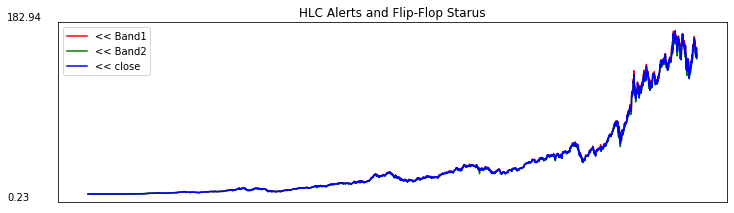

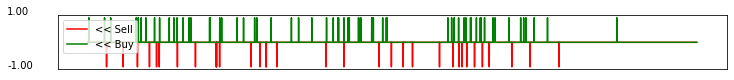

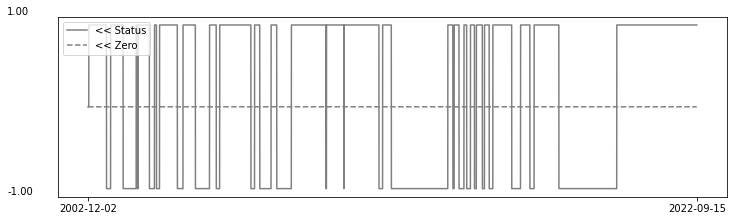

In [ ]:
O,H,L,C,V=make_series(watch_list,start=500)
h=H[0]
l=L[0]
c=C[0]
Buy,Sell=hlc(h,l,c)
Status = ffStatus(Sell, Buy)

draw(c, status=Status,band1=h,band2=l,buy=Buy,sell=Sell,title='HLC Alerts and Flip-Flop Starus')

## Testing HLC System (Unbounded)
To test  trading systems we'll use pnl() function.<br>
The function <br><br>pnl(Status,c,0.001)<br><br> calculates profits and losses in assumption that you buy and sell stocks in accordance with the chosen status at the price c and with commoddion rate r=0.1% of transaction.PNL is expressed in dollars. <br>
The blue line on the last pane is a ratio of PNL to the current stock price.

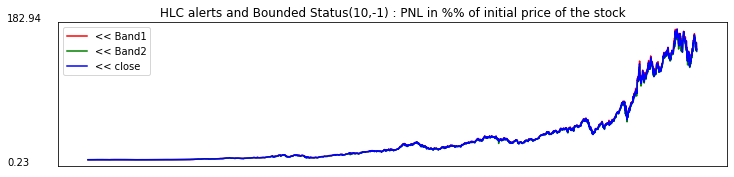

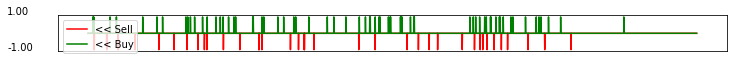

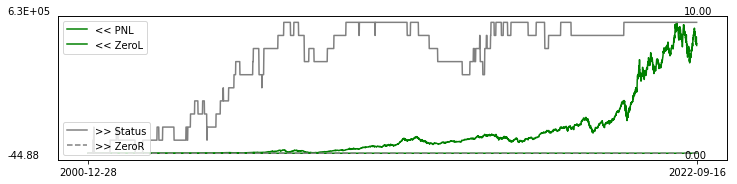

In [ ]:
O,H,L,C,V=make_series(watch_list,start=-2500)

i=0
h=H[i]
l=L[i]
c=C[i]
Buy,Sell=hlc(h,l,c)
Status=bStatus(10,0,Sell,Buy)
PNL=100*pnl(Status,c,0.001)/first(c)

ttl="HLC alerts and Bounded Status(10,-1) : PNL in %% of initial price of the stock"
draw(c, band1=h,band2=l,buy=Buy,sell=Sell,status=Status,pnl=PNL,title=ttl)

## Testing MFI System (Bounded)

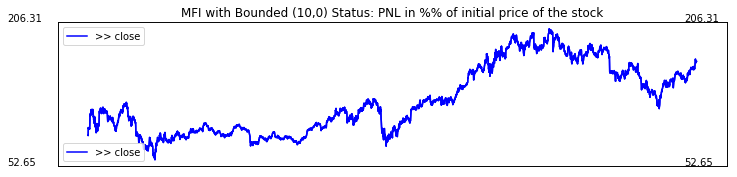

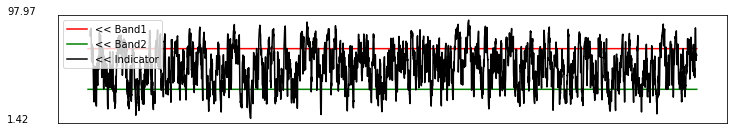

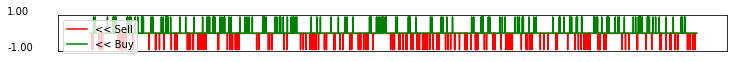

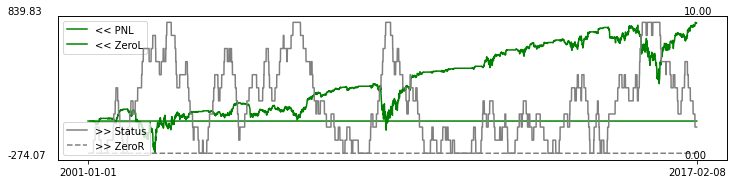

In [ ]:
df=zoom_in(dict_df['IBM'],left=0,right=4200)
c=df['close']
h=df['high']
l=df['low']
o=df['open']
v=df['open']
MFI=mfi(o,h,l,c,v,14,'mma')
Sell=break_up(MFI,70)
Buy=break_down(MFI,30)
Status=bStatus(10,0,Sell,Buy)########
PNL=100*pnl(Status,c,0.001)/first(c)

ttl="MFI with Bounded (10,0) Status: PNL in %% of initial price of the stock"
draw(c, indicator=MFI,band1=70,band2=30,buy=Buy,sell=Sell,status=Status,pnl=PNL,title=ttl)

##Testing Fast Fourier System (Bounded)

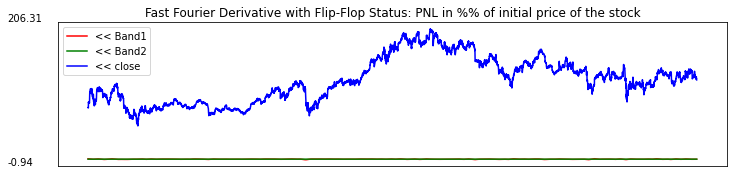

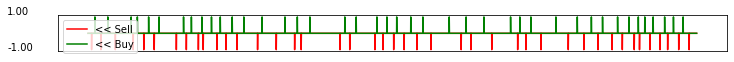

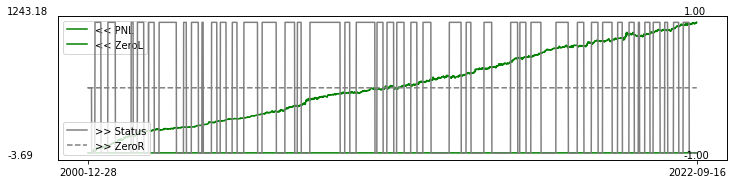

In [ ]:
O,H,L,C,V=make_series(watch_list,start=-2500)

i=1

c=C[i]
Der=ffd(c,100)
Buy=break_up(Der,0)
Sell=break_down(Der,0)
Status = ffStatus(Sell, Buy)
PNL=100*pnl(Status,c,0.001)/first(c)

ttl="Fast Fourier Derivative with Flip-Flop Status: PNL in %% of initial price of the stock"
draw(c, band1=Der,band2=0,buy=Buy,sell=Sell,status=Status,pnl=PNL,title=ttl)

##Testing Moving Fast Fourier System (Flip-Flop)

Using Fast Fourie System for trading is not correct because it uses furure pointsto generate today buy/sell signals. Moving Fast Foureie System does not use future data and does not give high PNL. 

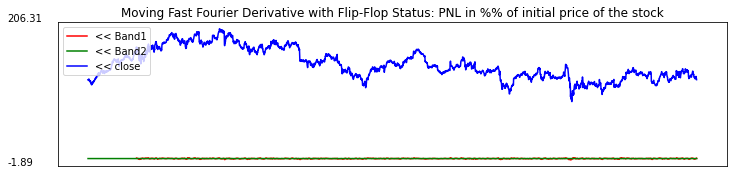

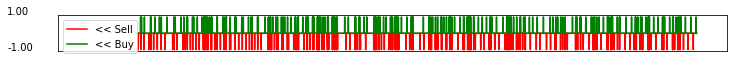

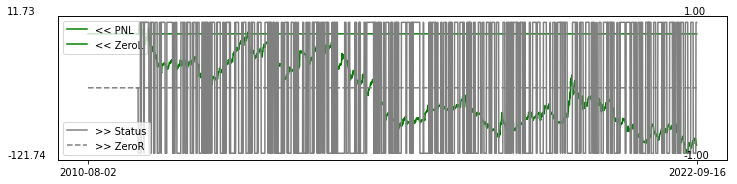

In [ ]:
df=zoom_in(dict_df['IBM'],left=2500)
c=df['close']
Der=mffd(c,10,252)
Buy=break_up(Der,0)
Sell=break_down(Der,0)
Status = ffStatus(Sell, Buy)
PNL=100*pnl(Status,c,0.001)/first(c)

ttl="Moving Fast Fourier Derivative with Flip-Flop Status: PNL in %% of initial price of the stock"
draw(c, band1=Der,band2=0,buy=Buy,sell=Sell,status=Status,pnl=PNL,title=ttl)

#PORTFOLIO


## Portfolio data
We form portfolio L as a sublist of our watch_list, e.g., L=['AMZN', 'AAPL', 'XOM', 'T','BA']. 
<br>Function <br><br>portfolio_data(dict_df, L, start='2014-01-01', end = '2018-05-31')<br><br>returns two dataframes (built from the dictionaty dict_df); in the first dataframe each column is close price of the corresponding ticker, in the second - the volume of the corresponding ticker.

In [ ]:
L=['AMZN', 'AAPL', 'XOM', 'T','BA']
dfC, dfV=portfolio_data(dict_df,L)
print("\ndfC=\n",dfC)
print("\ndfV=\n",dfV)


dfC=
              AMZN        AAPL        XOM          T          BA
-2       0.868750    0.264509  43.437500  35.592899   65.437500
-1       0.778125    0.265625  43.468750  36.064957   66.000000
 0       0.778125    0.265625  43.468750  36.064957   66.000000
 1       0.693750    0.265625  44.562500  38.047585   62.000000
 2       0.878125    0.292411  42.625000  38.519638   62.562500
...           ...         ...        ...        ...         ...
 5659  133.270004  157.369995  96.500000  17.030001  157.520004
 5660  136.449997  163.429993  97.610001  17.379999  158.720001
 5661  126.820000  153.839996  95.330002  16.830000  147.309998
 5662  128.550003  155.309998  97.669998  16.770000  149.259995
 5663  126.279999  152.369995  94.830002  16.760000  149.779999

[5666 rows x 5 columns]

dfV=
             AMZN       AAPL       XOM         T       BA
-2     169112000  305177600  10854600   5575629  2486100
-1     196994000  630336000   9564000   6240939  2554100
 0             0      

## Returns
Daily returns for each ticker are calculated as (dfC-dfC.shift(1))/dfC,
and yearly retuns (list m below) are just 252 multiplired by the mean of each collumn, where 252 is number of trading days in a year.

In [ ]:
Ret=(dfC-dfC.shift(1))/dfC
print("Ret=",Ret)

m=mu(Ret)
print("m=",m)

Ret=            AMZN      AAPL       XOM         T        BA
-2          NaN       NaN       NaN       NaN       NaN
-1    -0.116466  0.004201  0.000719  0.013089  0.008523
 0     0.000000  0.000000  0.000000  0.000000  0.000000
 1    -0.121622  0.000000  0.024544  0.052109 -0.064516
 2     0.209964  0.091604 -0.045455  0.012255  0.008991
...         ...       ...       ...       ...       ...
 5659  0.025887  0.018491  0.016477  0.015267 -0.001714
 5660  0.023305  0.037080  0.011372  0.020138  0.007560
 5661 -0.075934 -0.062337 -0.023917 -0.032680 -0.077456
 5662  0.013458  0.009465  0.023958 -0.003578  0.013064
 5663 -0.017976 -0.019295 -0.029948 -0.000597  0.003472

[5666 rows x 5 columns]
m= [0.11745060970546786, 0.2192766207393804, 0.0011215431171181954, -0.06330729265003418, -0.022977218849994385]


##Covariance Matrix
The covariance of column i and column j of the Ret dataframe gives a cell of the covariance dataframe COV:<br><br> COV=Ret.cov() <br><br>
To convert this dataframe to covariance matrix  CM we need to use a multiplier 252:<br><br>  CM=252*COV.to_numpy()<br><br>The inverse matrix (if it exists) is <br><br>Inv=np.linalg.inv(CM)<br><br>

In [ ]:
COV=Ret.cov()
print("\nCOV=\n",COV)

CM=252*COV.to_numpy()
print("\nCM=\n",CM)

Inv=np.linalg.inv(CM)
print("\nInv=\n",Inv)


COV=
           AMZN      AAPL       XOM         T        BA
AMZN  0.000822  0.000260  0.000114  0.000096  0.000186
AAPL  0.000260  0.000504  0.000118  0.000108  0.000170
XOM   0.000114  0.000118  0.000267  0.000117  0.000178
T     0.000096  0.000108  0.000117  0.000237  0.000127
BA    0.000186  0.000170  0.000178  0.000127  0.000480

CM=
 [[0.20707833 0.06561136 0.02861501 0.02418222 0.04678248]
 [0.06561136 0.12710907 0.02976023 0.02725613 0.0427309 ]
 [0.02861501 0.02976023 0.06739757 0.02940291 0.04484737]
 [0.02418222 0.02725613 0.02940291 0.05970528 0.03191267]
 [0.04678248 0.0427309  0.04484737 0.03191267 0.1210076 ]]

Inv=
 [[ 5.99877589 -2.50533436 -0.49471383 -0.43489062 -1.13643528]
 [-2.50533436 10.53013564 -1.5830038  -2.16123833 -1.5932216 ]
 [-0.49471383 -1.5830038  22.72303275 -7.1789649  -5.77799475]
 [-0.43489062 -2.16123833 -7.1789649  22.73146611 -2.40288396]
 [-1.13643528 -1.5932216  -5.77799475 -2.40288396 12.04102413]]


## Weights For Minimum Variance Portfolio.
To compute the weights (money in a stock over money in the portfolio) we use formula

  &emsp;&emsp;w=weights(Inv)

Negative weight means short position.
The weighted prices of the components are:

  &emsp;&emsp;weighted_prices = w*dfC.iloc[-1:,:].to_numpy()[0]

The price of the entire portfilio is

  &emsp;&emsp;portfolio_price=weighted_prices.sum()

(the weighted sum of its components' prices.)
<br>Similarly we calculate weighted volumes and the portfolio volume:

  &emsp;&emsp;weighted_volumes = w*dfV.iloc[-1:,:].to_numpy()[0]<br>
  &emsp;&emsp;weighted_volumes = weighted_volumes.astype(int)<br>
  &emsp;&emsp;portfolio_volume=weighted_volumes.sum()


In [ ]:
w=weights(Inv)
print("weights=",w)

weighted_prices=w*dfC.iloc[-1:,:].to_numpy()[0]
print("weighted_prices=",weighted_prices)

portfolio_price=weighted_prices.sum()
print("portfolio_price=",portfolio_price)

weighted_volumes=w*dfV.iloc[-1:,:].to_numpy()[0]
weighted_volumes = weighted_volumes.astype(int)
print("weighted_volumes=",weighted_volumes)

portfolio_volume=weighted_volumes.sum()
print("portfolio_volume=",portfolio_volume)

weights= [0.06077394 0.11441774 0.32734415 0.4493318  0.04813238]
weighted_prices= [ 7.67453261 17.43382977 31.04204626  7.53080105  7.20926709]
portfolio_price= 70.8904767848678
weighted_volumes= [ 3203382 10327722  6902313 17352969   470739]
portfolio_volume= 38257125


## Portfolio price and volume as time series
The above calculations give the portfolio price and portfolio volume only for the last day of the time interval.
To have the price and the the volume on rolling m days, use function<br><br>mov_portf(dfC,dfV,m):<br><br>where m is number of rolling days


In [ ]:
def mov_portf(dfC,dfV, m):
  step=1
  start=dfC.index[0]
  end=dfC.index[-1]
  print(start,end)
  assert m <= end-start+1,"m is too big"
  movStart = end - (m-1)
  while movStart > start: 
    movStart-=step
  movStart+=step
  movEnd=movStart+(m-1)
  index=[]
  rows=[]
  ws=[]
  while(movEnd<=end):
    movStart+=step
    movEnd=movStart+(m-1)
    index.append(movEnd)
    #print(movStart,movEnd)
    dfC, dfV=portfolio_data(dict_df,L,start=movStart,end =movEnd)
    Ret=(dfC-dfC.shift(1))/dfC
    COV=Ret.cov()
    CM=252*COV.to_numpy()
    Inv=np.linalg.inv(CM)
    w=weights(Inv)
    ws.append(w)
    weighted_prices=w*dfC.iloc[-1:,:].to_numpy()[0]
    portfolio_price=weighted_prices.sum()
    weighted_volumes=w*dfV.iloc[-1:,:].to_numpy()[0]
    weighted_volumes = weighted_volumes.astype(int)
    portfolio_volume=weighted_volumes.sum()
    rows.append([portfolio_price,portfolio_volume])
  dfP=pd.DataFrame(rows,index,columns=['price','volume'])
  dfW=pd.DataFrame(ws,index,columns=dfC.columns)
  return dfW, dfP


dfW, dfP=mov_portf(dfC,dfV,250)

print("Weights(t)=\n",dfW)
print("Price(t)=\n",dfP)


-2 5663
Weights(t)=
           AMZN      AAPL       XOM         T        BA
249   0.012793  0.061453  0.557275  0.272894  0.095586
250   0.011119  0.061848  0.560844  0.277522  0.088666
251   0.008870  0.059680  0.570665  0.273372  0.087412
252   0.011219  0.055907  0.572647  0.272092  0.088134
253   0.011654  0.056699  0.566760  0.274953  0.089934
...        ...       ...       ...       ...       ...
5660 -0.042341  0.349471  0.261857  0.446074 -0.015062
5661 -0.046302  0.345255  0.268150  0.453165 -0.020269
5662 -0.047852  0.344992  0.267822  0.454167 -0.019129
5663 -0.049732  0.341561  0.267422  0.455217 -0.014468
5664 -0.049613  0.342197  0.267097  0.454926 -0.014607

[5416 rows x 5 columns]
Price(t)=
           price    volume
249   32.187915  23667697
250   32.699259  23045598
251   32.805591  23991622
252   33.387421  28485712
253   33.418673  24231088
...         ...       ...
5660  82.258707  57910877
5661  77.445772  62850618
5662  78.348736  52705335
5663  76.585575  512866

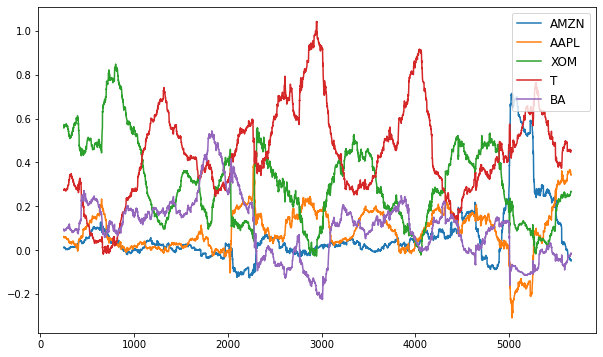

In [ ]:
#plot each series
plt.figure(figsize=(10, 6))
plt.plot(dfW['AMZN'],label='AMZN')
plt.plot(dfW['AAPL'],label='AAPL')
plt.plot(dfW['XOM'],label='XOM')
plt.plot(dfW['T'],label='T')
plt.plot(dfW['BA'],label='BA')
plt.legend(loc='best', fontsize=12)


#display plot
plt.show()

## Trading MinVarPortfolio

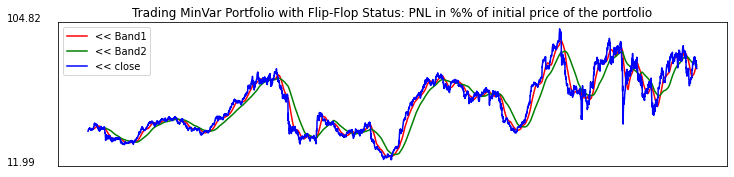

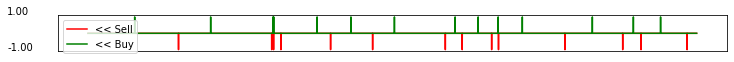

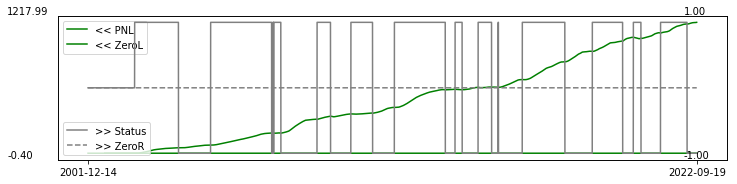

In [ ]:
c=dfP['price']
#v=dfP['volume']
FAST=sma(c,50)
SLOW=sma(c,150) 
Buy=break_up(FAST,SLOW)
Sell=break_down(FAST,SLOW)
Status = ffStatus(Sell, Buy)
PNL=100*pnl(Status,SLOW,0.001)/first(c)

ttl="Trading MinVar Portfolio with Flip-Flop Status: PNL in %% of initial price of the portfolio"
draw(c, band1=FAST,band2=SLOW,buy=Buy,sell=Sell,status=Status,pnl=PNL,title=ttl)

#BINARY NEURAL NETWORK CLASSIFICATION



##Trading strategy and target
Consider the following strategy of trading the same ticker, e.g. "IBM".
At the end of each day make one of 2 possible transactions:

(1) byu a stock (open long position)<br>
(2) sell a stock (open short position)

In nHold days sell the stock if you have bought it (close long) or buy the stock if you have sold it (close short).
As a result, each day falls into one of two classes: good for long (class 1) or good for short (class 0). The creterea is the return value in nHold days (We are talking about historical data, so 'today' means 'current' day, and price in nHold days is known, exept the last nHold days). The return is defined as

rr=(price in nHold days - today's price)/today's price.

If the return is greatet or equal to zero, mark today's date as clas 1, else - as class 0.Function

get_labels(df, nHold, rr),

where df is dict_df["IBM"], creates column 'label' which is the target for the considered trading strategy, see example for ticker="IBM" and nHold=3 below

In [ ]:
dfStock=zoom_in(dict_df["IBM"],left='2000-12-27',right='2003-1-1')#to save time on examples
nHold=3
rr=0
df=get_labels(dfStock, nHold, rr)
print(df)

            date      close    shifted   returns  label
-2    2000-12-28  81.500954  81.082695 -0.005132    0.0
-1    2000-12-29  81.261948  90.463669  0.113235    1.0
 0    2001-01-01  81.261948  89.089386  0.096324    1.0
 1    2001-01-02  81.082695  89.866158  0.108327    1.0
 2    2001-01-03  90.463669  89.447899 -0.011228    0.0
...          ...        ...        ...       ...    ...
 518  2002-12-26  75.047798  74.091782 -0.012739    0.0
 519  2002-12-27  73.957932  74.091782  0.001810    1.0
 520  2002-12-30  72.896751        NaN       NaN    NaN
 521  2002-12-31  74.091782        NaN       NaN    NaN
 522  2003-01-01  74.091782        NaN       NaN    NaN

[525 rows x 5 columns]


To build a target y, we remove  last nHold days (where the labels are not known):


In [ ]:
y=df['label'][:-nHold]
print("target=\n",y)

target=
 -2      0.0
-1      1.0
 0      1.0
 1      1.0
 2      0.0
       ... 
 515    0.0
 516    0.0
 517    0.0
 518    0.0
 519    1.0
Name: label, Length: 522, dtype: float64


##Feature Marix
Feature Marix X is a 2D array where row corresponds to a day and column - to some  indicator transformed to interval from -1 to 1.<br>
To build X, we start from empty dataframe DF and add columns to this dataframe untill all columns are added.<br>
For training data it is known if the current day is good for long (class 1) or good for short (class 0).
Each day can be presented as a point in 4D space (if we are using 4 indicators/columns), where the coordinates are equql to the calculated indicators for this day. We need a model which can distingwish points in the testing class.<br>
It can be routinely done with the help of binary classification for sinple cases like 2D example below.



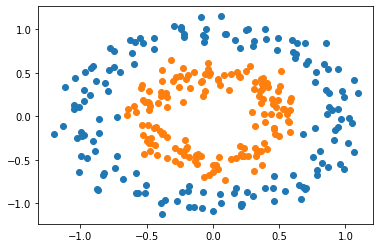

In [ ]:
from sklearn.datasets import make_regression, make_circles, make_blobs
X, y = make_circles(n_samples=300, factor=0.5, noise=0.1, random_state=2020)

V1=[]
V2=[]
W1=[]
W2=[]
for i in range(len(y)):
  if y[i]==0:
    V1.append(X[i][0])
    V2.append(X[i][1])
  else:
    W1.append(X[i][0])
    W2.append(X[i][1])

plt.scatter(V1,V2)
plt.scatter(W1,W2)
plt.show()

Let us try to create the model for our problem.<br>To calculate the first column, we use relative strenght index. This indicator takes values from 0 to 100, so we apply the linear transformation to interval from -1 to 1.The corresponding function is col_1=col_rsi(dfStock,14).

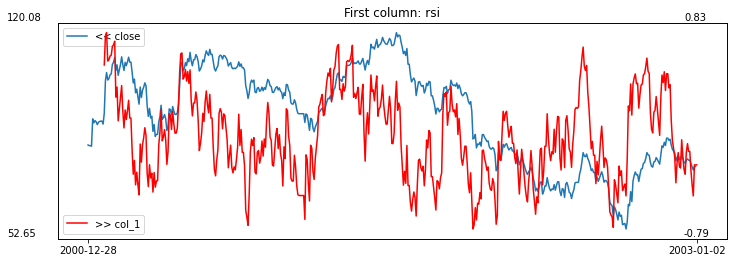

12     0.566563
13     0.806527
14     0.833417
15     0.598839
16     0.609562
         ...   
519   -0.423051
520   -0.513533
521   -0.257317
522   -0.257317
523   -0.257317
Length: 512, dtype: float64


In [ ]:
dfStock=zoom_in(dict_df["IBM"],left='2000-12-27',right='2003-1-1')
c=df['close']

col_1=col_rsi(dfStock,14) ##########################################3

lines=[[c,        "label=close"],
       [col_1,    "label=col_1,  y=right,   color=r"]]

draw_chart(lines,title="First column: rsi")
print(col_1)

attach this column to empty DF:

In [ ]:
DF=pd.DataFrame()
DF=attach_col(DF,col_rsi,dfStock,14)
print("DF=\n",DF)

DF=
         col_1
12   0.566563
13   0.806527
14   0.833417
15   0.598839
16   0.609562
..        ...
519 -0.423051
520 -0.513533
521 -0.257317
522 -0.257317
523 -0.257317

[512 rows x 1 columns]


The second column is based on 'pressure', which is

(close -true_low)/(true_range).


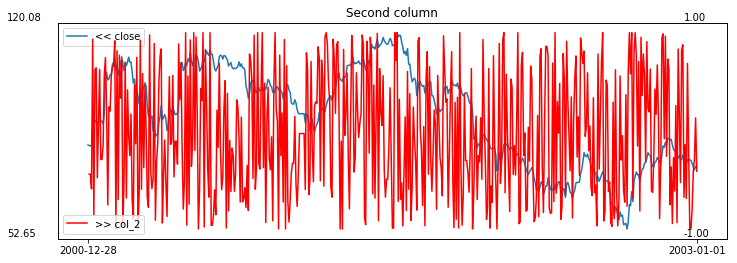

DF=
         col_1     col_2
12   0.566563  0.575002
13   0.806527  0.746479
14   0.833417  0.196261
15   0.598839 -0.755104
16   0.609562  0.243240
..        ...       ...
518 -0.308584 -0.803284
519 -0.423051 -0.416347
520 -0.513533 -0.289618
521 -0.257317  0.131225
522 -0.257317 -0.411755

[511 rows x 2 columns]


In [ ]:
col_2=col_press(dfStock)  ########################################

lines=[[c,       "label=close"],
       [col_2,   "label=col_2,  y=right,   color=r"]]

draw_chart(lines,title="Second column")

DF=attach_col(DF,col_press,dfStock)######################################
print("DF=\n",DF)

Third column is based on money flow index:

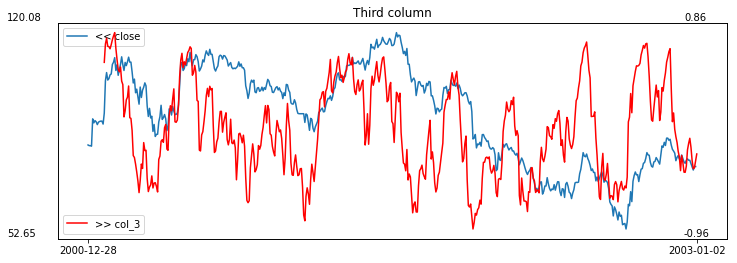


 DF:         col_1     col_2     col_3
12   0.566563  0.575002  0.583806
13   0.806527  0.746479  0.753713
14   0.833417  0.196261  0.806871
15   0.598839 -0.755104  0.732127
16   0.609562  0.243240  0.729402
..        ...       ...       ...
518 -0.308584 -0.803284 -0.201444
519 -0.423051 -0.416347 -0.325170
520 -0.513533 -0.289618 -0.399818
521 -0.257317  0.131225 -0.391033
522 -0.257317 -0.411755 -0.328788

[511 rows x 3 columns]


In [ ]:
col_3=col_mfi(dfStock,14,'sma') #############################################

lines=[[c,       "label=close"],
       [col_3,   "label=col_3,  y=right,   color=r"]]

draw_chart(lines,title="Third column")

DF=attach_col(DF,col_mfi,dfStock,14,"sma")########################################
print("\n DF:",DF)

Fourth - on directional movement:

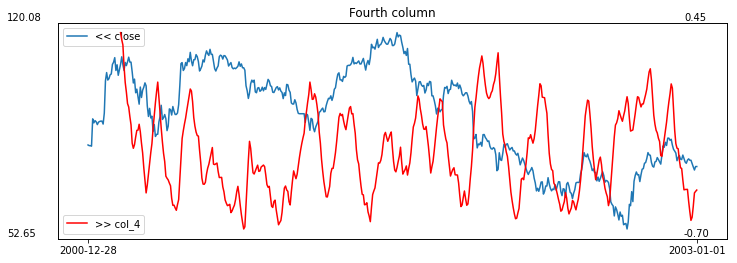


 DF:         col_1     col_2     col_3     col_4
26   0.289884  0.331848  0.540724  0.448063
27   0.396425  0.720080  0.410670  0.406558
28   0.184573 -0.966429  0.378630  0.376593
29   0.047534 -0.498746  0.079309  0.251698
30   0.195780  0.697418  0.135096  0.156119
..        ...       ...       ...       ...
518 -0.308584 -0.803284 -0.201444 -0.632211
519 -0.423051 -0.416347 -0.325170 -0.567928
520 -0.513533 -0.289618 -0.399818 -0.490037
521 -0.257317  0.131225 -0.391033 -0.481024
522 -0.257317 -0.411755 -0.328788 -0.473212

[497 rows x 4 columns]


In [ ]:
col_4=col_adx(dfStock,14) ############################################

lines=[[c,       "label=close"],
       [col_4,   "label=col_4,  y=right,   color=r"]]

draw_chart(lines,title="Fourth column")

DF=attach_col(DF,col_adx,dfStock,14)###############################
print("\n DF:",DF)

The above operations (calculation of columns and attaching them to dataframe DF) are performed by the function <br><br>get_Xy(ticker,nHold)<br><br>
For given ticker, e.g. "IBM, and given nHold, e.g. nHold=22, this function returns feature matix X and target y. So, replace all the code for these operations with the call of function get_Xy().<br>In example below we go back to time interval for df from "2000-12-28" to today.

In [ ]:
funcs=[col_rsi,   col_press,  col_mfi,            col_adx]
ars=[[dfStock,14],[dfStock],  [dfStock,14,'sma'],[dfStock,14]]

X,y=get_Xy(dfStock,14,funcs,ars)##############################################3

print("X=",X,"\nlen(X)=",len(X))
print('y=',y,"\nlen(y)=",len(y))


X= [[ 0.28988446  0.33184766  0.54072386  0.44806305]
 [ 0.3964248   0.72007954  0.41067049  0.40655785]
 [ 0.18457277 -0.96642919  0.37862972  0.37659326]
 ...
 [-0.07838643  0.33823289  0.06630525 -0.50952985]
 [-0.35617381 -0.97916196 -0.07671797 -0.4642291 ]
 [-0.36049888 -0.20000584 -0.174924   -0.41131685]] 
len(X)= 5625
y= [0. 0. 0. ... 0. 0. 0.] 
len(y)= 5625


##Classification
To see if we can divide these several thosands 4D points into two classes let's use 2D visualisation.<br>Function show_classes(X,y,m,n) shows each point as blue or orange (depending on label y) in plain (m,n), where m and n are 0,1,2, or 3:

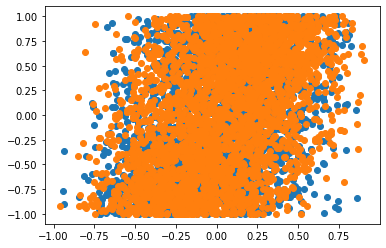

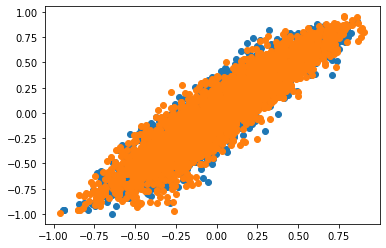

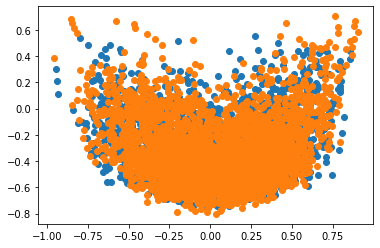

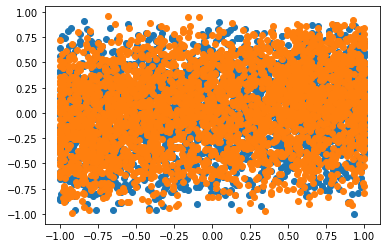

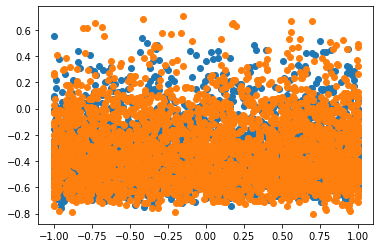

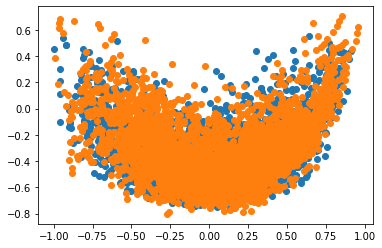

In [ ]:
show_classes(X,y,0,1)
show_classes(X,y,0,2)
show_classes(X,y,0,3)
show_classes(X,y,1,2)
show_classes(X,y,1,3)
show_classes(X,y,2,3)

So, classification (at least with the help of  four chosen indicators does not look feasable.

#COVOLUTIONAL NEURAL NETWORK


##Trading Strategy
Consider the following strategy of trading the same ticker, e.g. "IBM". <br>At the end of each day make one of 3 possible transactions:<br><br>
(1) byu a stock (open long position) <br>
(2) sell a stock (open short position)<br>
(3) do nothing<br><br>
In nHold days sell the stock if you have bought it (close long) or buy the stock if you have sold it (close short).<br>As a result, each day falls into one of three classes: good long(class 0), none (class 1), and good for short (class 2). The creterea is the return value in nHold days (We are talking about historical data, so 'today' means 'current' day, and price in nHold days is known, exept last nHold days). The return is defined as <br><br>(price in nHold days - today's price)/today's price.<br><br>If the return is greatet than some value rr, e.g. rr=1%, - mark today's date as long, else if the return is less than (-rr) - mark today's day as short, else - as none<br>
Use function <br><br>get_label3()<br><br>to created column 'label' which is the target for the considered trading strategy, see example for ticker="IBM",nHold=2, and rr=0.01 below



In [ ]:
#dfStock=zoom_in(dict_df["IBM"],left='2000-12-27',right='2003-1-1')#to save time on examples
dfStock=dict_df["IBM"]
nHold=3
rr=0.01
#df=dfStock
df=get_labels3(dfStock, nHold, rr)
print(df)

             date       close     shifted   returns  label
-2     2000-12-28   81.500954   81.082695 -0.005132    2.0
-1     2000-12-29   81.261948   90.463669  0.113235    1.0
 0     2001-01-01   81.261948   89.089386  0.096324    1.0
 1     2001-01-02   81.082695   89.866158  0.108327    1.0
 2     2001-01-03   90.463669   89.447899 -0.011228    0.0
...           ...         ...         ...       ...    ...
 5662  2022-09-14  127.690002  127.730003  0.000313    2.0
 5663  2022-09-15  125.489998  126.300003  0.006455    2.0
 5664  2022-09-16  127.269997         NaN       NaN    NaN
 5665  2022-09-19  127.730003         NaN       NaN    NaN
 5666  2022-09-20  126.300003         NaN       NaN    NaN

[5669 rows x 5 columns]


##Target
Count the number of days in each class (without considering the last nHold days where the label is not known)

In [ ]:
n_long=df.loc[df.label==0,'label'].count()
n_none=df.loc[df.label==1,'label'].count()-nHold # minus last nHold rows
n_short=df.loc[df.label==2,'label'].count()
print('n_long=',n_long,'n_none=',n_none,'n_short=',n_short)

n_long= 1594 n_none= 1743 n_short= 2326


For given nHold, the number of days in each class depends on rr. To have a balansed model, choose rr so that these numbers were as close to avg=(n_long+n_none+n_short)/3 as possile. For this purpose, minimize<br><br> zz=(n_long-avg)\*(n_long-avg)+(n_none-avg)\*(n_none-avg)+(n_short-avg)\*(n_short-avg)<br><br> see the graph below.


zmin= 15908.666666666666 rr= 0.0078


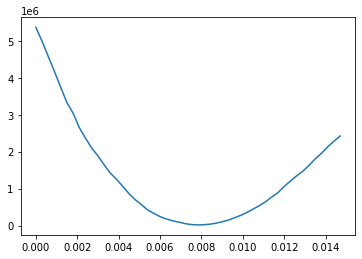

In [ ]:
df=dfStock
nHold=3
xs=[]
for i in range(50):
  xs.append(0.0003*i)
z=[]
for rr in xs: 
  z.append(zz(dfStock,nHold,rr)[3])

plt.plot(xs,z)

zmin=min(z)
rr=0.0003*z.index(zmin)
print("\nzmin=",zmin,"rr=",rr)

The desired rr is given by the function find_rr(df, nHold,0,1,0.0000001),where the last three arguments are left and righ boundaries and precision of the search.

In [ ]:
nHold=3
rrn=find_rr(df, nHold,0,1,0.0000001)
print("rr=",rrn[3])

rr= 0.007823232646249718


After rr is known, build the target for the trading strategy. The entire code for IBM with nHold=22 is below. Please pay attention that last nHpld days are removed from the target y.

In [ ]:
df=dfStock
nHold=22
rrn=find_rr(df, nHold,0,1,0.0000001)
rr=rrn[3]
n_long=rrn[0]
n_none=rrn[1]
n_short=rrn[2]
y=get_labels3(df, nHold, rr)['label'][:-nHold]
print("\n nHold=",nHold,"\n rr=",rr,"\n\n target=\n",y)
print("\n n_long=",n_long,"n_none=",n_none,"n_short=",n_short)


 nHold= 22 
 rr= 0.023257084620045096 

 target=
 -2       1.0
-1       1.0
 0       1.0
 1       1.0
 2       1.0
        ... 
 5640    0.0
 5641    0.0
 5642    0.0
 5643    0.0
 5644    0.0
Name: label, Length: 5647, dtype: float64

 n_long= 1715 n_none= 2032 n_short= 1878


##Trading Data and Indicators Structure
Trading Data comprises ttree dataframes: <br><br>TD=[dfStock, dfDow, dfNasdaq]<br><br> where dfStock=dict_df["IBM"], dfDow=dict_df["^DJI"], and dfNasdaq=dict_df["^IXIC"]<br>
Indicators stracture comprizes tree dataframes <br><br>TS=[DF, DF1, DF2].<br><br> Each of them is calculated by the same formulas but fist dataframe uses dict_df("IBM") as a data source, second - dict_df("^DJI") -Dow Indastrial, and third - dict_df("") -Nasdaq. The rows in these dataframes correspond to trading days; the columns are build based on different buy and sell alerts.If on current day there is a buy alert, the value in the corresponding cell is 255, if a sell alert - 0, otherwise -128.<br> Let's illustrate the process of building Trading Structure's. We start from building a columns for IBM dataframe which is shown below.

In [ ]:
df=dict_df["IBM"]
dfStock=zoom_in(df,left='2000-12-27',right='2003-1-1')
#dfStock=dict_df["IBM"]
df=dict_df["^DJI"].copy()
dfDow=zoom_in(df,left='2000-12-27',right='2003-1-1')
#dfDow=dict_df["^DJI"].copy()
df=dict_df["^IXIC"]
dfNasdaq=zoom_in(df,left='2000-12-27',right='2003-1-1')
#dfNasdaq=dict_df["^IXIC"]
TD=[dfStock, dfDow, dfNasdaq]

DF=pd.DataFrame();
DF1=pd.DataFrame();
DF2=pd.DataFrame();
TS=[DF,DF1,DF2]

df=dfStock
print(df)

            date       open       high        low      close    volume
-2    2000-12-28  79.827919  84.309273  78.513382  81.500954  10249336
-1    2000-12-29  83.114243  83.114243  80.544930  81.261948   7263110
 0    2001-01-01  83.114243  83.114243  80.544930  81.261948         0
 1    2001-01-02  80.783936  83.652008  80.425430  81.082695   8375531
 2    2001-01-03  80.066925  90.822182  80.066925  90.463669  13357315
...          ...        ...        ...        ...        ...       ...
 518  2002-12-26  76.300194  77.151054  74.818359  75.047798   6050378
 519  2002-12-27  75.047798  75.697899  73.240921  73.957932   6625469
 520  2002-12-30  73.613770  74.024857  72.275337  72.896751   8437664
 521  2002-12-31  73.709366  75.009560  73.709366  74.091782   8233484
 522  2003-01-01  73.709366  75.009560  73.709366  74.091782         0

[525 rows x 6 columns]


To calculate the first column, we use relative strenght index. This indicator takes values from 0 to 100, so we apply the linear transformation to interval from -1 to 1.The corresponding function is col_1=col_rsi(dfStock,14).

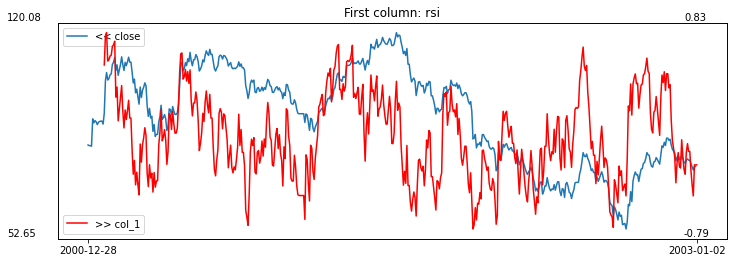

12     0.566563
13     0.806527
14     0.833417
15     0.598839
16     0.609562
         ...   
519   -0.423051
520   -0.513533
521   -0.257317
522   -0.257317
523   -0.257317
Length: 512, dtype: float64


In [ ]:
dfStock=zoom_in(dict_df["IBM"],left='2000-12-27',right='2003-1-1')
#dfStock=dict_df["IBM"]
c=dfStock['close']

col_1=col_rsi(dfStock,14) ##########################################3

lines=[[c,        "label=close"],
       [col_1,    "label=col_1,  y=right,   color=r"]]

draw_chart(lines,title="First column: rsi")
print(col_1)


The values should be transformed from interval [-1,1] to interval [0,255] because we are going to use these values to build images (red for DF, green for DF1, and blue for DF2).<br> Initially, dataframes DF, DF1, and DF2 of the Trading Structure are empty. We need to add the calculated column to DF, then calculate two more similar columns - one for DF1, another - for DF2. All these operations - transforming the interval, calculating of three columns and adding them to the Indicators Structure - can be performed by function<br><br>TS=add_col(TS,TD,func,*args):

In [ ]:
def add_col(TS,TD,func,*args):
  for i in range(len(TD)):
    df=TD[i]
    #print("df=",df)
    DF=TS[i]
    col=(func(df,*args)+1)*255/2
    if DF.empty: 
      TS[i]=pd.DataFrame({"col_1":col})
      TS[i]=TS[i].round(0)
    else:
      col_name='col_'+str(len(TS[i].columns)+1)
      TS[i][col_name]=col
      #TS[i].round(0)
      TS[i]=TS[i].round(0)
      TS[i]=TS[i].dropna(axis=0)
  return TS


TS=add_col(TS, TD,col_rsi,14)
print("\n DS:")
print(TS[0].head(2))
print(TS[0].tail(2))
print("\n DS1:")
print(TS[1].head(2))
print(TS[1].tail(2))
print("\n DS2:")
print(TS[2].head(2))
print(TS[2].tail(2))


 DS:
    col_1
12  200.0
13  230.0
     col_1
522   95.0
523   95.0

 DS1:
    col_1
12   98.0
13  120.0
     col_1
522   94.0
523   94.0

 DS2:
    col_1
12  141.0
13  157.0
     col_1
522   78.0
523   78.0


The second column is based on 'pressure', which is

(close -true_low)/(true_range).

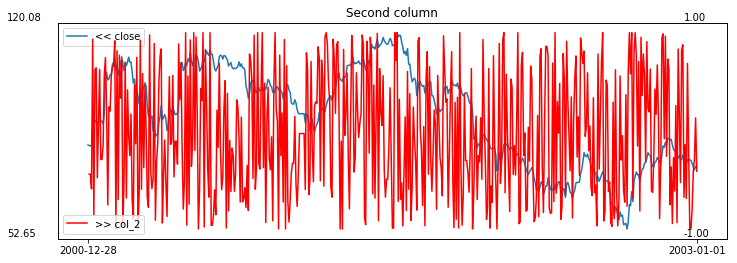


 DS:
    col_1  col_2
12  200.0  201.0
13  230.0  223.0
     col_1  col_2
521   95.0  144.0
522   95.0   75.0

 DS1:
    col_1  col_2
12   98.0   62.0
13  120.0  166.0
     col_1  col_2
521   94.0  213.0
522   94.0  213.0

 DS2:
    col_1  col_2
12  141.0  119.0
13  157.0  252.0
     col_1  col_2
521   78.0  118.0
522   78.0  118.0


In [ ]:
col_2=col_press(dfStock)  ########################################

lines=[[c,       "label=close"],
       [col_2,   "label=col_2,  y=right,   color=r"]]

draw_chart(lines,title="Second column")

TS=add_col(TS, TD,col_press)######################################
print("\n DS:")
print(TS[0].head(2))
print(TS[0].tail(2))
print("\n DS1:")
print(TS[1].head(2))
print(TS[1].tail(2))
print("\n DS2:")
print(TS[2].head(2))
print(TS[2].tail(2))

Third column is based on money flow index:

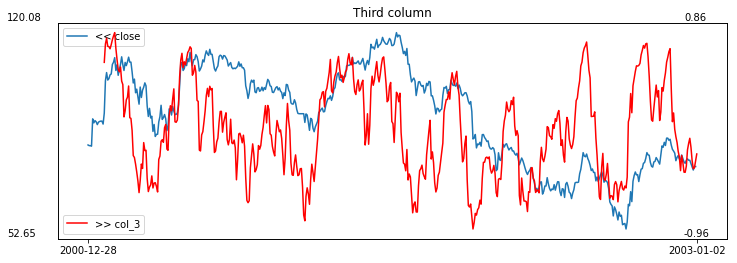


 DS:
    col_1  col_2  col_3
12  200.0  201.0  202.0
13  230.0  223.0  224.0
     col_1  col_2  col_3
521   95.0  144.0   78.0
522   95.0   75.0   86.0

 DS1:
    col_1  col_2  col_3
12   98.0   62.0   97.0
13  120.0  166.0  109.0
     col_1  col_2  col_3
521   94.0  213.0   79.0
522   94.0  213.0   87.0

 DS2:
    col_1  col_2  col_3
12  141.0  119.0  149.0
13  157.0  252.0  160.0
     col_1  col_2  col_3
521   78.0  118.0   77.0
522   78.0  118.0   70.0


In [ ]:
col_3=col_mfi(dfStock,14,'sma') #############################################

lines=[[c,       "label=close"],
       [col_3,   "label=col_3,  y=right,   color=r"]]

draw_chart(lines,title="Third column")

TS=add_col(TS, TD,col_mfi,14,"sma")########################################
print("\n DS:")
print(TS[0].head(2))
print(TS[0].tail(2))
print("\n DS1:")
print(TS[1].head(2))
print(TS[1].tail(2))
print("\n DS2:")
print(TS[2].head(2))
print(TS[2].tail(2))

Fourth - on directional movement::

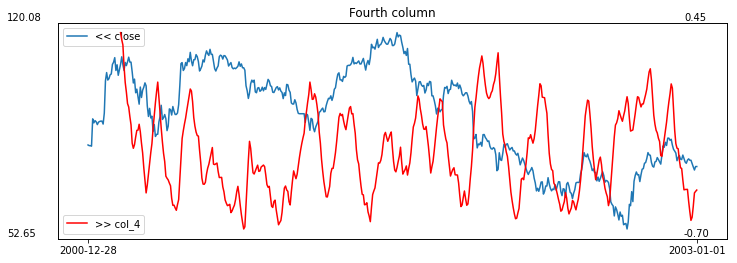


 DS:
    col_1  col_2  col_3  col_4
26  164.0  170.0  196.0  185.0
27  178.0  219.0  180.0  179.0
     col_1  col_2  col_3  col_4
521   95.0  144.0   78.0   66.0
522   95.0   75.0   86.0   67.0

 DS1:
    col_1  col_2  col_3  col_4
26  163.0   63.0  193.0   80.0
27  160.0   97.0  186.0   86.0
     col_1  col_2  col_3  col_4
521   94.0  213.0   79.0   81.0
522   94.0  213.0   87.0   84.0

 DS2:
    col_1  col_2  col_3  col_4
26  103.0   95.0  109.0   45.0
27   87.0  123.0   98.0   51.0
     col_1  col_2  col_3  col_4
521   78.0  118.0   77.0   87.0
522   78.0  118.0   70.0   91.0


In [ ]:
col_4=col_adx(dfStock,14) ############################################

lines=[[c,       "label=close"],
       [col_4,   "label=col_4,  y=right,   color=r"]]

draw_chart(lines,title="Fourth column")

TS=add_col(TS, TD,col_adx,14)###############################
print("\n DS:")
print(TS[0].head(2))
print(TS[0].tail(2))
print("\n DS1:")
print(TS[1].head(2))
print(TS[1].tail(2))
print("\n DS2:")
print(TS[2].head(2))
print(TS[2].tail(2))

We will use 32 columns. The other 28 columns are build with the help of the same functions (col_two_ema, col_press, col_mfi, and col_momR) but with different parameters. Time interval for Tdading Data is set from 1992-1-1 to today. The last nHold daya are deleted from the Trading Stracture because the target is not known for those days.<br>The entire code fo creating Trading Structure is given below (It takes about 3 minutes to execute this code).





In [ ]:
funcs=[col_rsi,col_press,col_mfi,col_adx,col_rsi,col_mfi,col_mfi,col_adx,col_rsi,col_mfi,col_mfi,col_adx,col_rsi,col_mfi,col_mfi,col_adx,col_rsi,col_mfi,col_mfi,col_adx,col_rsi,col_mfi,col_mfi,col_adx,col_rsi,col_mfi,col_mfi,col_adx,col_rsi,col_mfi,col_mfi,col_adx]
ars=[[14],[],[14,"sma"],[2],
     [4],[4,"ema"],[4,"sma"],[3],
     [9],[9,"ema"],[9,"sma"],[4],
     [19],[19,"ema"],[19,"sma"],[5],
     [24],[24,"ema"],[24,"sma"],[6],
     [29],[29,"ema"],[29,"sma"],[7],
     [34],[34,"ema"],[34,"sma"],[8],
     [39],[39,"ema"],[39,"sma"],[9]]

DF,DF1,DF2,target=get_TSy(dfStock,dfDow,dfNasdaq,nHold,funcs,ars)
print("Shapes:\n",DF.shape, DF1.shape, DF2.shape)
n_start=DF.index[0]
print("DF startIndex=",n_start)
n_end=DF.index[-1]
print("DF endIndex=",n_end)
print("DF=",DF)
print("\n nHold=",nHold,"\n rr=",rr,"\n\n target=\n",target)
print('******************')
"""
#Trading Data

dfStock=zoom_in(dict_df['IBM'],left='2000-12-27',right='2003-1-1')
dfDow=zoom_in(dict_df['^DJI'],left='2000-12-27',right='2003-1-1')
dfNasdaq=zoom_in(dict_df['^IXIC'],left='2000-12-27',right='2003-1-1')
TD=[dfStock, dfDow, dfNasdaq]

#Trading Structure (takes three minutes)
DF=pd.DataFrame()
DF1=pd.DataFrame()
DF2=pd.DataFrame()
TS=[DF,DF1,DF2]
#1
TS=add_col(TS, TD,col_rsi,14)
TS=add_col(TS, TD,col_press)
TS=add_col(TS, TD,col_mfi,14,"sma")
TS=add_col(TS, TD,col_adx,2)
#2
TS=add_col(TS, TD,col_rsi,4)
TS=add_col(TS, TD,col_mfi,4,"ema")
TS=add_col(TS, TD,col_mfi,4,"sma")
TS=add_col(TS, TD,col_adx,3)
#3
TS=add_col(TS, TD,col_rsi,9)
TS=add_col(TS, TD,col_mfi,9,"ema")
TS=add_col(TS, TD,col_mfi,9,"sma")
TS=add_col(TS, TD,col_adx,4)
#4
TS=add_col(TS, TD,col_rsi,19)
TS=add_col(TS, TD,col_mfi,19,"ema")
TS=add_col(TS, TD,col_mfi,19,"sma")
TS=add_col(TS, TD,col_adx,5)
#5
TS=add_col(TS, TD,col_rsi,24)
TS=add_col(TS, TD,col_mfi,24,"ema")
TS=add_col(TS, TD,col_mfi,24,"sma")
TS=add_col(TS, TD,col_adx,6)
#6
TS=add_col(TS, TD,col_rsi,29)
TS=add_col(TS, TD,col_mfi,29,"ema")
TS=add_col(TS, TD,col_mfi,29,"sma")
TS=add_col(TS, TD,col_adx,7)
#7
TS=add_col(TS, TD,col_rsi,34)
TS=add_col(TS, TD,col_mfi,34,"ema")
TS=add_col(TS, TD,col_mfi,34,"sma")
TS=add_col(TS, TD,col_adx,8)
#8
TS=add_col(TS, TD,col_rsi,39)
TS=add_col(TS, TD,col_mfi,39,"ema")
TS=add_col(TS, TD,col_mfi,39,"sma")
TS=add_col(TS, TD,col_adx,9)

nHold=22
DF=TS[0][:-nHold]
DF1=TS[1][:-nHold]
DF2=TS[2][:-nHold]

print("Shapes:\n",DF.shape, DF1.shape, DF2.shape)
n_start=DF.index[0]
print("DF startIndex=",n_start)
n_end=DF.index[-1]
print("DF endIndex=",n_end)
print("DF=",DF)

#Target
df=dfStock
rrn=find_rr(df, nHold,0,1,0.0000001)
rr=rrn[3]
y=get_labels3(df, nHold, rr)['label'][:-nHold]
y_start=y.index[0]
target=y[(n_start-y_start):]
print("\n nHold=",nHold,"\n rr=",rr,"\n\n target=\n",target)
print('%%%%%%%%%%%%%%%%%%%%%')
"""

Shapes:
 (464, 32) (464, 32) (464, 32)
DF startIndex= 37
DF endIndex= 500
DF=      col_1  col_2  col_3  col_4  col_5  col_6  col_7  col_8  col_9  col_10  \
37    85.0   13.0   92.0  227.0   16.0    0.0    0.0  180.0   58.0    64.0   
38    99.0  187.0   90.0  245.0   75.0    0.0    0.0  214.0   83.0    63.0   
39    74.0  111.0   82.0  251.0   31.0    0.0    0.0  232.0   53.0    57.0   
40    87.0  223.0   73.0  254.0   77.0    0.0    0.0  242.0   75.0    46.0   
41    74.0    2.0   62.0  139.0   45.0    0.0    0.0  146.0   58.0    51.0   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
496  173.0   94.0  190.0  248.0  155.0  245.0  245.0  228.0  173.0   213.0   
497  191.0  221.0  202.0  252.0  210.0  245.0  245.0  239.0  198.0   221.0   
498  191.0  209.0  208.0  254.0  210.0  247.0  247.0  245.0  198.0   227.0   
499  176.0   32.0  215.0  254.0  145.0  250.0  250.0  248.0  174.0   233.0   
500  179.0   81.0  218.0  255.0  167.0  252.0  252.0  251.0  179

'\n#Trading Data\n\ndfStock=zoom_in(dict_df[\'IBM\'],left=\'2000-12-27\',right=\'2003-1-1\')\ndfDow=zoom_in(dict_df[\'^DJI\'],left=\'2000-12-27\',right=\'2003-1-1\')\ndfNasdaq=zoom_in(dict_df[\'^IXIC\'],left=\'2000-12-27\',right=\'2003-1-1\')\nTD=[dfStock, dfDow, dfNasdaq]\n\n#Trading Structure (takes three minutes)\nDF=pd.DataFrame()\nDF1=pd.DataFrame()\nDF2=pd.DataFrame()\nTS=[DF,DF1,DF2]\n#1\nTS=add_col(TS, TD,col_rsi,14)\nTS=add_col(TS, TD,col_press)\nTS=add_col(TS, TD,col_mfi,14,"sma")\nTS=add_col(TS, TD,col_adx,2)\n#2\nTS=add_col(TS, TD,col_rsi,4)\nTS=add_col(TS, TD,col_mfi,4,"ema")\nTS=add_col(TS, TD,col_mfi,4,"sma")\nTS=add_col(TS, TD,col_adx,3)\n#3\nTS=add_col(TS, TD,col_rsi,9)\nTS=add_col(TS, TD,col_mfi,9,"ema")\nTS=add_col(TS, TD,col_mfi,9,"sma")\nTS=add_col(TS, TD,col_adx,4)\n#4\nTS=add_col(TS, TD,col_rsi,19)\nTS=add_col(TS, TD,col_mfi,19,"ema")\nTS=add_col(TS, TD,col_mfi,19,"sma")\nTS=add_col(TS, TD,col_adx,5)\n#5\nTS=add_col(TS, TD,col_rsi,24)\nTS=add_col(TS, TD,col_mfi,2

##Images
Using the calculated Trading Structue, we build an image for each day. DF=TS[0] is used as a red chanel, DF1=TS[1] - as a green chanel, and DF2=TS[2] - as a blue chanel.The image has size 32 columns by 32 rows. The image for the current day includes the current row and 31 previous rows. So we build images starting from row #31<br> Alltogether we have N-31 images, where N is the number of rows in DF. 
<br>Use the last 5% of nTotal images as the test images.
<br>For training and validating the model, use the first 95% of nTotal images - from row # first to row # middle, where middle=first+0.95*(last-first).To increase the number of training and validating images even more, use each of these 95% images by several times by permuting columns in the image. As a result, instead of one image, you have nPerms images with the same label (because the label do not depend on the order of the columns

first image:31


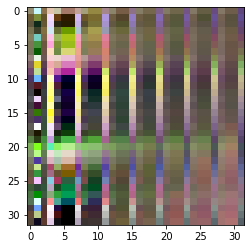

last image:463


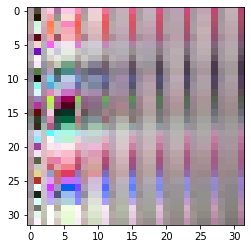

Total number of images nTotal= 433


In [ ]:

N=len(DF)
first=31
last=N-1
cols=list(range(32))
img_first = create_img(DF,DF1,DF2,cols,31)
img_last  = create_img(DF,DF1,DF2,cols,N-1)

print(f"first image:{first}")
show_img(img_first)
print(f"last image:{last}")
show_img(img_last)
nTotal=N-31
print("Total number of images nTotal=",nTotal)

In [ ]:
"""
imgs=[]
for r in range(31,len(DF)):
  imgs.append(create_img(DF,DF1,DF2,cols,r))
show_img(imgs[0])
show_img(imgs[-1])
"""

'\nimgs=[]\nfor r in range(31,len(DF)):\n  imgs.append(create_img(DF,DF1,DF2,cols,r))\nshow_img(imgs[0])\nshow_img(imgs[-1])\n'

Save images.<br>Create directory root with two subdirectories: test and train. <br>Both test and train hacve subdurectories long, none, and short


In [ ]:
lClasses=['long','none','short']
lClasses.sort()
print(lClasses)

"""
middle=int(first+0.95*(last-first))
print("first=",first,"last=",last,"midle=",middle, "\nNumber of train/val imgs=",nPerms*(middle-first+1),"=nPerms*(middle-first+1)")
print("Number of test imgs=",last-middle+1,"=1*(last-middle+1)")
"""
# remove directory 'root'
import shutil
if os.path.isdir('root'): shutil.rmtree('root')
# Create in root directories train and test
directory = r'root/train'

for symb in lClasses:
    path=os.path.join(directory, symb)
    if not os.path.exists(path):
        os.makedirs(path)
directory = r'root/test'
for symb in lClasses:
    path=os.path.join(directory, symb)
    if not os.path.exists(path):
        os.makedirs(path)

['long', 'none', 'short']


Test directory is for saving images calculate based on dfStock, dfDow, and dfNasdaq, where dfStock corresponds to IBM. This directory has N-nHold images, where N =len(DF). <br>Train directory is based on dfStock, dfDow, and dfNasdaq, where dfStock corresponds to the other tickers from the wathing_list.Ttain directory has (m-3)\*(N-nHold) images, where m is the number of tickers in the watch_list. 
<br>First save images in test directory.

In [ ]:
def save_imgs(dir,DF,DF1,DF2,target,lst_count):
  cols=list(range(32))
  lst_paths_by_r=[""]
  for r in range(31,len(DF)):
    img=create_img(DF,DF1,DF2,cols,r)
    i=int(target.iloc[r])
    path= dir+str(lClasses[i])        
    lst_count[i]+=1
    name=str(int(lst_count[i]))
    while(len(name)<6): name='0'+name
    path=path+'/'+name+'.png'
    img.save(path)
  return lst_count#?????intent


# save test imgs
lst_count=np.zeros([3])
count_test=save_imgs('root/test/',DF,DF1,DF2,target,lst_count)
print("count of test imgs:",count_test)


count of test imgs: [163. 124. 146.]


Now calculate and save train images.

In [ ]:
# save train imgs)

if 'IBM' in watch_list: watch_list.remove('IBM')
if '^DJI' in watch_list: watch_list.remove('^DJI')
if '^IXIC' in watch_list: watch_list.remove('^IXIC')
print(watch_list)

count=0
lst_count=np.zeros([3])
for ticker in watch_list:
  dfStock=zoom_in(dict_df[ticker],left='2000-12-27',right='2003-1-1')
  DF,DF1,DF2,target=get_TSy(dfStock,dfDow,dfNasdaq,nHold,funcs,ars)
  ans=save_imgs('root/train/',DF,DF1,DF2,target,lst_count)
  lst_count[0]+=ans[0]
  lst_count[1]+=ans[1]
  lst_count[2]+=ans[2]

print("count of train&validation imgs:",count)
"""
N=len(DF)
cols=list(range(32))
img_0 = create_img(DF,DF1,DF2,cols,31)
show_img(img_0)

dfStock=zoom_in(dict_df[watch_list[1]],left='2000-12-27',right='2003-1-1')
DF,DF1,DF2,target=get_TSy(dfStock,dfDow,dfNasdaq,nHold,funcs,ars)
N=len(DF)
cols=list(range(32))
img_1 = create_img(DF,DF1,DF2,cols,31)
show_img(img_1)
"""

['AAPL', 'AMZN', 'MSFT', 'PFE', 'XOM', 'T', 'BA', 'V']
count of train&validation imgs: 0


"\nN=len(DF)\ncols=list(range(32))\nimg_0 = create_img(DF,DF1,DF2,cols,31)\nshow_img(img_0)\n\ndfStock=zoom_in(dict_df[watch_list[1]],left='2000-12-27',right='2003-1-1')\nDF,DF1,DF2,target=get_TSy(dfStock,dfDow,dfNasdaq,nHold,funcs,ars)\nN=len(DF)\ncols=list(range(32))\nimg_1 = create_img(DF,DF1,DF2,cols,31)\nshow_img(img_1)\n"

##Datasets
After images are created and saved, instanciate two datasets: "dataset" - for training and validating a model, and "test_dataset" - for testing the model. test_dataset[i] is a tuple img, label, see the labels of test_dataset

images for training and validation -  3464 for testing - 433
['long', 'none', 'short']
['long', 'none', 'short']
Label:  long (0)


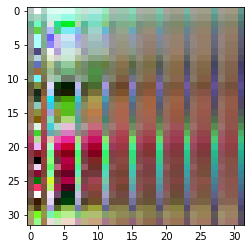

In [ ]:
dataset = ImageFolder('root/train', transform=ToTensor())
test_dataset = ImageFolder('root/test', transform=ToTensor())

print("images for training and validation - ",len(dataset),"for testing -",len(test_dataset))
print(dataset.classes)
print(test_dataset.classes)

# show image
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

show_example(*dataset[0])

We need to split "dataset" to train_ds and val_ds. We do it randomly; 10% goes to val_ds, 90% - to train_ds.

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

val_size = int(len(dataset)/10)
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(3118, 346)

Create data loaders for training and validation, to load the data in batches

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


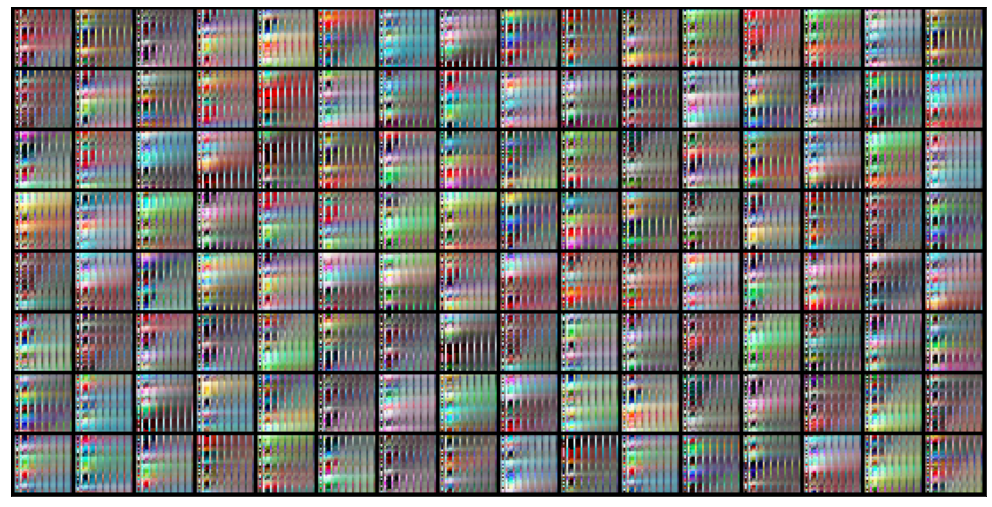

In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size=128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(18, 9))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_dl)

To define convolutional network, we need convolution function and classification class:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
      images, labels = batch 
      out = self(images)                  # Generate predictions
      loss = F.cross_entropy(out, labels) # Calculate loss
      return loss
  
  def validation_step(self, batch):
      images, labels = batch 
      out = self(images)                    # Generate predictions
      loss = F.cross_entropy(out, labels)   # Calculate loss
      acc = accuracy(out, labels)           # Calculate accuracy
      return {'val_loss': loss.detach(), 'val_acc': acc}
      
  def validation_epoch_end(self, outputs):
      batch_losses = [x['val_loss'] for x in outputs]
      epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
      batch_accs = [x['val_acc'] for x in outputs]
      epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
      return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
  
  def epoch_end(self, epoch, result):
      print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
          epoch, result['train_loss'], result['val_loss'], result['val_acc']))
      
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 3))
        
    def forward(self, xb):
        return self.network(xb)

model = Cifar10CnnModel()
print(model)

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

Verify that the model produces the expected output on a batch of training data

In [ ]:
n=0
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print(n,'out[n]:', out[n])
    n+=1
    if n==5: break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 3])
0 out[n]: tensor([ 0.0370, -0.0207, -0.0061], grad_fn=<SelectBackward0>)
images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 3])
1 out[n]: tensor([ 0.0371, -0.0206, -0.0061], grad_fn=<SelectBackward0>)
images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 3])
2 out[n]: tensor([ 0.0370, -0.0207, -0.0062], grad_fn=<SelectBackward0>)
images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 3])
3 out[n]: tensor([ 0.0369, -0.0208, -0.0061], grad_fn=<SelectBackward0>)
images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 3])
4 out[n]: tensor([ 0.0369, -0.0207, -0.0062], grad_fn=<SelectBackward0>)


The out vectors of the model are too close. Still let us try totrain the model.<br>To use a GPU, if one is available, define helper functions

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
print(device)

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

cuda


Define two functions: fit and evaluate to train the model

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Instantiate the model once again and see how it performs on the validation set with the initial set of parameters.

In [ ]:
model = to_device(Cifar10CnnModel(), device)
evaluate(model, val_dl)

{'val_loss': 1.0995807647705078, 'val_acc': 0.30954861640930176}

Use the following hyperparmeters (no. of epochs,learning rate,opyimizer) and train the model

In [ ]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.0987, val_loss: 1.0993, val_acc: 0.3411
Epoch [1], train_loss: 1.0974, val_loss: 1.0978, val_acc: 0.3411
Epoch [2], train_loss: 1.0965, val_loss: 1.0981, val_acc: 0.3411
Epoch [3], train_loss: 1.0973, val_loss: 1.0980, val_acc: 0.3411
Epoch [4], train_loss: 1.0965, val_loss: 1.0976, val_acc: 0.3411
Epoch [5], train_loss: 1.0965, val_loss: 1.0977, val_acc: 0.3411
Epoch [6], train_loss: 1.0969, val_loss: 1.0979, val_acc: 0.3411
Epoch [7], train_loss: 1.0967, val_loss: 1.0976, val_acc: 0.3411
Epoch [8], train_loss: 1.0966, val_loss: 1.0980, val_acc: 0.3411
Epoch [9], train_loss: 1.0972, val_loss: 1.0979, val_acc: 0.3411
Epoch [10], train_loss: 1.0965, val_loss: 1.0980, val_acc: 0.3411
Epoch [11], train_loss: 1.0966, val_loss: 1.0978, val_acc: 0.3411
Epoch [12], train_loss: 1.0967, val_loss: 1.0983, val_acc: 0.3411
Epoch [13], train_loss: 1.0968, val_loss: 1.0980, val_acc: 0.3411
Epoch [14], train_loss: 1.0965, val_loss: 1.0982, val_acc: 0.3411
Epoch [15], train_lo

Plot accuracy

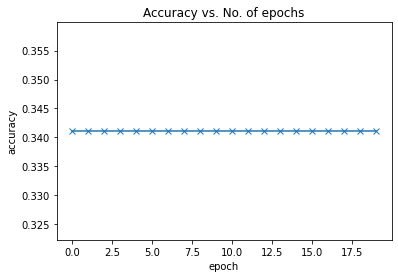

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

Plot the training and validation losses to study the trend.

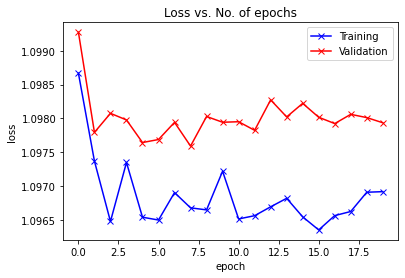

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

For testing, define a helper function predict_image, which returns the predicted label for a single image tensor.

Label: long , Predicted: long
433
['long', 'none', 'short']
matr= [[163, 0, 0], [124, 0, 0], [146, 0, 0]]


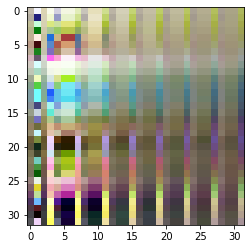

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]


i=0
img, label = test_dataset[i]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

print(len(test_dataset))
print(lClasses)
matr=[[0,0,0],
      [0,0,0],
      [0,0,0]]
for i in range(len(test_dataset)):
  img, label = test_dataset[i]
  real= dataset.classes[label]
  r=lClasses.index(real)
  pred= predict_image(img, model)
  p=lClasses.index(pred)
  matr[r][p]+=1

print("matr=",matr)



Look at the overall loss and accuracy of the model on the test set.

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 9.108558654785156, 'val_acc': 0.3971354365348816}

## Refertences 

In [ ]:
"""
Portfolio
https://lumos-datascience.medium.com/mean-variance-portfolio-optimization-using-python-8485fccb9f8b

https://nicobesser.medium.com/python-for-finance-portfolio-optimization-and-the-value-of-diversifying-99ef8e5cfbdc 

# https://www.analyticsvidhya.com/blog/2021/04/portfolio-optimization-using-mpt-in-python/ 

https://www.analyticsvidhya.com/blog/2021/04/portfolio-optimization-using-mpt-in-python/ 

https://www.kenwuyang.com/en/post/portfolio-optimization-with-python/ 

https://www.codingfinance.com/post/2018-05-31-portfolio-opt-in-python/ 
 """


'\nPortfolio\nhttps://lumos-datascience.medium.com/mean-variance-portfolio-optimization-using-python-8485fccb9f8b\n\nhttps://nicobesser.medium.com/python-for-finance-portfolio-optimization-and-the-value-of-diversifying-99ef8e5cfbdc \n\n# https://www.analyticsvidhya.com/blog/2021/04/portfolio-optimization-using-mpt-in-python/ \n\nhttps://www.analyticsvidhya.com/blog/2021/04/portfolio-optimization-using-mpt-in-python/ \n\nhttps://www.kenwuyang.com/en/post/portfolio-optimization-with-python/ \n\nhttps://www.codingfinance.com/post/2018-05-31-portfolio-opt-in-python/ \n '